### Imports

In [2]:
!pip install -qU scikit-fuzzy

In [66]:
import os
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import tensorflow as tf

warnings.filterwarnings('ignore')

### Understanding the Dataset

In [3]:
np.random.seed(42)

In [4]:
os.makedirs('visualizations', exist_ok=True)

In [5]:
df = pd.read_csv('generated_datasets/main.csv')

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (1000, 134)

First 5 rows:
   sample_id  V_sourcebus  Angle_sourcebus       V_1   Angle_1       V_2  \
0        0.0     1.036247        -1.892540  1.033998 -1.939335  1.021994   
1        1.0     1.035681        -1.927076  1.033378 -1.973933  1.021086   
2        2.0     1.036158        -1.898386  1.033900 -1.945209  1.021848   
3        3.0     1.034170        -2.014092  1.031727 -2.060886  1.018690   
4        4.0     1.037232        -1.833515  1.035076 -1.880254  1.023569   

    Angle_2       V_3   Angle_3       V_4  ...        P_29       Q_29  \
0 -2.187912  1.014394 -2.373972  1.008017  ...  140.344078  93.562719   
1 -2.222826  1.013062 -2.409803  1.006632  ...  129.623625  86.415750   
2 -2.193933  1.014281 -2.379916  1.007966  ...  122.044074  81.362716   
3 -2.309379  1.010252 -2.495909  1.003398  ...  117.967465  78.644976   
4 -2.128563  1.016091 -2.314264  1.009927  ...  149.313076  99.542051   

         P_30        Q_30        P_31       Q_31        P_32  

In [6]:
print("\nData Types and Missing Values:")
print(df.info())


Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 134 entries, sample_id to Q_33
dtypes: float64(134)
memory usage: 1.0 MB
None


In [7]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
         sample_id  V_sourcebus  Angle_sourcebus          V_1      Angle_1  \
count  1000.000000  1000.000000      1000.000000  1000.000000  1000.000000   
mean    499.500000     1.035557        -1.933444     1.033243    -1.980262   
std     288.819436     0.001171         0.063697     0.001276     0.063494   
min       0.000000     1.031870        -2.140012     1.029220    -2.186423   
25%     249.750000     1.034766        -1.975829     1.032376    -2.022615   
50%     499.500000     1.035584        -1.930829     1.033272    -1.977781   
75%     749.250000     1.036342        -1.890305     1.034098    -1.937412   
max     999.000000     1.038916        -1.742304     1.036898    -1.789256   

               V_2      Angle_2          V_3      Angle_3          V_4  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      1.020893    -2.228933     1.013018    -2.415271     1.006482  ...   
std       0.001835     0.062381     0.002

In [8]:
# Identify different types of columns
sample_id_cols = [col for col in df.columns if 'sample_id' in col]
voltage_cols = [col for col in df.columns if col.startswith('V_')]
angle_cols = [col for col in df.columns if col.startswith('Angle_')]
load_p_cols = [col for col in df.columns if col.startswith('P_')]
load_q_cols = [col for col in df.columns if col.startswith('Q_')]
loss_cols = [col for col in df.columns if 'losses' in col]

print("\nColumn Categories:")
print(f"Sample ID Columns: {len(sample_id_cols)}")
print(f"Voltage Columns: {len(voltage_cols)}")
print(f"Angle Columns: {len(angle_cols)}")
print(f"Active Power Load Columns: {len(load_p_cols)}")
print(f"Reactive Power Load Columns: {len(load_q_cols)}")
print(f"Loss Columns: {len(loss_cols)}")


Column Categories:
Sample ID Columns: 1
Voltage Columns: 34
Angle Columns: 34
Active Power Load Columns: 32
Reactive Power Load Columns: 32
Loss Columns: 1


### Exploratory Data Analysis (EDA)

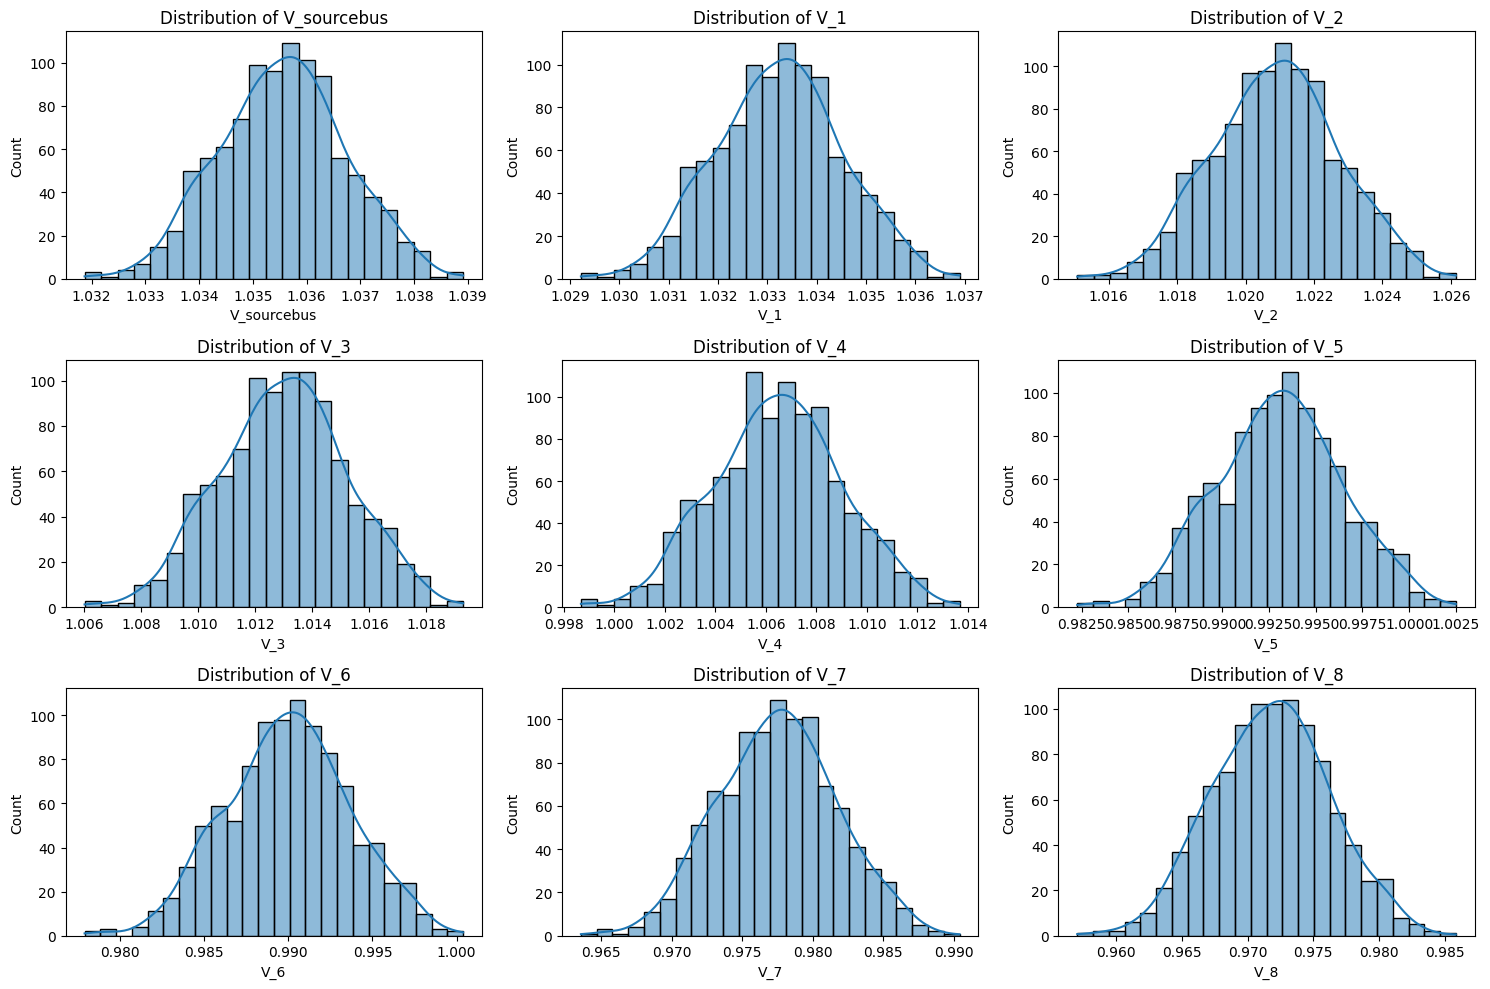

In [9]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(voltage_cols[:9]):  # First 9 voltage columns for clarity
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.savefig('visualizations/voltage_distributions.png')
plt.show()
plt.close()

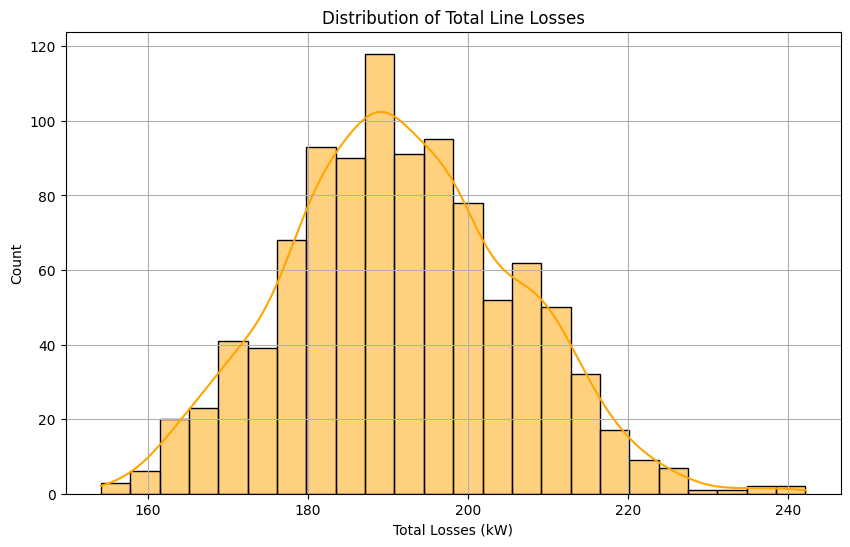

In [10]:
# Distribution of total losses
plt.figure(figsize=(10, 6))
sns.histplot(df[loss_cols[0]], kde=True, color='orange')
plt.title('Distribution of Total Line Losses')
plt.xlabel('Total Losses (kW)')
plt.grid(True)
plt.savefig('visualizations/losses_distribution_detailed.png')
plt.show()
plt.close()

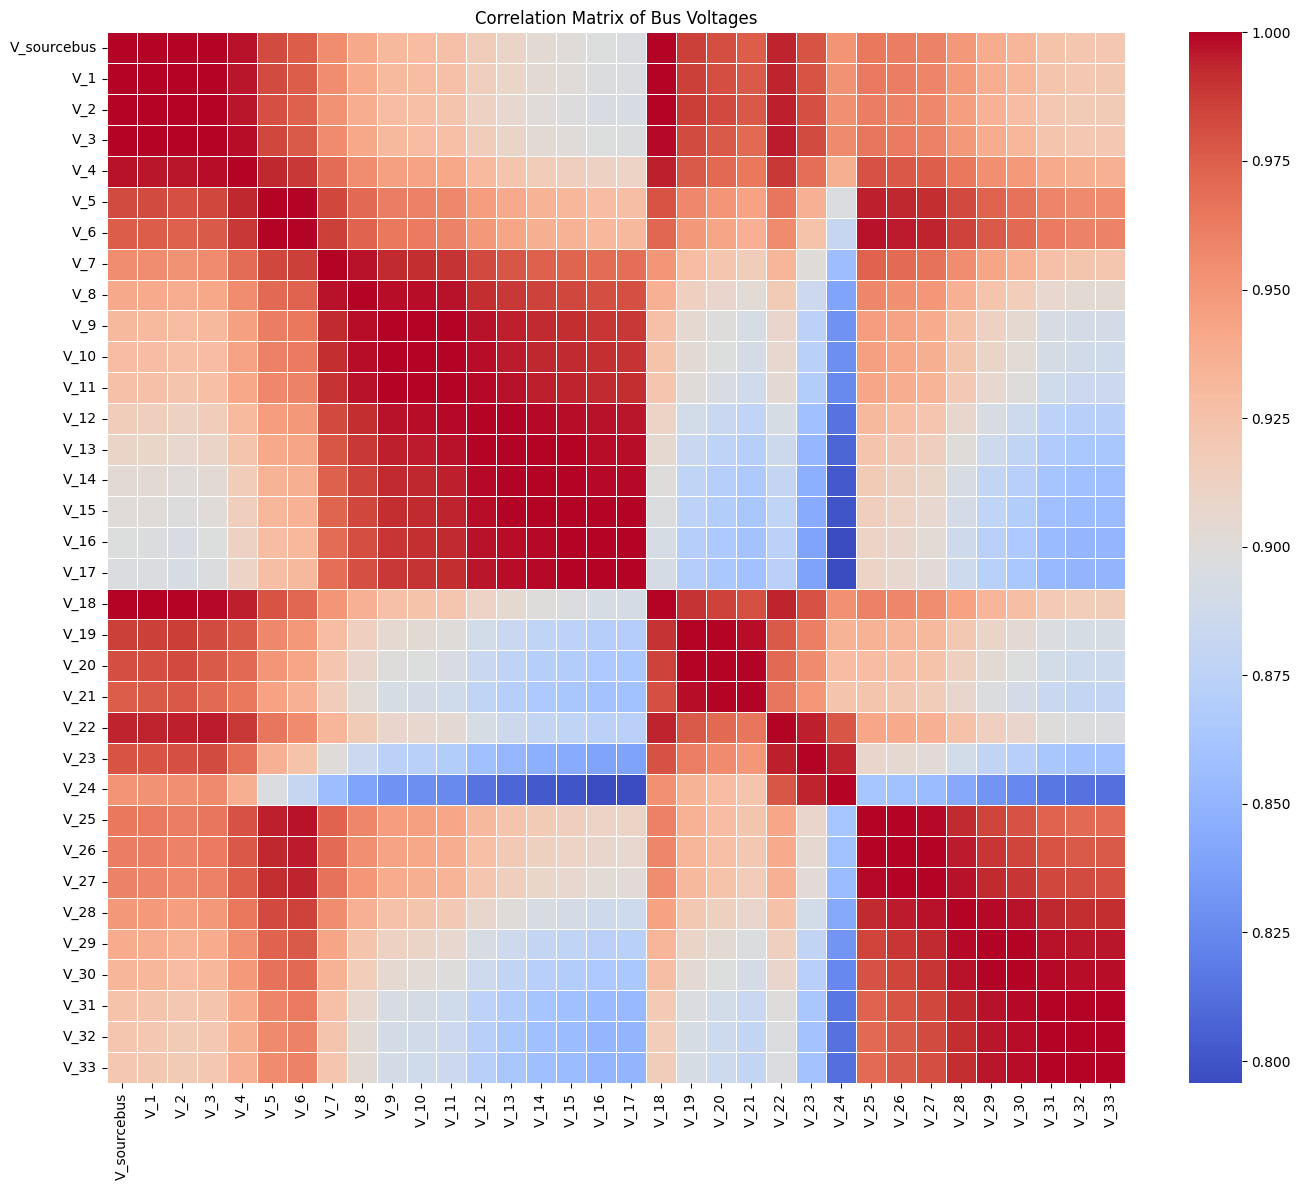

In [11]:
# Correlation matrix between voltages
plt.figure(figsize=(14, 12))
voltage_corr = df[voltage_cols].corr()
sns.heatmap(voltage_corr, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Bus Voltages')
plt.tight_layout()
plt.savefig('visualizations/voltage_correlation.png')
plt.show()
plt.close()

<Figure size 1500x1000 with 0 Axes>

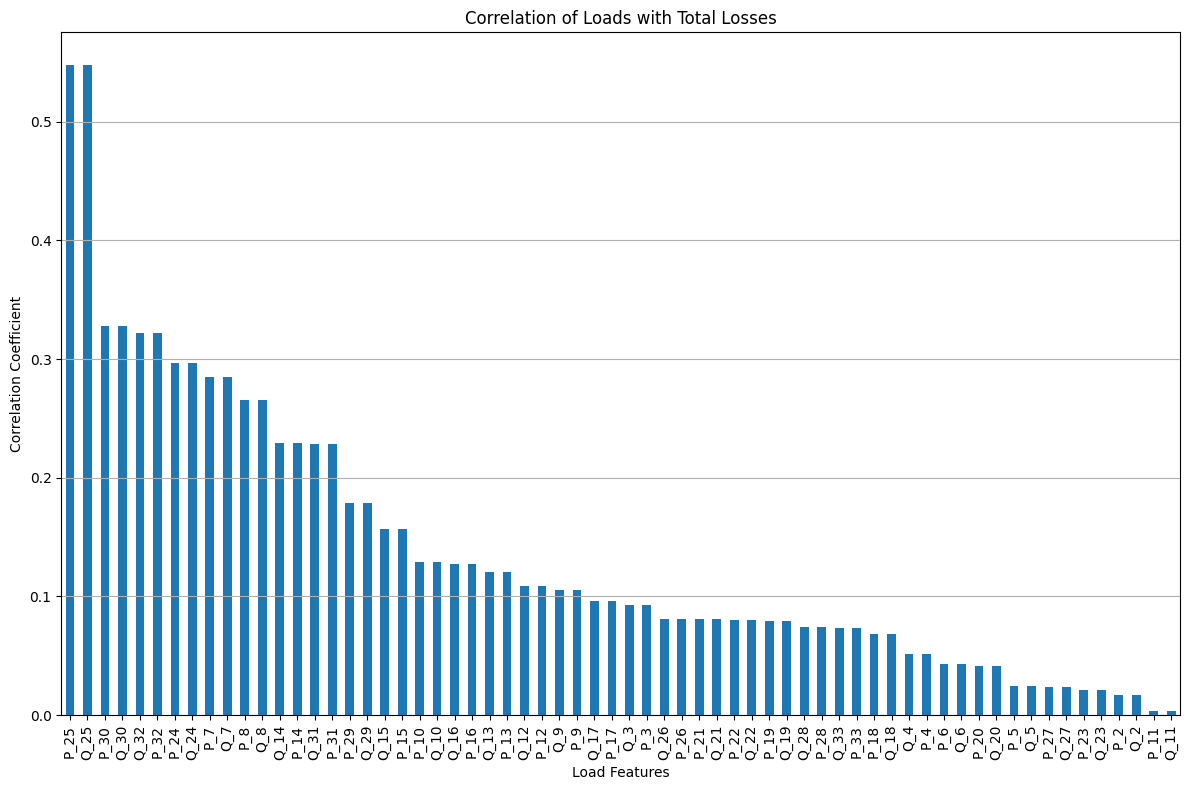

In [12]:
# Correlation between loads and total losses
load_loss_cols = load_p_cols + load_q_cols + loss_cols
plt.figure(figsize=(15, 10))
load_loss_corr = df[load_loss_cols].corr()[loss_cols[0]].drop(loss_cols)
load_loss_corr = load_loss_corr.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
load_loss_corr.plot(kind='bar')
plt.title('Correlation of Loads with Total Losses')
plt.xlabel('Load Features')
plt.ylabel('Correlation Coefficient')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('visualizations/load_loss_correlation.png')
plt.show()
plt.close()

<Figure size 1200x1000 with 0 Axes>

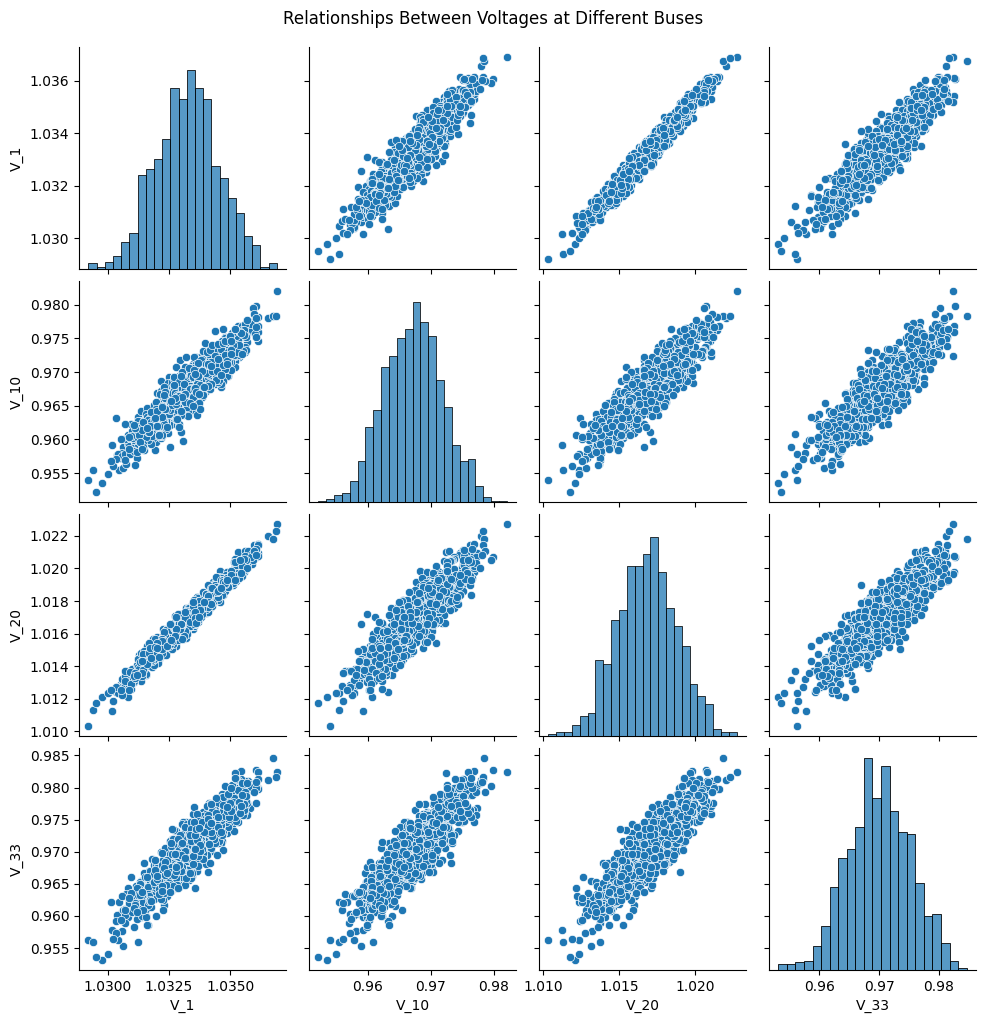

In [13]:
# Scatterplot matrix for selected buses
selected_buses = ['V_1', 'V_10', 'V_20', 'V_33']
plt.figure(figsize=(12, 10))
sns.pairplot(df[selected_buses])
plt.suptitle('Relationships Between Voltages at Different Buses', y=1.02)
plt.savefig('visualizations/voltage_pairplot.png')
plt.show()
plt.close()

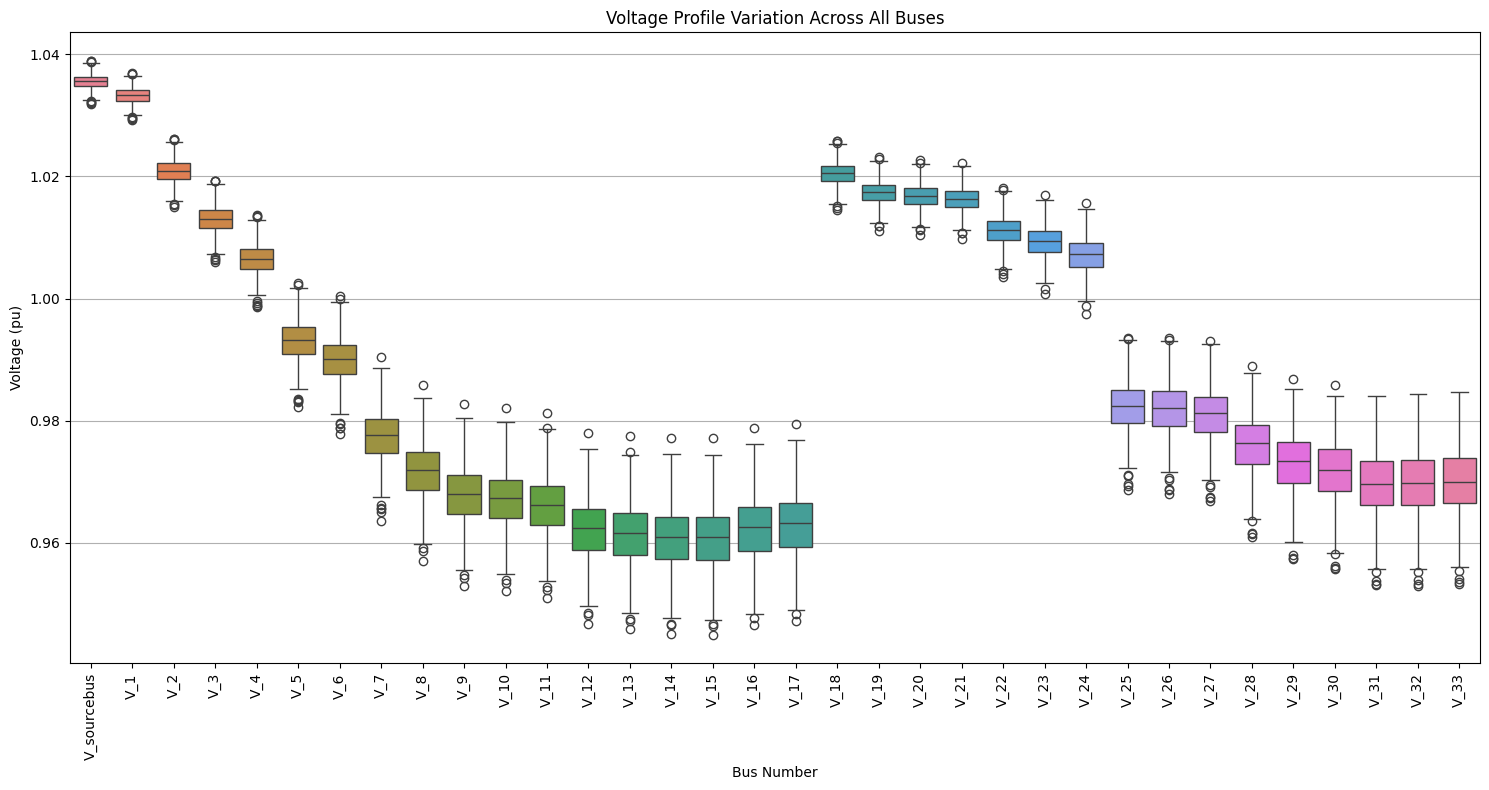

In [14]:
# Box plots for voltage profiles
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[voltage_cols])
plt.title('Voltage Profile Variation Across All Buses')
plt.xlabel('Bus Number')
plt.ylabel('Voltage (pu)')
plt.xticks(rotation=90)
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('visualizations/voltage_boxplot.png')
plt.show()
plt.close()

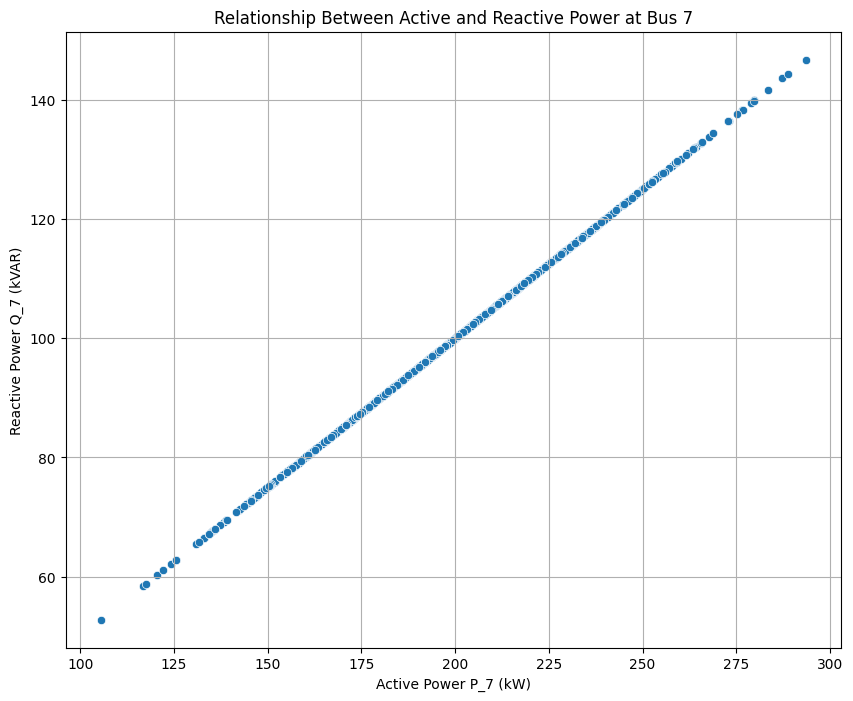

In [15]:
# Relationship between active and reactive power for a specific bus
bus_to_analyze = '7'
plt.figure(figsize=(10, 8))
sns.scatterplot(x=f'P_{bus_to_analyze}', y=f'Q_{bus_to_analyze}', data=df)
plt.title(f'Relationship Between Active and Reactive Power at Bus {bus_to_analyze}')
plt.xlabel(f'Active Power P_{bus_to_analyze} (kW)')
plt.ylabel(f'Reactive Power Q_{bus_to_analyze} (kVAR)')
plt.grid(True)
plt.savefig(f'visualizations/P_Q_relationship_bus_{bus_to_analyze}.png')
plt.show()
plt.close()

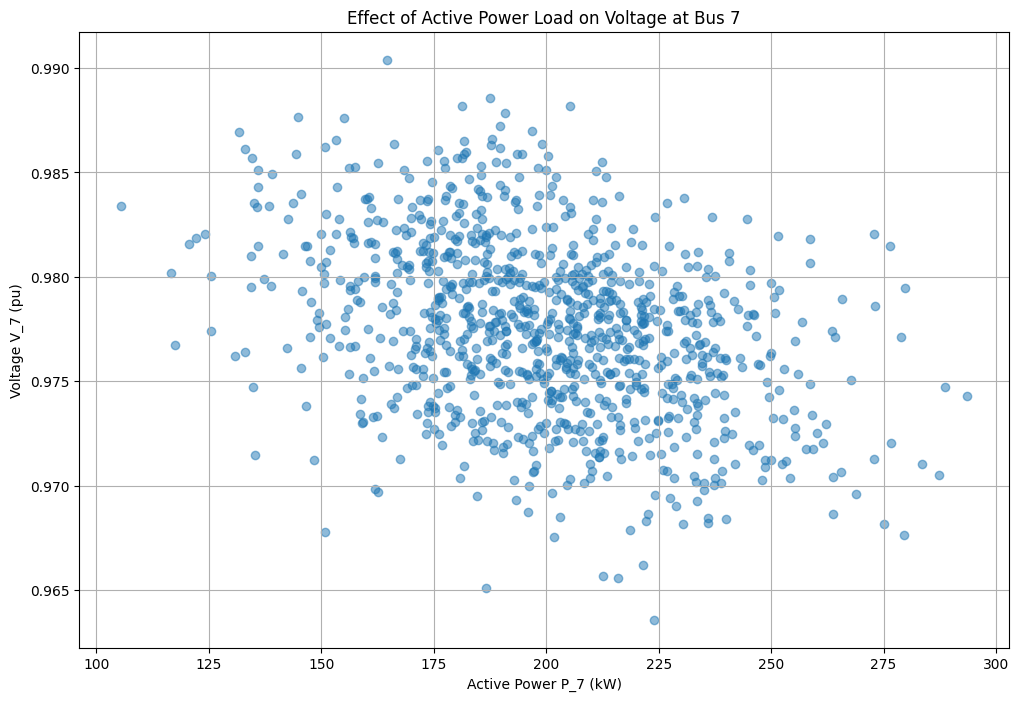

In [16]:
# Effect of load on voltage for a specific bus
plt.figure(figsize=(12, 8))
plt.scatter(df[f'P_{bus_to_analyze}'], df[f'V_{bus_to_analyze}'], alpha=0.5)
plt.title(f'Effect of Active Power Load on Voltage at Bus {bus_to_analyze}')
plt.xlabel(f'Active Power P_{bus_to_analyze} (kW)')
plt.ylabel(f'Voltage V_{bus_to_analyze} (pu)')
plt.grid(True)
plt.savefig(f'visualizations/load_voltage_effect_bus_{bus_to_analyze}.png')
plt.show()
plt.close()

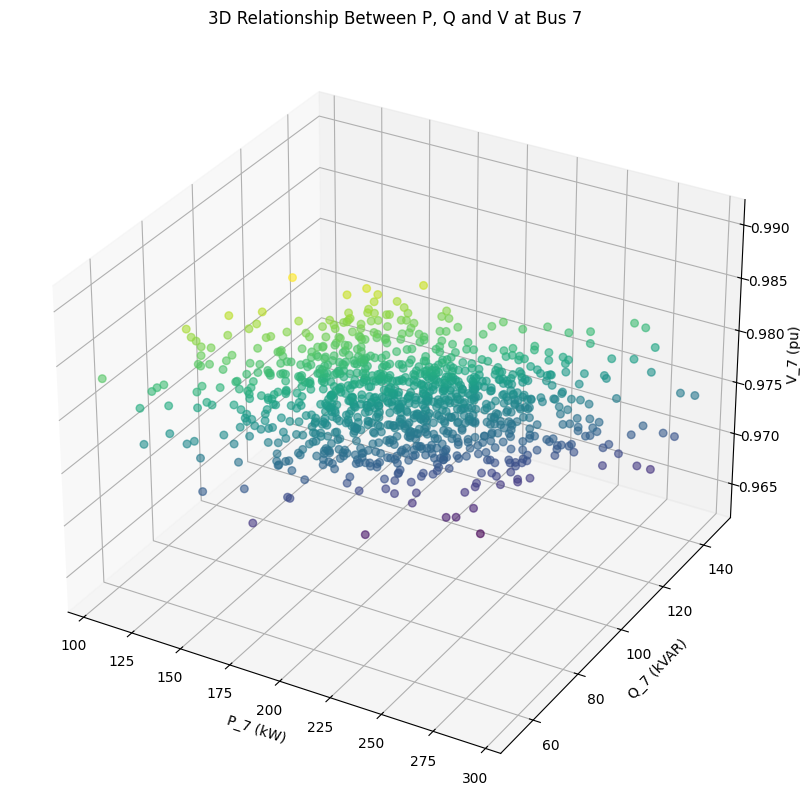

In [17]:
# 3D plot showing relationship between P, Q and V for a specific bus
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[f'P_{bus_to_analyze}'], df[f'Q_{bus_to_analyze}'], 
           df[f'V_{bus_to_analyze}'], c=df[f'V_{bus_to_analyze}'], cmap='viridis', s=30, alpha=0.6)
ax.set_xlabel(f'P_{bus_to_analyze} (kW)')
ax.set_ylabel(f'Q_{bus_to_analyze} (kVAR)')
ax.set_zlabel(f'V_{bus_to_analyze} (pu)')
ax.set_title(f'3D Relationship Between P, Q and V at Bus {bus_to_analyze}')
plt.savefig(f'visualizations/3D_PQV_relationship_bus_{bus_to_analyze}.png')
plt.show()
plt.close()

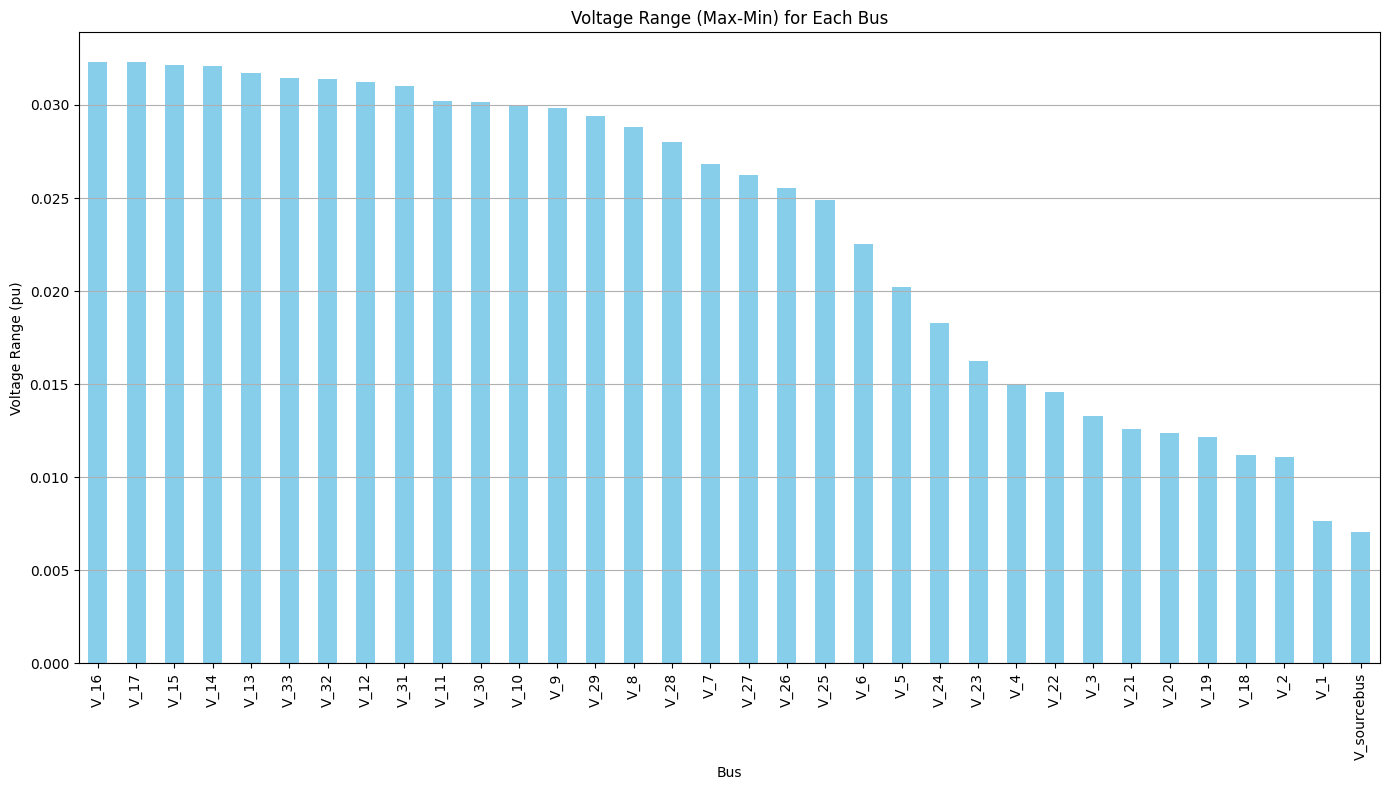

In [18]:
# Summary statistics of voltage profiles
voltage_stats = df[voltage_cols].describe().T
voltage_stats['range'] = voltage_stats['max'] - voltage_stats['min']
voltage_stats['coefficient_of_variation'] = voltage_stats['std'] / voltage_stats['mean'] * 100

# Sort by range to identify buses with highest voltage variations
voltage_stats_sorted = voltage_stats.sort_values(by='range', ascending=False)

plt.figure(figsize=(14, 8))
voltage_stats_sorted['range'].plot(kind='bar', color='skyblue')
plt.title('Voltage Range (Max-Min) for Each Bus')
plt.xlabel('Bus')
plt.ylabel('Voltage Range (pu)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig('visualizations/voltage_range_by_bus.png')
plt.show()
plt.close()

In [19]:
# Save the voltage statistics to a CSV file
voltage_stats_sorted.to_csv('visualizations/voltage_statistics.csv')

### Data Preprocessing for ML Models

In [20]:
def prepare_data(df, target_type='voltage', specific_target=None, test_size=0.2):
    """
    Prepare data for machine learning models
    
    Parameters:
    df: pandas DataFrame - The input dataset
    target_type: str - 'voltage', 'loss', or 'all_voltages'
    specific_target: str - Specific column to predict (e.g., 'V_7')
    test_size: float - Proportion of data to use for testing
    
    Returns:
    X_train, X_test, y_train, y_test, scaler_X, scaler_y (if applicable)
    """
    features = load_p_cols + load_q_cols
    
    # Define target based on target_type
    if target_type == 'voltage' and specific_target:
        # Predict a specific bus voltage
        if specific_target not in voltage_cols:
            raise ValueError(f"Specific target {specific_target} not found in voltage columns")
        targets = [specific_target]
    elif target_type == 'loss':
        # Predict total losses
        targets = loss_cols
    elif target_type == 'all_voltages':
        # Predict all bus voltages
        targets = voltage_cols
    else:
        raise ValueError("Invalid target_type. Must be 'voltage', 'loss', or 'all_voltages'")
    
    X = df[features]
    y = df[targets]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Scale features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    
    if len(targets) == 1:
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y
    else:
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)
        return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, scaler_X, scaler_y

print("\nPreparing datasets for different prediction tasks...")

# 1. Dataset for predicting voltage at a specific bus (e.g., bus 16 which might be more sensitive)
bus_to_predict = 'V_16'
X_train_v16, X_test_v16, y_train_v16, y_test_v16, scaler_X_v16, scaler_y_v16 = prepare_data(
    df, target_type='voltage', specific_target=bus_to_predict
)
print(f"Prepared dataset for predicting {bus_to_predict}")

# 2. Dataset for predicting total losses
X_train_loss, X_test_loss, y_train_loss, y_test_loss, scaler_X_loss, scaler_y_loss = prepare_data(
    df, target_type='loss'
)
print("Prepared dataset for predicting total losses")

# 3. Dataset for predicting all voltages (multi-output regression)
X_train_all_v, X_test_all_v, y_train_all_v, y_test_all_v, scaler_X_all_v, scaler_y_all_v = prepare_data(
    df, target_type='all_voltages'
)
print("Prepared dataset for predicting all bus voltages")


Preparing datasets for different prediction tasks...
Prepared dataset for predicting V_16
Prepared dataset for predicting total losses
Prepared dataset for predicting all bus voltages


In [21]:
print("\nDataset shapes:")
print(f"Single voltage prediction ({bus_to_predict}):")
print(f"  X_train: {X_train_v16.shape}, y_train: {y_train_v16.shape}")
print(f"  X_test: {X_test_v16.shape}, y_test: {y_test_v16.shape}")

print("\nTotal losses prediction:")
print(f"  X_train: {X_train_loss.shape}, y_train: {y_train_loss.shape}")
print(f"  X_test: {X_test_loss.shape}, y_test: {y_test_loss.shape}")

print("\nAll voltages prediction:")
print(f"  X_train: {X_train_all_v.shape}, y_train: {y_train_all_v.shape}")
print(f"  X_test: {X_test_all_v.shape}, y_test: {y_test_all_v.shape}")

# save prepared data for later use
def save_prepared_data(name, X_train, X_test, y_train, y_test):
    np.save(f'prepared_data/X_train_{name}.npy', X_train)
    np.save(f'prepared_data/X_test_{name}.npy', X_test)
    np.save(f'prepared_data/y_train_{name}.npy', y_train)
    np.save(f'prepared_data/y_test_{name}.npy', y_test)

os.makedirs('prepared_data', exist_ok=True)
save_prepared_data('v16', X_train_v16, X_test_v16, y_train_v16, y_test_v16)
save_prepared_data('loss', X_train_loss, X_test_loss, y_train_loss, y_test_loss)
save_prepared_data('all_v', X_train_all_v, X_test_all_v, y_train_all_v, y_test_all_v)

print("\nPrepared datasets saved to 'prepared_data' directory")


Dataset shapes:
Single voltage prediction (V_16):
  X_train: (800, 64), y_train: (800, 1)
  X_test: (200, 64), y_test: (200, 1)

Total losses prediction:
  X_train: (800, 64), y_train: (800, 1)
  X_test: (200, 64), y_test: (200, 1)

All voltages prediction:
  X_train: (800, 64), y_train: (800, 34)
  X_test: (200, 64), y_test: (200, 34)

Prepared datasets saved to 'prepared_data' directory


In [26]:
os.makedirs('models', exist_ok=True)

# Save feature and target column names
feature_cols = {
    'load_p_cols': load_p_cols,
    'load_q_cols': load_q_cols,
    'voltage_cols': voltage_cols,
    'loss_cols': loss_cols
}

with open('models/column_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

# Save scalers
scalers = {
    'v16': {'X': scaler_X_v16, 'y': scaler_y_v16},
    'loss': {'X': scaler_X_loss, 'y': scaler_y_loss},
    'all_v': {'X': scaler_X_all_v, 'y': scaler_y_all_v}
}

with open('models/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

print("Column names and scalers saved to 'models' directory")

Column names and scalers saved to 'models' directory


In [27]:
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Function to load prepared data
def load_prepared_data(name):
    X_train = np.load(f'prepared_data/X_train_{name}.npy')
    X_test = np.load(f'prepared_data/X_test_{name}.npy')
    y_train = np.load(f'prepared_data/y_train_{name}.npy')
    y_test = np.load(f'prepared_data/y_test_{name}.npy')
    return X_train, X_test, y_train, y_test

# Function to load scalers
def load_scalers():
    with open('models/scalers.pkl', 'rb') as f:
        scalers = pickle.load(f)
    return scalers

# Function to load column names
def load_column_names():
    with open('models/column_names.pkl', 'rb') as f:
        column_names = pickle.load(f)
    return column_names

In [28]:
# Load all data sets
X_train_v16, X_test_v16, y_train_v16, y_test_v16 = load_prepared_data('v16')
X_train_loss, X_test_loss, y_train_loss, y_test_loss = load_prepared_data('loss')
X_train_all_v, X_test_all_v, y_train_all_v, y_test_all_v = load_prepared_data('all_v')

# Load scalers and column names
scalers = load_scalers()
column_names = load_column_names()

# Create feature names for plotting
load_feature_names = column_names['load_p_cols'] + column_names['load_q_cols']
voltage_feature_names = column_names['voltage_cols']

In [29]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Custom metrics for power system applications
    # Normalized RMSE (NRMSE)
    y_range = np.max(y_true) - np.min(y_true)
    nrmse = rmse / y_range if y_range != 0 else rmse
    
    # Mean Absolute Percentage Error (MAPE)
    non_zero_mask = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(y_true - y_pred))
    
    # Additional power system specific metric: Voltage Deviation Index (for voltage predictions)
    # Assumeing values close to 1.0 pu are optimal
    if "V_" in column_names['voltage_cols'][0]:  # Only for voltage predictions
        nominal_voltage = 1.0  # Assuming 1.0 pu as nominal
        vdi = np.mean(np.abs(y_pred - nominal_voltage))
    else:
        vdi = None
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'NRMSE': nrmse,
        'MAPE': mape if not np.isnan(mape) else None,
        'Max Error': max_error,
        'VDI': vdi
    }

In [ ]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_true, y_pred, title, filename):
    plt.figure(figsize=(10, 6))
    
    # If multi-output, plot for first few outputs
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        for i in range(min(5, y_true.shape[1])):
            plt.subplot(2, 3, i+1)
            plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5)
            plt.plot([y_true[:, i].min(), y_true[:, i].max()], 
                     [y_true[:, i].min(), y_true[:, i].max()], 
                     'r--', lw=2)
            plt.title(f'Output {i+1}')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.grid(True)
        
        plt.tight_layout()
    else:
        # Single output
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], 
                 [y_true.min(), y_true.max()], 
                 'r--', lw=2)
        plt.title(title)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)
    
    plt.savefig(f'figures/{filename}.png', dpi=300, bbox_inches='tight')
    plt.close()

In [32]:
print(f"V_16 dataset shapes: X_train: {X_train_v16.shape}, y_train: {y_train_v16.shape}")
print(f"Loss dataset shapes: X_train: {X_train_loss.shape}, y_train: {y_train_loss.shape}")
print(f"All voltages dataset shapes: X_train: {X_train_all_v.shape}, y_train: {y_train_all_v.shape}")

V_16 dataset shapes: X_train: (800, 64), y_train: (800, 1)
Loss dataset shapes: X_train: (800, 64), y_train: (800, 1)
All voltages dataset shapes: X_train: (800, 64), y_train: (800, 34)


### Random Forest Model

In [39]:
def train_rf_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    # Training convergence tracking
    train_errors = []
    val_errors = []
    
    # 1. Base model for quick evaluation
    print(f"\nTraining base Random Forest model for {target_name}...")
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train)
    
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train_pred = y_train_pred.reshape(-1, 1)
        y_test_pred = y_test_pred.reshape(-1, 1)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base RF Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base RF Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': rf_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred
    }
    
    # 2. Sensitivity Analysis
    print(f"\nPerforming sensitivity analysis on number of trees...")
    n_estimators_list = [10, 50, 100, 200]
    trees_results = []
    
    for n_trees in n_estimators_list:
        print(f"Training with {n_trees} trees...")
        start_time = time.time()
        
        rf = RandomForestRegressor(n_estimators=n_trees, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train)
        
        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)
        
        if len(y_train.shape) == 2 and y_train.shape[1] == 1:
            train_pred = train_pred.reshape(-1, 1)
            test_pred = test_pred.reshape(-1, 1)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        
        trees_results.append({
            'n_trees': n_trees,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time
        })
        
        train_errors.append(train_rmse)
        val_errors.append(test_rmse)
    
    # Plot sensitivity analysis results
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs number of trees
    plt.subplot(2, 2, 1)
    plt.plot([r['n_trees'] for r in trees_results], [r['train_rmse'] for r in trees_results], 'b-o', label='Training RMSE')
    plt.plot([r['n_trees'] for r in trees_results], [r['test_rmse'] for r in trees_results], 'r-o', label='Testing RMSE')
    plt.xlabel('Number of Trees')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of Trees')
    plt.legend()
    plt.grid(True)
    
    # Plot R² vs number of trees
    plt.subplot(2, 2, 2)
    plt.plot([r['n_trees'] for r in trees_results], [r['train_r2'] for r in trees_results], 'b-o', label='Training R²')
    plt.plot([r['n_trees'] for r in trees_results], [r['test_r2'] for r in trees_results], 'r-o', label='Testing R²')
    plt.xlabel('Number of Trees')
    plt.ylabel('R²')
    plt.title('R² vs Number of Trees')
    plt.legend()
    plt.grid(True)
    
    # Plot training time vs number of trees
    plt.subplot(2, 2, 3)
    plt.plot([r['n_trees'] for r in trees_results], [r['training_time'] for r in trees_results], 'g-o')
    plt.xlabel('Number of Trees')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Number of Trees')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/rf_{target_name}_trees_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['trees_sensitivity'] = trees_results
    
    # 3. Hyperparameter tuning
    print(f"\nPerforming hyperparameter tuning for {target_name}...")
    
    # parameter grid
    param_grid = {
        'n_estimators': [100],
        'max_depth': [None, 20],
        'min_samples_split': [2, 5]
    }
    
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        param_grid = {
            'n_estimators': [100],
            'max_depth': [None, 20]
        }
    
    rf_grid = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    rf_grid.fit(X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train)
    
    # Get best model
    best_rf = rf_grid.best_estimator_
    best_params = rf_grid.best_params_
    
    print(f"Best parameters: {best_params}")
    
    # Generate predictions with best model
    best_train_pred = best_rf.predict(X_train)
    best_test_pred = best_rf.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        best_train_pred = best_train_pred.reshape(-1, 1)
        best_test_pred = best_test_pred.reshape(-1, 1)
    
    # Calculate metrics for best model
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best RF Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best RF Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_rf,
        'params': best_params,
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred
    }
    
    # 4. Feature importance analysis
    if len(y_train.shape) == 1 or y_train.shape[1] == 1:
        print("\nAnalyzing feature importance...")
        
        importances = best_rf.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1]
        plt.title(f'Random Forest Feature Importance - {target_name}')
        plt.bar(range(min(20, len(feature_names))), importances[indices][:min(20, len(feature_names))], align='center')
        plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices][:min(20, len(feature_names))], rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/rf_{target_name}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store top 10 important features
        top_features = [(feature_names[idx], importances[idx]) for idx in indices[:10]]
        results['feature_importance'] = {
            'importances': importances,
            'top_features': top_features
        }
    
    # 5. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Random Forest: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/rf_{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Learning curve
    print("\nGenerating learning curves...")
    
    train_sizes, train_scores, test_scores = learning_curve(
        best_rf, X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train,
        cv=3,
        n_jobs=-1, 
        train_sizes=np.linspace(0.2, 1.0, 5),
        scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Random Forest Learning Curve - {target_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'figures/rf_{target_name}_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store the learning curve data
    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_scores_mean': train_scores_mean,
        'train_scores_std': train_scores_std,
        'test_scores_mean': test_scores_mean,
        'test_scores_std': test_scores_std
    }
    
    # Save all results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/rf_{target_name}_metrics.csv', index=False)
    
    return results


1. Training Random Forest for single voltage prediction (V_16)...

Training base Random Forest model for V_16...
Base RF Model - Training R²: 0.9447, RMSE: 0.2351
Base RF Model - Testing R²: 0.6413, RMSE: 0.6056

Performing sensitivity analysis on number of trees...
Training with 10 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...


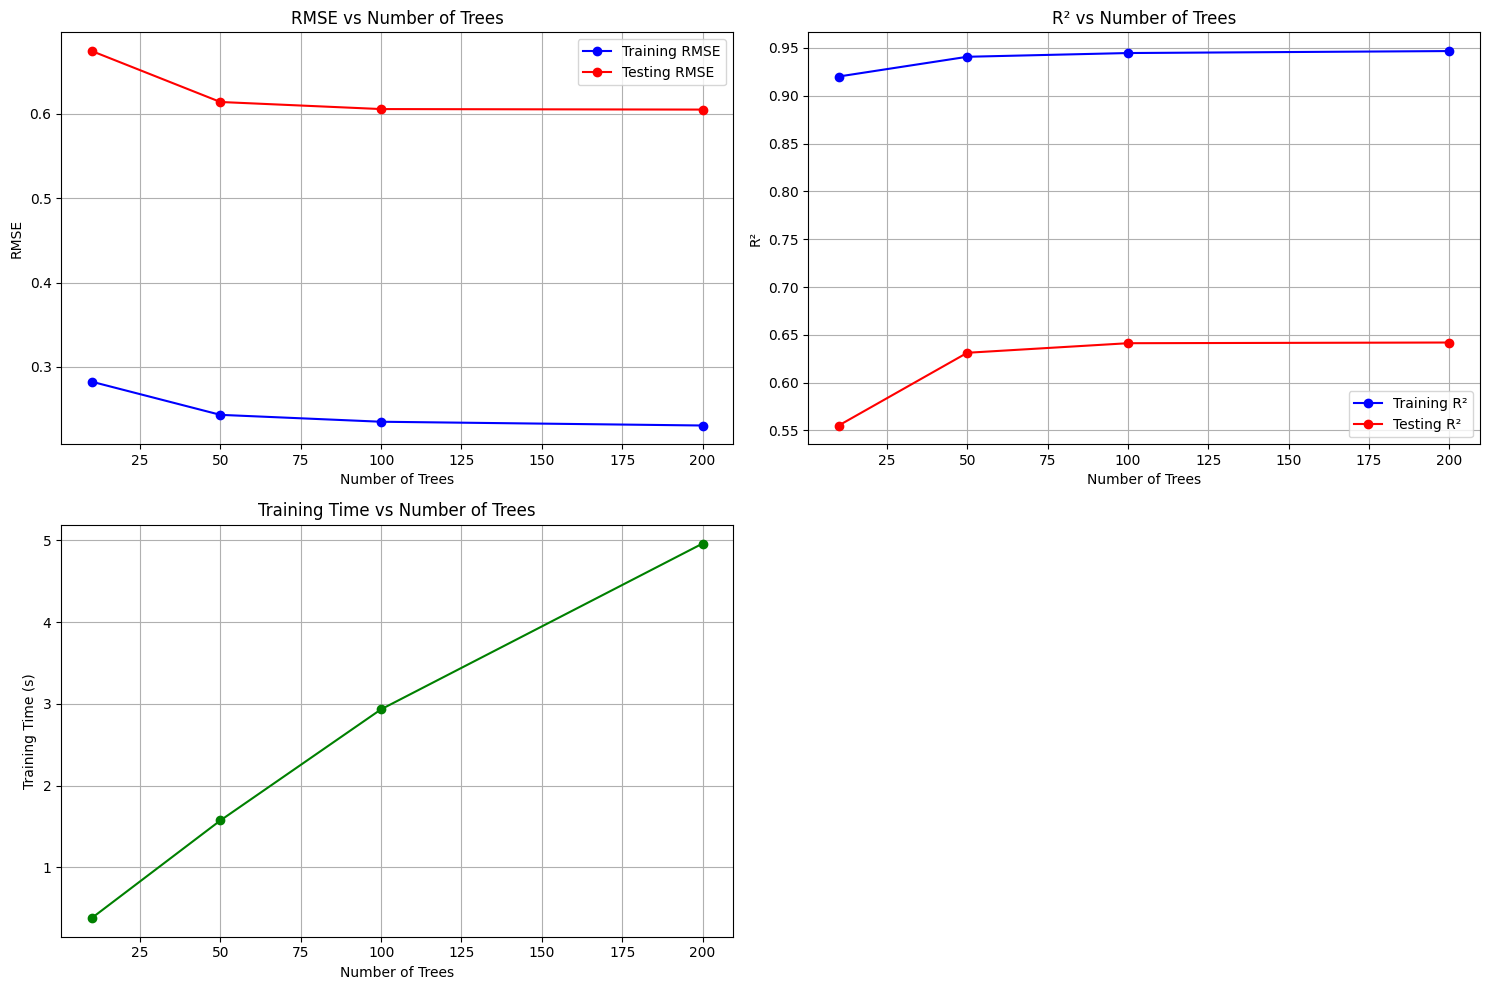


Performing hyperparameter tuning for V_16...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best RF Model - Training R²: 0.9447, RMSE: 0.2352
Best RF Model - Testing R²: 0.6412, RMSE: 0.6056

Analyzing feature importance...


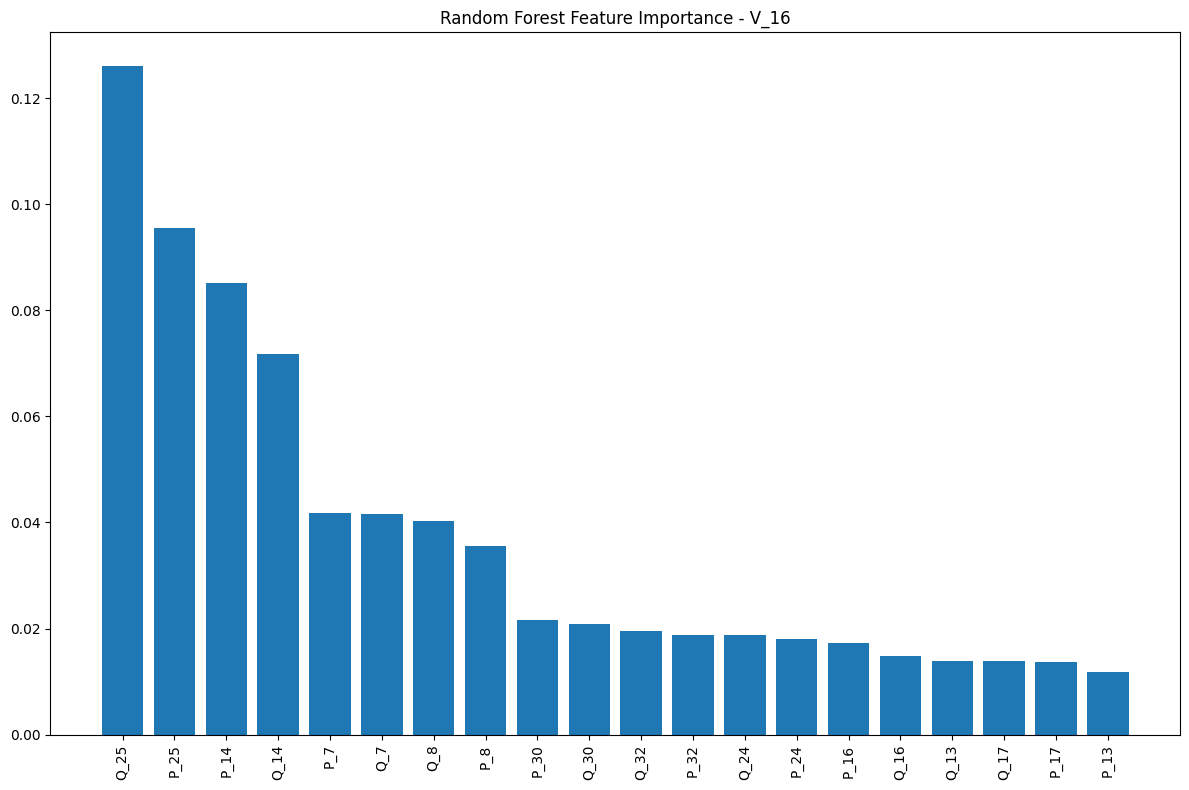

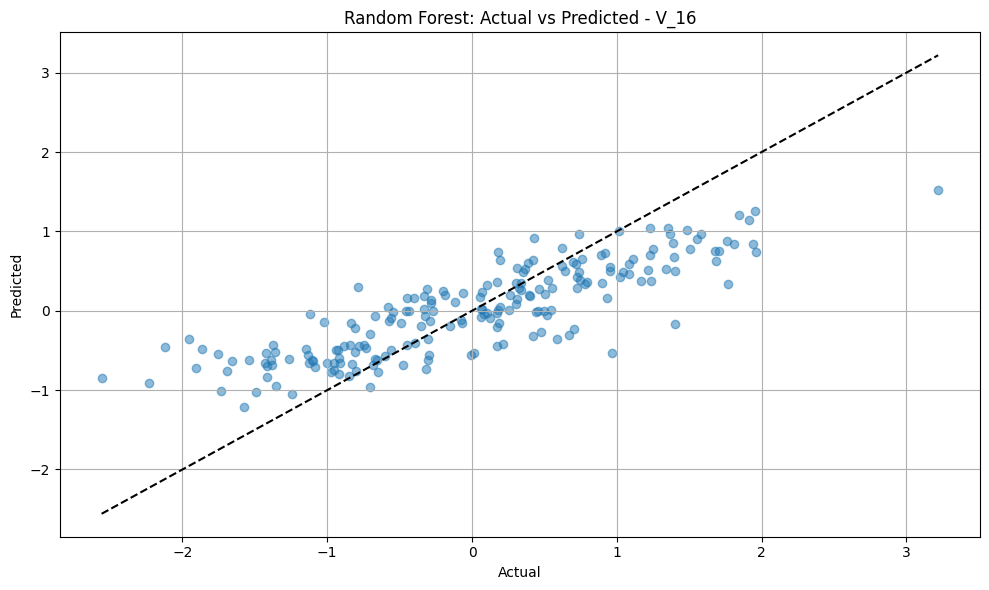


Generating learning curves...


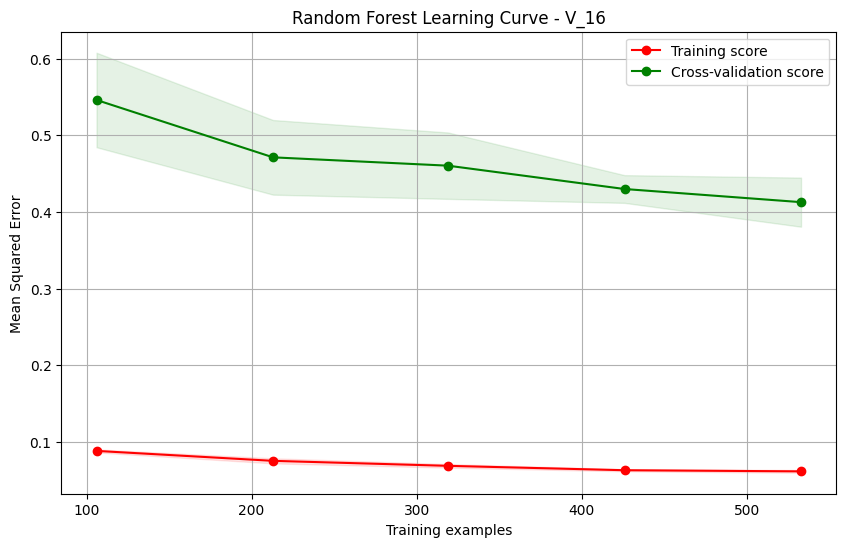

In [41]:
print("\n1. Training Random Forest for single voltage prediction (V_16)...")
rf_v16_results = train_rf_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training Random Forest for loss prediction...

Training base Random Forest model for loss...
Base RF Model - Training R²: 0.9491, RMSE: 0.2256
Base RF Model - Testing R²: 0.6814, RMSE: 0.5610

Performing sensitivity analysis on number of trees...
Training with 10 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...


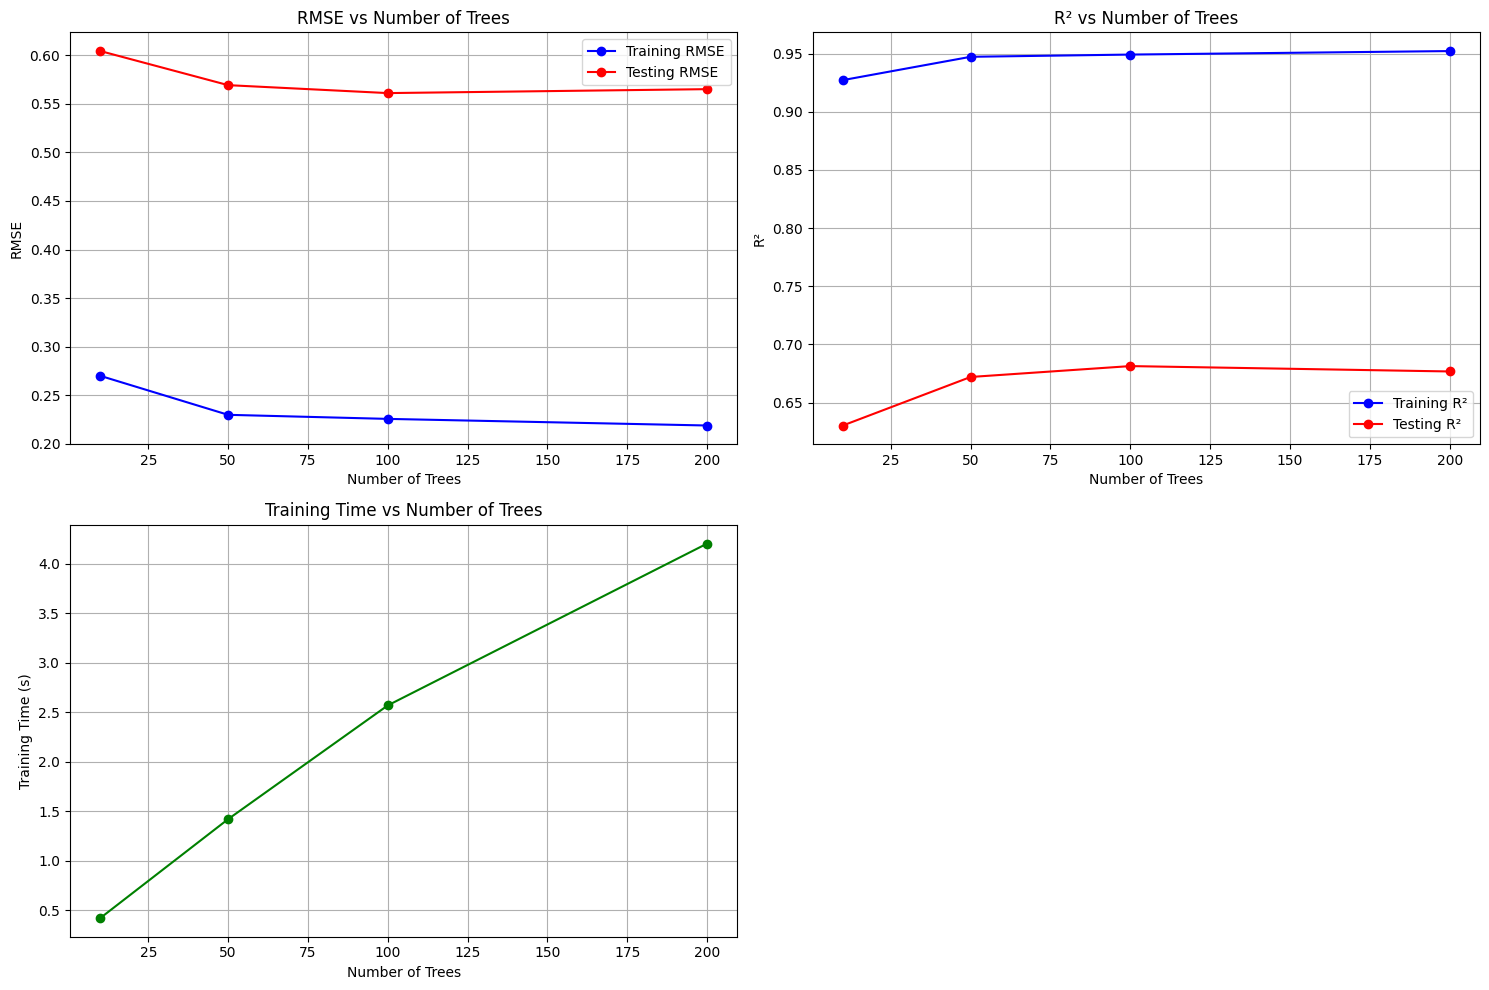


Performing hyperparameter tuning for loss...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best RF Model - Training R²: 0.9394, RMSE: 0.2462
Best RF Model - Testing R²: 0.6784, RMSE: 0.5637

Analyzing feature importance...


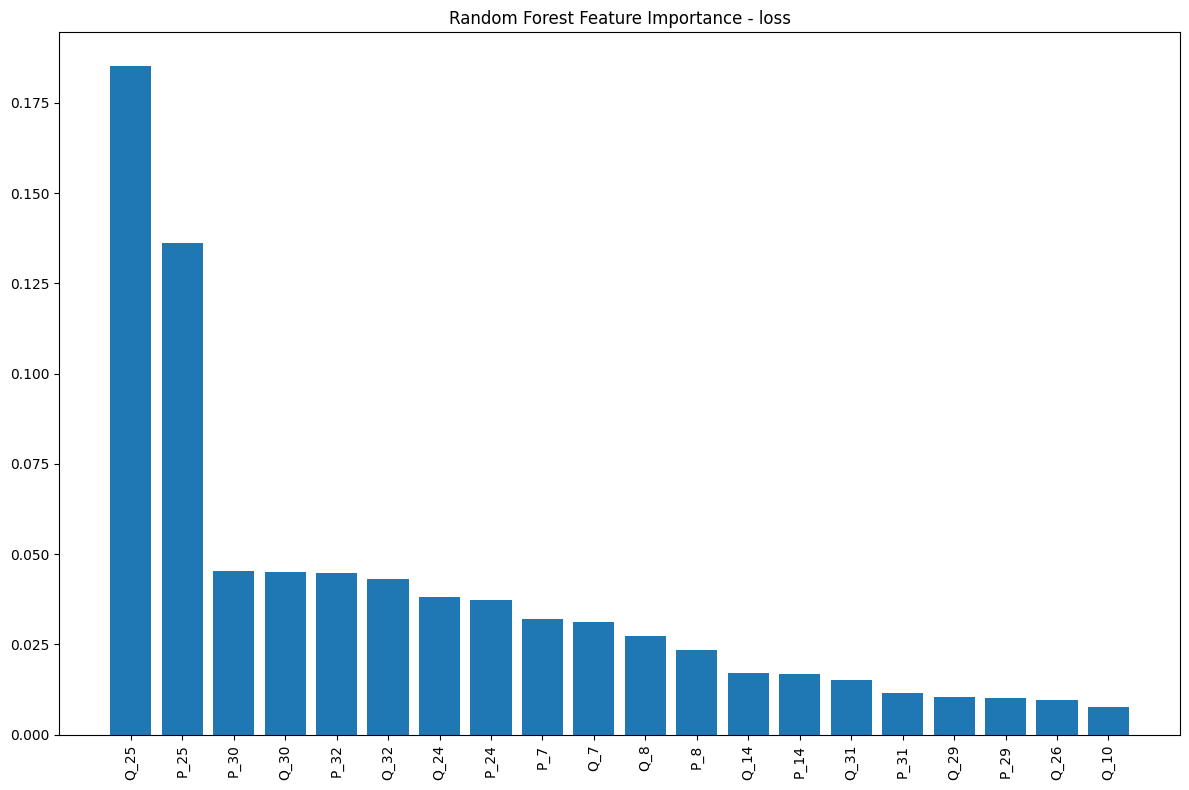

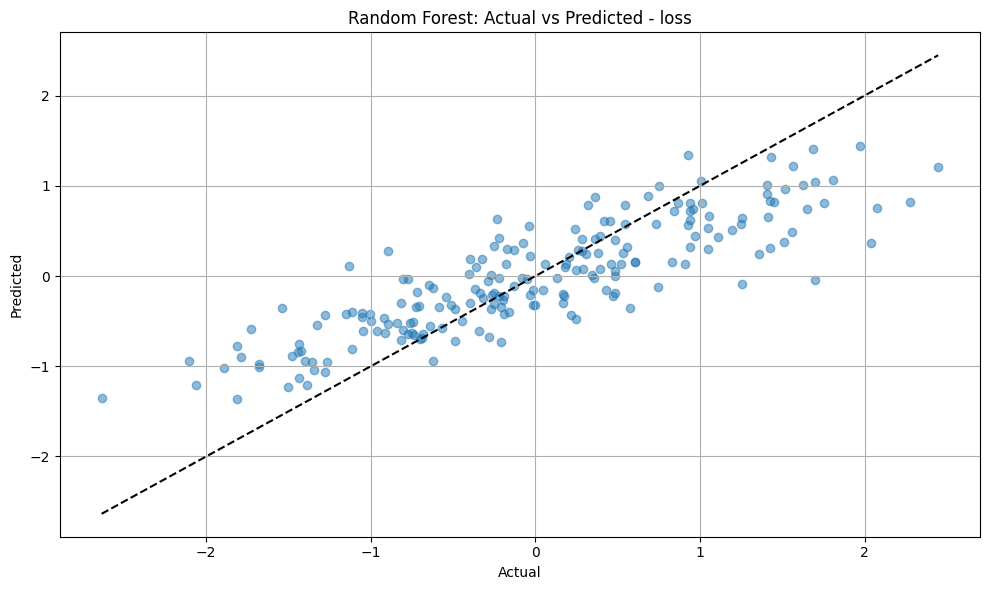


Generating learning curves...


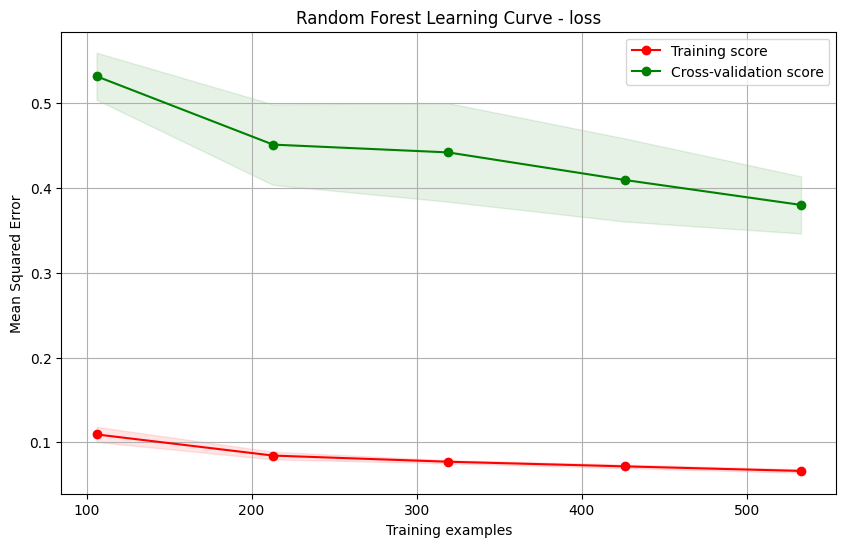

In [42]:
print("\n2. Training Random Forest for loss prediction...")
rf_loss_results = train_rf_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training Random Forest for all voltages prediction...

Training base Random Forest model for all_voltages...
Base RF Model - Training R²: 0.9452, RMSE: 0.2341
Base RF Model - Testing R²: 0.6569, RMSE: 0.5864

Performing sensitivity analysis on number of trees...
Training with 10 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...


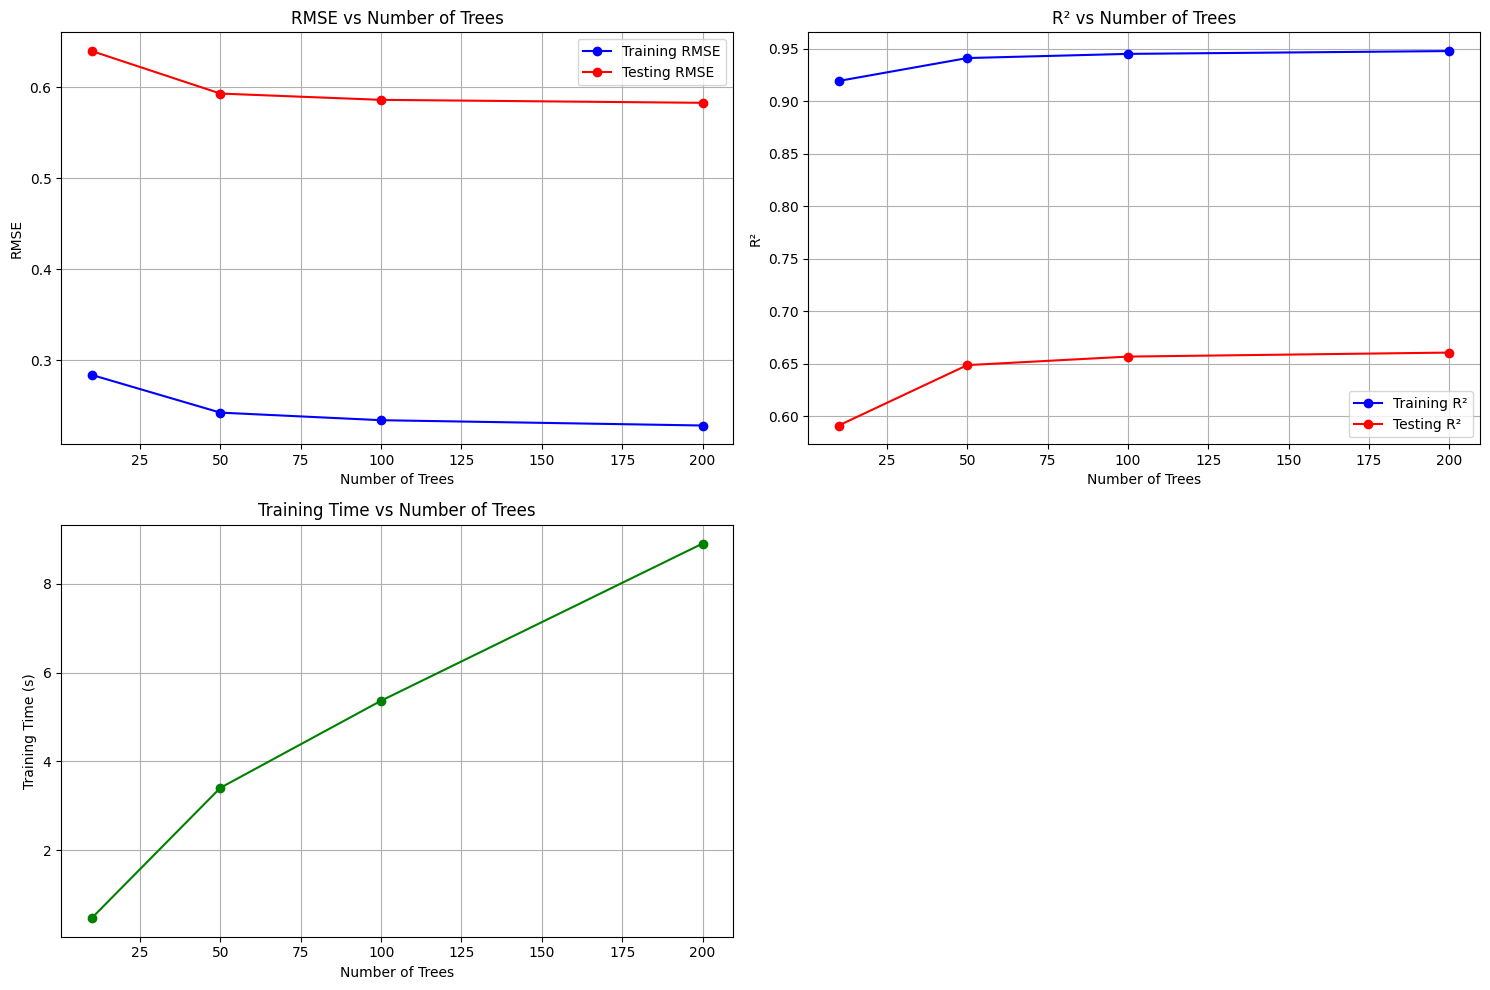


Performing hyperparameter tuning for all_voltages...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_depth': None, 'n_estimators': 100}
Best RF Model - Training R²: 0.9452, RMSE: 0.2341
Best RF Model - Testing R²: 0.6569, RMSE: 0.5864


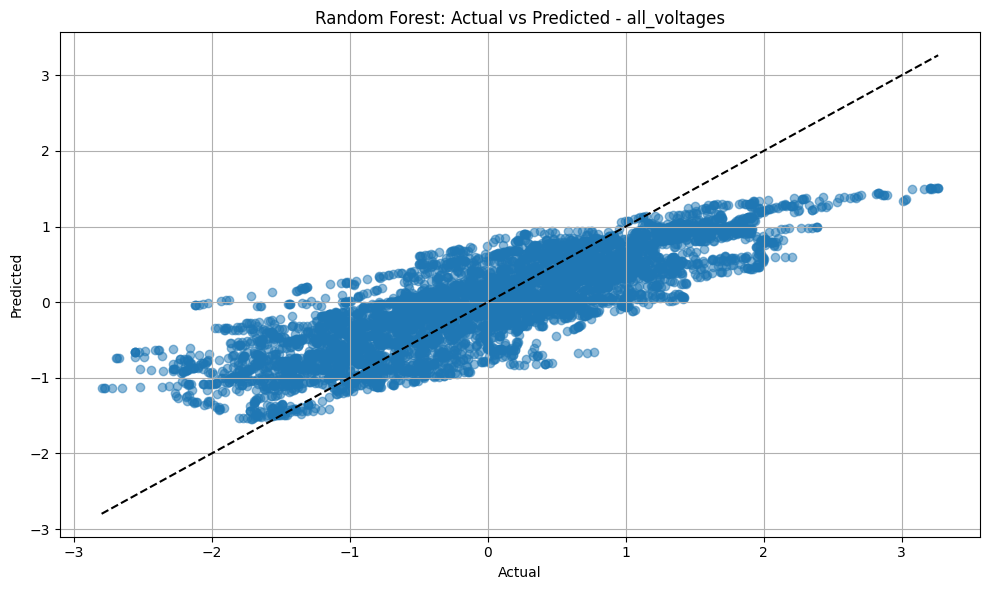


Generating learning curves...


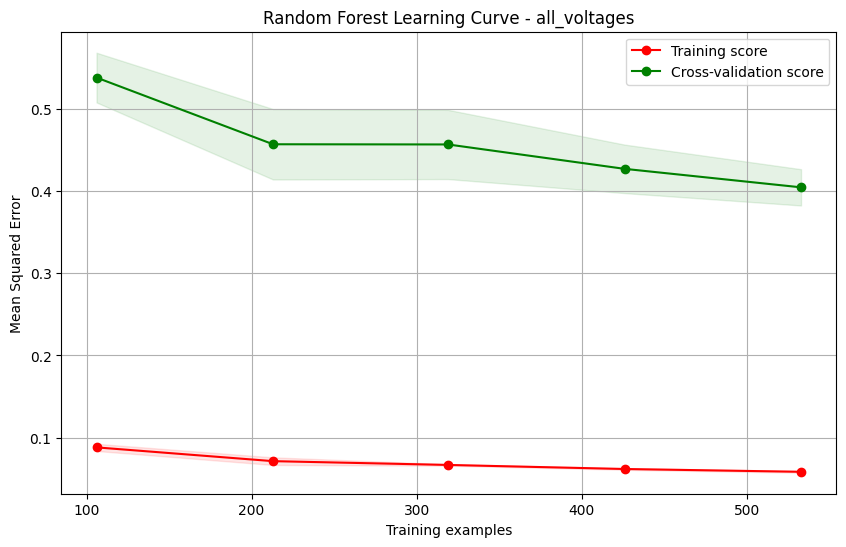

In [43]:
print("\n3. Training Random Forest for all voltages prediction...")
rf_all_v_results = train_rf_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [44]:
# Save the trained models
print("\nSaving trained Random Forest models...")
os.makedirs('models/random_forest', exist_ok=True)

with open('models/random_forest/rf_v16_best_model.pkl', 'wb') as f:
    pickle.dump(rf_v16_results['best_model']['model'], f)

with open('models/random_forest/rf_loss_best_model.pkl', 'wb') as f:
    pickle.dump(rf_loss_results['best_model']['model'], f)

with open('models/random_forest/rf_all_v_best_model.pkl', 'wb') as f:
    pickle.dump(rf_all_v_results['best_model']['model'], f)

print("Random Forest models saved successfully!")


Saving trained Random Forest models...
Random Forest models saved successfully!


In [45]:
print("\n=== Random Forest Models Summary ===")
print(f"V_16 Prediction - Test R²: {rf_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {rf_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {rf_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {rf_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {rf_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {rf_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")



=== Random Forest Models Summary ===
V_16 Prediction - Test R²: 0.6412, RMSE: 0.6056
Loss Prediction - Test R²: 0.6784, RMSE: 0.5637
All Voltages Prediction - Test R²: 0.6569, RMSE: 0.5864


### fuzzy logic

In [ ]:
def build_fuzzy_voltage_model(input_range, output_range, n_mf=3):
    """
    Build a fuzzy logic system for voltage prediction
    
    Parameters:
    input_range: Dictionary with input variable names and their ranges
    output_range: Dictionary with output variable names and their ranges
    n_mf: Number of membership functions for each variable
    
    Returns:
    Fuzzy control system simulator
    """
    # Create fuzzy variables
    input_vars = {}
    for var_name, var_range in input_range.items():
        input_vars[var_name] = ctrl.Antecedent(np.linspace(var_range[0], var_range[1], 100), var_name)
    
    output_vars = {}
    for var_name, var_range in output_range.items():
        output_vars[var_name] = ctrl.Consequent(np.linspace(var_range[0], var_range[1], 100), var_name)
    
    # Auto-generate membership functions
    for var in list(input_vars.values()) + list(output_vars.values()):
        if n_mf == 3:
            var.automf(names=['low', 'medium', 'high'])
        elif n_mf == 5:
            var.automf(names=['very_low', 'low', 'medium', 'high', 'very_high'])
        else:
            raise ValueError("n_mf must be 3 or 5")
    
    # Create rules based on domain knowledge of power systems
    rules = []
    
    # For demonstration, we'll create rules for a typical load-voltage relationship in a power system
    # In a real system, rules should be defined by power system experts
    # These rules encode the knowledge that:
    # 1. Higher loads generally lead to lower voltages
    # 2. The relationship follows power flow equations
    
    # Get list of input and output variable objects
    input_var_list = list(input_vars.values())
    output_var_list = list(output_vars.values())
    
    # Create rules based on power system knowledge
    if len(input_var_list) == 1 and len(output_var_list) == 1:
        # Simplest case: one input, one output
        input_var = input_var_list[0]
        output_var = output_var_list[0]
        
        if n_mf == 3:
            # Rule 1: If load is low, voltage is high
            rules.append(ctrl.Rule(input_var['low'], output_var['high']))
            # Rule 2: If load is medium, voltage is medium
            rules.append(ctrl.Rule(input_var['medium'], output_var['medium']))
            # Rule 3: If load is high, voltage is low
            rules.append(ctrl.Rule(input_var['high'], output_var['low']))
        elif n_mf == 5:
            # More detailed rules for 5 membership functions
            rules.append(ctrl.Rule(input_var['very_low'], output_var['very_high']))
            rules.append(ctrl.Rule(input_var['low'], output_var['high']))
            rules.append(ctrl.Rule(input_var['medium'], output_var['medium']))
            rules.append(ctrl.Rule(input_var['high'], output_var['low']))
            rules.append(ctrl.Rule(input_var['very_high'], output_var['very_low']))
    else:
        # Multiple inputs and/or outputs case
        # This requires more complex rule formulation
        # For demonstration, we'll create a simplified rule set
        # Real implementation would need detailed power system expertise
        
        # Example rules for two inputs (e.g., active and reactive load) and one output (voltage)
        if len(input_var_list) >= 2 and len(output_var_list) == 1:
            input_var1 = input_var_list[0]  # Active power
            input_var2 = input_var_list[1]  # Reactive power
            output_var = output_var_list[0]  # Voltage
            
            if n_mf == 3:
                # Rule set considering combined effect of active and reactive power on voltage
                # Low active and reactive power -> High voltage
                rules.append(ctrl.Rule(input_var1['low'] & input_var2['low'], output_var['high']))
                # High active and reactive power -> Low voltage
                rules.append(ctrl.Rule(input_var1['high'] & input_var2['high'], output_var['low']))
                # Other combinations with medium effect
                rules.append(ctrl.Rule(input_var1['low'] & input_var2['medium'], output_var['medium']))
                rules.append(ctrl.Rule(input_var1['medium'] & input_var2['low'], output_var['medium']))
                rules.append(ctrl.Rule(input_var1['medium'] & input_var2['medium'], output_var['medium']))
                rules.append(ctrl.Rule(input_var1['high'] & input_var2['medium'], output_var['low']))
                rules.append(ctrl.Rule(input_var1['medium'] & input_var2['high'], output_var['low']))
                # Reactive power has stronger effect on voltage
                rules.append(ctrl.Rule(input_var1['low'] & input_var2['high'], output_var['low']))
                rules.append(ctrl.Rule(input_var1['high'] & input_var2['low'], output_var['medium']))
    
    # Create control system
    system = ctrl.ControlSystem(rules)
    simulator = ctrl.ControlSystemSimulation(system)
    
    return simulator, input_vars, output_vars

def create_fuzzy_model_for_node(node_data, feature_columns, target_column, n_membership_functions=3):
    """
    Create a fuzzy model for a specific node in the IEEE 33 bus system
    
    Parameters:
    node_data: DataFrame with data for this node
    feature_columns: List of input feature columns (loads)
    target_column: Target column (voltage or losses)
    n_membership_functions: Number of membership functions to use
    
    Returns:
    Fuzzy model simulator
    """
    # Define input and output ranges from data
    input_range = {}
    for col in feature_columns:
        input_range[col] = [node_data[col].min(), node_data[col].max()]
    
    output_range = {
        target_column: [node_data[target_column].min(), node_data[target_column].max()]
    }
    
    # Create fuzzy model
    simulator, input_vars, output_vars = build_fuzzy_voltage_model(
        input_range, output_range, n_mf=n_membership_functions
    )
    
    return simulator, input_vars, output_vars

def evaluate_fuzzy_model(simulator, X_test, y_test, input_vars, metric_func=None):
    """
    Evaluate fuzzy model on test data
    
    Parameters:
    simulator: Fuzzy control system simulator
    X_test: Test input data
    y_test: Test output data
    input_vars: Dictionary of input fuzzy variables
    metric_func: Function to calculate evaluation metrics
    
    Returns:
    Predictions and metrics
    """
    predictions = []
    
    # Make predictions for each test sample
    for i in range(len(X_test)):
        # Set inputs
        for var_name in input_vars.keys():
            simulator.input[var_name] = X_test[var_name].iloc[i]
        
        # Compute output
        simulator.compute()
        
        # Get the output for the first (and likely only) output variable
        output_var_name = list(simulator.output.keys())[0]
        predictions.append(simulator.output[output_var_name])
    
    # Convert to numpy array
    predictions = np.array(predictions)
    
    # Calculate metrics if a metric function is provided
    metrics = None
    if metric_func is not None:
        metrics = metric_func(y_test, predictions)
    
    return predictions, metrics

def plot_fuzzy_memberships(input_vars, output_vars, filename_prefix):
    """
    Plot membership functions for all fuzzy variables
    
    Parameters:
    input_vars: Dictionary of input fuzzy variables
    output_vars: Dictionary of output fuzzy variables
    filename_prefix: Prefix for saved plot files
    """
    # Plot input variables
    for var_name, var in input_vars.items():
        plt.figure(figsize=(10, 6))
        var.view()
        plt.title(f"Membership Functions for {var_name}")
        plt.tight_layout()
        plt.savefig(f'figures/fuzzy_{filename_prefix}_{var_name}_membership.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    # Plot output variables
    for var_name, var in output_vars.items():
        plt.figure(figsize=(10, 6))
        var.view()
        plt.title(f"Membership Functions for {var_name}")
        plt.tight_layout()
        plt.savefig(f'figures/fuzzy_{filename_prefix}_{var_name}_membership.png', dpi=300, bbox_inches='tight')
        plt.close()

def run_fuzzy_model(df, target_columns, feature_columns=None, test_size=0.2, random_state=42, n_membership_functions=3):
    """
    Run the fuzzy logic model workflow for IEEE 33 bus system
    
    Parameters:
    df: DataFrame containing the dataset
    target_columns: List of target column names (voltages, losses)
    feature_columns: List of feature column names (loads), if None, uses all columns except targets
    test_size: Fraction of data to use for testing
    random_state: Random seed for reproducibility
    n_membership_functions: Number of membership functions for fuzzy variables
    
    Returns:
    Dictionary with results for each target
    """
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_squared_error, r2_score
    
    # Create a copy of the dataframe
    data = df.copy()
    
    # Handle feature columns
    if feature_columns is None:
        feature_columns = [col for col in data.columns if col not in target_columns]
    
    # Define metrics function
    def regression_metrics(y_true, y_pred):
        metrics = {}
        metrics['MSE'] = mean_squared_error(y_true, y_pred)
        metrics['RMSE'] = np.sqrt(metrics['MSE'])
        metrics['MAE'] = np.mean(np.abs(y_true - y_pred))
        metrics['R2'] = r2_score(y_true, y_pred)
        return metrics
    
    # Dictionary to store results for each target
    all_results = {}
    
    # Process each target
    for target_col in target_columns:
        print(f"\n\n{'='*50}")
        print(f"Processing target: {target_col}")
        print(f"{'='*50}")
        
        # For fuzzy models, we'll limit the number of input features for simplicity
        # In practice, feature selection should be done based on domain knowledge
        if len(feature_columns) > 2:
            print("Limiting to 2 most important features for fuzzy model...")
            # Simple correlation-based feature selection
            correlations = data[feature_columns].corrwith(data[target_col])
            abs_corr = correlations.abs()
            selected_features = abs_corr.nlargest(2).index.tolist()
            print(f"Selected features: {selected_features}")
        else:
            selected_features = feature_columns
        
        # Split data
        X = data[selected_features]
        y = data[target_col]
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Create and evaluate fuzzy model
        print("Creating fuzzy model...")
        start_time = time.time()
        simulator, input_vars, output_vars = create_fuzzy_model_for_node(
            pd.concat([X_train, y_train], axis=1),
            selected_features,
            target_col,
            n_membership_functions
        )
        
        # Plot membership functions
        print("Plotting membership functions...")
        plot_fuzzy_memberships(input_vars, output_vars, f"{target_col}")
        
        # Evaluate model
        print("Evaluating model on test data...")
        predictions, metrics = evaluate_fuzzy_model(
            simulator, X_test, y_test, input_vars, regression_metrics
        )
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Test RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")
        
        # Plot actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, predictions, alpha=0.6)
        
        # Add perfect prediction line
        min_val = min(y_test.min(), min(predictions))
        max_val = max(y_test.max(), max(predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.title(f'Fuzzy Logic Model: Actual vs Predicted - {target_col}')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'figures/fuzzy_{target_col}_predictions.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # Store results
        all_results[target_col] = {
            'simulator': simulator,
            'input_vars': input_vars,
            'output_vars': output_vars,
            'predictions': predictions,
            'metrics': metrics,
            'training_time': training_time,
            'selected_features': selected_features
        }
        
        # Conduct sensitivity analysis on number of membership functions if time permits
        if target_col == target_columns[0]:  # Only for first target to save time
            print("\nPerforming sensitivity analysis on number of membership functions...")
            
            mf_options = [3, 5]
            sensitivity_results = []
            
            for n_mf in mf_options:
                print(f"Testing with {n_mf} membership functions...")
                start_time = time.time()
                
                # Create and evaluate model
                simulator_mf, input_vars_mf, output_vars_mf = create_fuzzy_model_for_node(
                    pd.concat([X_train, y_train], axis=1),
                    selected_features,
                    target_col,
                    n_mf
                )
                
                predictions_mf, metrics_mf = evaluate_fuzzy_model(
                    simulator_mf, X_test, y_test, input_vars_mf, regression_metrics
                )
                
                training_time_mf = time.time() - start_time
                
                sensitivity_results.append({
                    'n_mf': n_mf,
                    'rmse': metrics_mf['RMSE'],
                    'r2': metrics_mf['R2'],
                    'training_time': training_time_mf
                })
            
            # Plot sensitivity results
            plt.figure(figsize=(12, 5))
            
            # Left: RMSE
            plt.subplot(1, 2, 1)
            plt.bar([str(r['n_mf']) for r in sensitivity_results], 
                   [r['rmse'] for r in sensitivity_results])
            plt.title('RMSE vs Number of Membership Functions')
            plt.xlabel('Number of Membership Functions')
            plt.ylabel('RMSE')
            plt.grid(True, axis='y')
            
            # Right: R²
            plt.subplot(1, 2, 2)
            plt.bar([str(r['n_mf']) for r in sensitivity_results], 
                   [r['r2'] for r in sensitivity_results])
            plt.title('R² vs Number of Membership Functions')
            plt.xlabel('Number of Membership Functions')
            plt.ylabel('R²')
            plt.grid(True, axis='y')
            
            plt.tight_layout()
            plt.savefig(f'figures/fuzzy_{target_col}_mf_sensitivity.png', dpi=300, bbox_inches='tight')
            plt.close()
            
            # Store sensitivity results
            all_results[target_col]['mf_sensitivity'] = sensitivity_results
    
    return all_results

### KNN

In [ ]:
def train_knn_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    # Training convergence tracking
    train_errors = []
    val_errors = []
    
    # 1. Base model for quick evaluation
    print(f"\nTraining base KNN model for {target_name}...")
    knn_model = KNeighborsRegressor(n_neighbors=5)
    
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        knn_model.fit(X_train, y_train)
    else:
        knn_model.fit(X_train, y_train.ravel())
    
    y_train_pred = knn_model.predict(X_train)
    y_test_pred = knn_model.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        y_train_pred = y_train_pred.reshape(-1, 1)
        y_test_pred = y_test_pred.reshape(-1, 1)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base KNN Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base KNN Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': knn_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred
    }
    
    # 2. Sensitivity Analysis: Vary number of neighbors
    print(f"\nPerforming sensitivity analysis on number of neighbors...")
    n_neighbors_list = [1, 3, 5, 7, 10, 15, 20, 30, 50]
    neighbors_results = []
    
    for n_neighbors in n_neighbors_list:
        print(f"Training with {n_neighbors} neighbors...")
        start_time = time.time()
        
        knn = KNeighborsRegressor(n_neighbors=n_neighbors)
        
        if len(y_train.shape) > 1 and y_train.shape[1] > 1:
            knn.fit(X_train, y_train)
        else:
            knn.fit(X_train, y_train.ravel())
        
        train_pred = knn.predict(X_train)
        test_pred = knn.predict(X_test)
        
        if len(y_train.shape) == 2 and y_train.shape[1] == 1:
            train_pred = train_pred.reshape(-1, 1)
            test_pred = test_pred.reshape(-1, 1)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        
        neighbors_results.append({
            'n_neighbors': n_neighbors,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time
        })
        
        train_errors.append(train_rmse)
        val_errors.append(test_rmse)
    
    # Plot sensitivity analysis results
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs number of neighbors
    plt.subplot(2, 2, 1)
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['train_rmse'] for r in neighbors_results], 'b-o', label='Training RMSE')
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['test_rmse'] for r in neighbors_results], 'r-o', label='Testing RMSE')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Number of Neighbors')
    plt.legend()
    plt.grid(True)
    
    # Plot R² vs number of neighbors
    plt.subplot(2, 2, 2)
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['train_r2'] for r in neighbors_results], 'b-o', label='Training R²')
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['test_r2'] for r in neighbors_results], 'r-o', label='Testing R²')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('R²')
    plt.title('R² vs Number of Neighbors')
    plt.legend()
    plt.grid(True)
    
    # Plot training time vs number of neighbors
    plt.subplot(2, 2, 3)
    plt.plot([r['n_neighbors'] for r in neighbors_results], [r['training_time'] for r in neighbors_results], 'g-o')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Number of Neighbors')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/knn_{target_name}_neighbors_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Store sensitivity analysis results
    results['neighbors_sensitivity'] = neighbors_results
    
    # 3. Hyperparameter tuning with GridSearchCV
    print(f"\nPerforming hyperparameter tuning for {target_name}...")
    
    # Find optimal n_neighbors from sensitivity analysis
    optimal_n_neighbors = min(neighbors_results, key=lambda x: x['test_rmse'])['n_neighbors']
    print(f"Optimal number of neighbors from sensitivity analysis: {optimal_n_neighbors}")
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [optimal_n_neighbors-2, optimal_n_neighbors, optimal_n_neighbors+2],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'p': [1, 2]  # 1 for manhattan_distance, 2 for euclidean_distance
    }
    
    # If the target is multi-dimensional, use a simpler grid to save time
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        param_grid = {
            'n_neighbors': [optimal_n_neighbors],
            'weights': ['uniform', 'distance'],
            'p': [2]
        }
    
    # Create grid search object
    knn_grid = GridSearchCV(
        KNeighborsRegressor(),
        param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        knn_grid.fit(X_train, y_train)
    else:
        knn_grid.fit(X_train, y_train.ravel())
    
    # Get best model
    best_knn = knn_grid.best_estimator_
    best_params = knn_grid.best_params_
    
    print(f"Best parameters: {best_params}")
    
    # Generate predictions with best model
    best_train_pred = best_knn.predict(X_train)
    best_test_pred = best_knn.predict(X_test)
    
    if len(y_train.shape) == 2 and y_train.shape[1] == 1:
        best_train_pred = best_train_pred.reshape(-1, 1)
        best_test_pred = best_test_pred.reshape(-1, 1)
    
    # Calculate metrics for best model
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best KNN Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best KNN Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    # Store best model results
    results['best_model'] = {
        'model': best_knn,
        'params': best_params,
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred
    }
    
    # 5. Plot actual vs predicted values for testing data
    plot_actual_vs_predicted(y_test, best_test_pred, 
                           f'KNN: Actual vs Predicted - {target_name}',
                           f'knn_{target_name}_actual_vs_predicted')
    
    # 6. Learning curve to analyze model bias-variance tradeoff
    print("\nGenerating learning curves...")
    
    train_sizes, train_scores, test_scores = learning_curve(
        best_knn, X_train, y_train.ravel() if len(y_train.shape) == 2 and y_train.shape[1] == 1 else y_train,
        cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Squared Error")
    plt.title(f"KNN Learning Curve - {target_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'figures/knn_{target_name}_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Store the learning curve data
    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_scores_mean': train_scores_mean,
        'train_scores_std': train_scores_std,
        'test_scores_mean': test_scores_mean,
        'test_scores_std': test_scores_std
    }
    
    # Save all results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/knn_{target_name}_metrics.csv', index=False)
    
    return results

In [48]:
print("\n1. Training KNN for single voltage prediction (V_16)...")
knn_v16_results = train_knn_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


1. Training KNN for single voltage prediction (V_16)...

Training base KNN model for V_16...
Base KNN Model - Training R²: 0.6912, RMSE: 0.5557
Base KNN Model - Testing R²: 0.5384, RMSE: 0.6869

Performing sensitivity analysis on number of neighbors...
Training with 1 neighbors...
Training with 3 neighbors...
Training with 5 neighbors...
Training with 7 neighbors...
Training with 10 neighbors...
Training with 15 neighbors...
Training with 20 neighbors...
Training with 30 neighbors...
Training with 50 neighbors...

Performing hyperparameter tuning for V_16...
Optimal number of neighbors from sensitivity analysis: 10
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Best KNN Model - Training R²: 1.0000, RMSE: 0.0000
Best KNN Model - Testing R²: 0.5658, RMSE: 0.6662

Generating learning curves...


In [49]:
print("\n2. Training KNN for loss prediction...")
knn_loss_results = train_knn_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


2. Training KNN for loss prediction...

Training base KNN model for loss...
Base KNN Model - Training R²: 0.6978, RMSE: 0.5497
Base KNN Model - Testing R²: 0.5522, RMSE: 0.6652

Performing sensitivity analysis on number of neighbors...
Training with 1 neighbors...
Training with 3 neighbors...
Training with 5 neighbors...
Training with 7 neighbors...
Training with 10 neighbors...
Training with 15 neighbors...
Training with 20 neighbors...
Training with 30 neighbors...
Training with 50 neighbors...

Performing hyperparameter tuning for loss...
Optimal number of neighbors from sensitivity analysis: 10
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'algorithm': 'auto', 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Best KNN Model - Training R²: 1.0000, RMSE: 0.0000
Best KNN Model - Testing R²: 0.5865, RMSE: 0.6392

Generating learning curves...


In [50]:
print("\n3. Training KNN for all voltages prediction...")
knn_all_v_results = train_knn_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)


3. Training KNN for all voltages prediction...

Training base KNN model for all_voltages...
Base KNN Model - Training R²: 0.6948, RMSE: 0.5525
Base KNN Model - Testing R²: 0.5481, RMSE: 0.6727

Performing sensitivity analysis on number of neighbors...
Training with 1 neighbors...
Training with 3 neighbors...
Training with 5 neighbors...
Training with 7 neighbors...
Training with 10 neighbors...
Training with 15 neighbors...
Training with 20 neighbors...
Training with 30 neighbors...
Training with 50 neighbors...

Performing hyperparameter tuning for all_voltages...
Optimal number of neighbors from sensitivity analysis: 10
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best KNN Model - Training R²: 1.0000, RMSE: 0.0000
Best KNN Model - Testing R²: 0.5919, RMSE: 0.6393

Generating learning curves...


In [51]:
print("\nSaving trained KNN models...")
os.makedirs('models/knn', exist_ok=True)

with open('models/knn/knn_v16_best_model.pkl', 'wb') as f:
    pickle.dump(knn_v16_results['best_model']['model'], f)

with open('models/knn/knn_loss_best_model.pkl', 'wb') as f:
    pickle.dump(knn_loss_results['best_model']['model'], f)

with open('models/knn/knn_all_v_best_model.pkl', 'wb') as f:
    pickle.dump(knn_all_v_results['best_model']['model'], f)

print("KNN models saved successfully!")


Saving trained KNN models...
KNN models saved successfully!


In [52]:
print("\n=== KNN Models Summary ===")
print(f"V_16 Prediction - Test R²: {knn_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {knn_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {knn_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {knn_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {knn_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {knn_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")


=== KNN Models Summary ===
V_16 Prediction - Test R²: 0.5658, RMSE: 0.6662
Loss Prediction - Test R²: 0.5865, RMSE: 0.6392
All Voltages Prediction - Test R²: 0.5919, RMSE: 0.6393


### ANN

In [64]:
def train_ann_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    train_losses = []
    val_losses = []
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 1. Base model for quick evaluation
    print(f"\nTraining base ANN model for {target_name}...")
    
    output_dim = 1 if len(y_train.shape) == 1 or y_train.shape[1] == 1 else y_train.shape[1]
    
    base_model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])
    
    base_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Use early stopping for all models
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    class LossHistory(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            train_losses.append(logs.get('loss'))
            val_losses.append(logs.get('val_loss'))
    
    history_callback = LossHistory()
    
    base_history = base_model.fit(
        X_train_scaled, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, history_callback],
        verbose=1
    )
    
    y_train_pred = base_model.predict(X_train_scaled)
    y_test_pred = base_model.predict(X_test_scaled)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base ANN Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base ANN Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': base_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred,
        'history': base_history.history
    }
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(base_history.history['loss'], label='Training Loss')
    plt.plot(base_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'ANN Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(base_history.history['mae'], label='Training MAE')
    plt.plot(base_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'ANN Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann_{target_name}_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Sensitivity Analysis for ANN hyperparameters
    print(f"\nPerforming sensitivity analysis on network architecture...")
    
    architectures = [
        {'name': 'Small', 'layers': [32, 16]},
        {'name': 'Medium', 'layers': [64, 32]},
        {'name': 'Large', 'layers': [128, 64, 32]},
        {'name': 'Extra Large', 'layers': [256, 128, 64, 32]}
    ]
    
    architecture_results = []
    
    for arch in architectures:
        print(f"Training with {arch['name']} architecture: {arch['layers']}...")
        start_time = time.time()
        
        # Build model with this architecture
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(arch['layers'][0], activation='relu', input_shape=(X_train.shape[1],)))
        
        for units in arch['layers'][1:]:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        model.add(tf.keras.layers.Dense(output_dim))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_scaled, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        architecture_results.append({
            'name': arch['name'],
            'layers': arch['layers'],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs architecture
    plt.subplot(2, 2, 1)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_rmse'] for r in architecture_results], 
            alpha=0.6, label='Training RMSE')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_rmse'] for r in architecture_results], 
            alpha=0.6, label='Testing RMSE')
    plt.xlabel('Network Architecture')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Network Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot R² vs architecture
    plt.subplot(2, 2, 2)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_r2'] for r in architecture_results], 
            alpha=0.6, label='Training R²')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_r2'] for r in architecture_results], 
            alpha=0.6, label='Testing R²')
    plt.xlabel('Network Architecture')
    plt.ylabel('R²')
    plt.title('R² vs Network Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training time vs architecture
    plt.subplot(2, 2, 3)
    plt.bar([r['name'] for r in architecture_results], 
             [r['training_time'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Network Architecture')
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar([r['name'] for r in architecture_results], 
             [r['epochs'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs Network Architecture')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann_{target_name}_architecture_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['architecture_sensitivity'] = architecture_results
    
    # 3. Hyperparameter tuning
    print(f"\nPerforming learning rate and batch size tuning for {target_name}...")
    
    learning_rates = [0.001, 0.01, 0.0001]
    batch_sizes = [16, 32, 64]
    
    best_arch_idx = np.argmin([r['test_rmse'] for r in architecture_results])
    best_arch = architecture_results[best_arch_idx]['layers']
    
    hyperparameter_results = []
    
    for lr in learning_rates:
        for bs in batch_sizes:
            print(f"Training with learning rate={lr}, batch size={bs}...")
            start_time = time.time()
            
            # Build model with best architecture
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
            
            for units in best_arch[1:]:
                model.add(tf.keras.layers.Dense(units, activation='relu'))
            
            model.add(tf.keras.layers.Dense(output_dim))
            
            # Customize optimizer with learning rate
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
            
            # Train with early stopping
            history = model.fit(
                X_train_scaled, y_train,
                epochs=200,
                batch_size=bs,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            train_pred = model.predict(X_train_scaled)
            test_pred = model.predict(X_test_scaled)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            training_time = time.time() - start_time
            final_epochs = len(history.history['loss'])
            
            hyperparameter_results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'training_time': training_time,
                'epochs': final_epochs
            })
    
    best_hp_idx = np.argmin([r['test_rmse'] for r in hyperparameter_results])
    best_lr = hyperparameter_results[best_hp_idx]['learning_rate']
    best_bs = hyperparameter_results[best_hp_idx]['batch_size']
    
    print(f"Best hyperparameters: learning_rate={best_lr}, batch_size={best_bs}")
    
    plt.figure(figsize=(12, 10))
    
    hp_labels = [f"lr={r['learning_rate']}, bs={r['batch_size']}" for r in hyperparameter_results]
    
    # Plot test RMSE vs hyperparameters
    plt.subplot(2, 2, 1)
    plt.bar(hp_labels, [r['test_rmse'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot test R² vs hyperparameters
    plt.subplot(2, 2, 2)
    plt.bar(hp_labels, [r['test_r2'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test R²')
    plt.title('Test R² vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot training time
    plt.subplot(2, 2, 3)
    plt.bar(hp_labels, [r['training_time'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar(hp_labels, [r['epochs'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann_{target_name}_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['hyperparameter_tuning'] = hyperparameter_results
    
    # 4. Train best model with optimal settings
    print(f"\nTraining final ANN model with best parameters...")
    
    best_model = tf.keras.Sequential()
    best_model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
    
    for units in best_arch[1:]:
        best_model.add(tf.keras.layers.Dense(units, activation='relu'))
    
    best_model.add(tf.keras.layers.Dense(output_dim))
    
    # Create tensorboard callback
    tensorboard_dir = f"logs/ann_{target_name}_{int(time.time())}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
    best_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    best_history = best_model.fit(
        X_train_scaled, y_train,
        epochs=300,
        batch_size=best_bs,
        validation_split=0.2,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )
    
    best_train_pred = best_model.predict(X_train_scaled)
    best_test_pred = best_model.predict(X_test_scaled)
    
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best ANN Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best ANN Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_model,
        'scaler': scaler,
        'params': {
            'learning_rate': best_lr,
            'batch_size': best_bs,
            'architecture': best_arch
        },
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred,
        'history': best_history.history
    }
    
    # Plot final model training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Best ANN Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['mae'], label='Training MAE')
    plt.plot(best_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Best ANN Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/ann_{target_name}_best_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 5. Feature sensitivity analysis (similar to feature importance in RF)
    if len(y_train.shape) == 1 or y_train.shape[1] == 1:
        print("\nAnalyzing feature sensitivity...")
        
        feature_sensitivity_model = tf.keras.Sequential()
        feature_sensitivity_model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
        
        for units in best_arch[1:]:
            feature_sensitivity_model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        feature_sensitivity_model.add(tf.keras.layers.Dense(output_dim))
        
        feature_sensitivity_model.compile(optimizer=optimizer, loss='mse')
        
        # Load weights from the best model
        feature_sensitivity_model.set_weights(best_model.get_weights())
        
        # Calculate feature sensitivity using permutation importance
        perm_importance = permutation_importance(
            feature_sensitivity_model,
            X_test_scaled,
            y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1,
            scoring='r2'
        )
        
        importances = perm_importance.importances_mean
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1]
        plt.title(f'ANN Feature Sensitivity - {target_name}')
        plt.bar(range(min(20, len(feature_names))), importances[indices][:min(20, len(feature_names))], align='center')
        plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices][:min(20, len(feature_names))], rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/ann_{target_name}_feature_sensitivity.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store top 10 important features
        top_features = [(feature_names[idx], importances[idx]) for idx in indices[:10]]
        results['feature_sensitivity'] = {
            'importances': importances,
            'top_features': top_features
        }
    
    # 6. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'ANN: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/ann_{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 7. Learning curve for ANN
    print("\nGenerating learning curves based on training data size...")
    
    train_sizes = np.linspace(0.2, 1.0, 5)
    train_errors = []
    val_errors = []
    
    def train_with_subset(subset_ratio):
        subset_size = int(X_train_scaled.shape[0] * subset_ratio)
        X_subset = X_train_scaled[:subset_size]
        y_subset = y_train[:subset_size]
        
        val_split = 0.2
        val_size = int(subset_size * val_split)
        X_train_part = X_subset[:-val_size]
        y_train_part = y_subset[:-val_size]
        X_val_part = X_subset[-val_size:]
        y_val_part = y_subset[-val_size:]
        
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(best_arch[0], activation='relu', input_shape=(X_train.shape[1],)))
        
        for units in best_arch[1:]:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        model.add(tf.keras.layers.Dense(output_dim))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss='mse')
        
        model.fit(
            X_train_part, y_train_part,
            epochs=100,
            batch_size=best_bs,
            verbose=0
        )
        
        train_mse = model.evaluate(X_train_part, y_train_part, verbose=0)
        val_mse = model.evaluate(X_val_part, y_val_part, verbose=0)
        
        return train_mse, val_mse
    
    # Generate learning curve
    for size in train_sizes:
        print(f"Training with {size*100:.0f}% of data...")
        train_err, val_err = train_with_subset(size)
        train_errors.append(train_err)
        val_errors.append(val_err)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * 100, train_errors, 'o-', color="r", label="Training error")
    plt.plot(train_sizes * 100, val_errors, 'o-', color="g", label="Validation error")
    plt.xlabel("Training data size (%)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"ANN Learning Curve - {target_name}")
    plt.legend(loc="best")
    plt.grid(True)
    plt.savefig(f'figures/ann_{target_name}_learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store the learning curve data
    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_errors': train_errors,
        'val_errors': val_errors
    }
    
    # Save all results and metrics to CSV
    results_df = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error'],
        'Base Train': [results['base_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Base Test': [results['base_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Train': [results['best_model']['train_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']],
        'Best Test': [results['best_model']['test_metrics'][m] for m in ['MAE', 'MSE', 'RMSE', 'R2', 'NRMSE', 'MAPE', 'Max Error']]
    })
    
    results_df.to_csv(f'results/ann_{target_name}_metrics.csv', index=False)
    
    return results

In [57]:
os.makedirs('models/ann', exist_ok=True)
os.makedirs('logs', exist_ok=True)

In [58]:
np.random.seed(42)
tf.random.set_seed(42)


1. Training ANN for single voltage prediction (V_16)...

Training base ANN model for V_16...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8743 - mae: 1.0772 - val_loss: 1.0411 - val_mae: 0.7953
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6793 - mae: 0.6548 - val_loss: 0.5421 - val_mae: 0.5815
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3483 - mae: 0.4636 - val_loss: 0.2772 - val_mae: 0.4157
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1635 - mae: 0.3188 - val_loss: 0.1637 - val_mae: 0.3135
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0909 - mae: 0.2390 - val_loss: 0.1268 - val_mae: 0.2723
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 - mae: 0.2046 - val_loss: 0.1145 - val_mae: 0.2604
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0511 - mae: 0.1811 - val_loss: 0.1062 - val_mae: 0.2510
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0418 - mae: 0.1628 - val

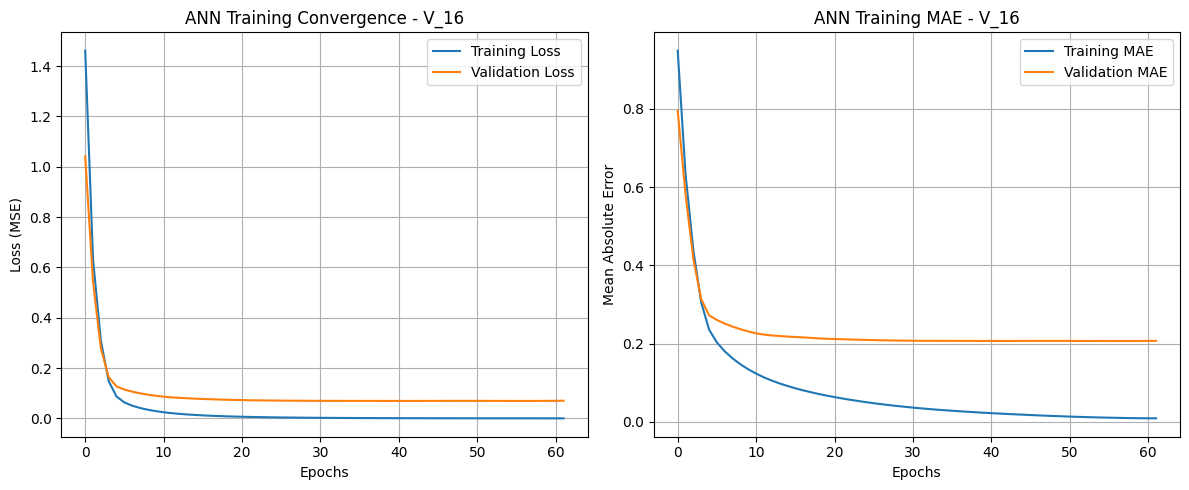


Performing sensitivity analysis on network architecture...
Training with Small architecture: [32, 16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Training with Medium architecture: [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with Large architecture: [128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with Extra Large architecture: [256, 128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


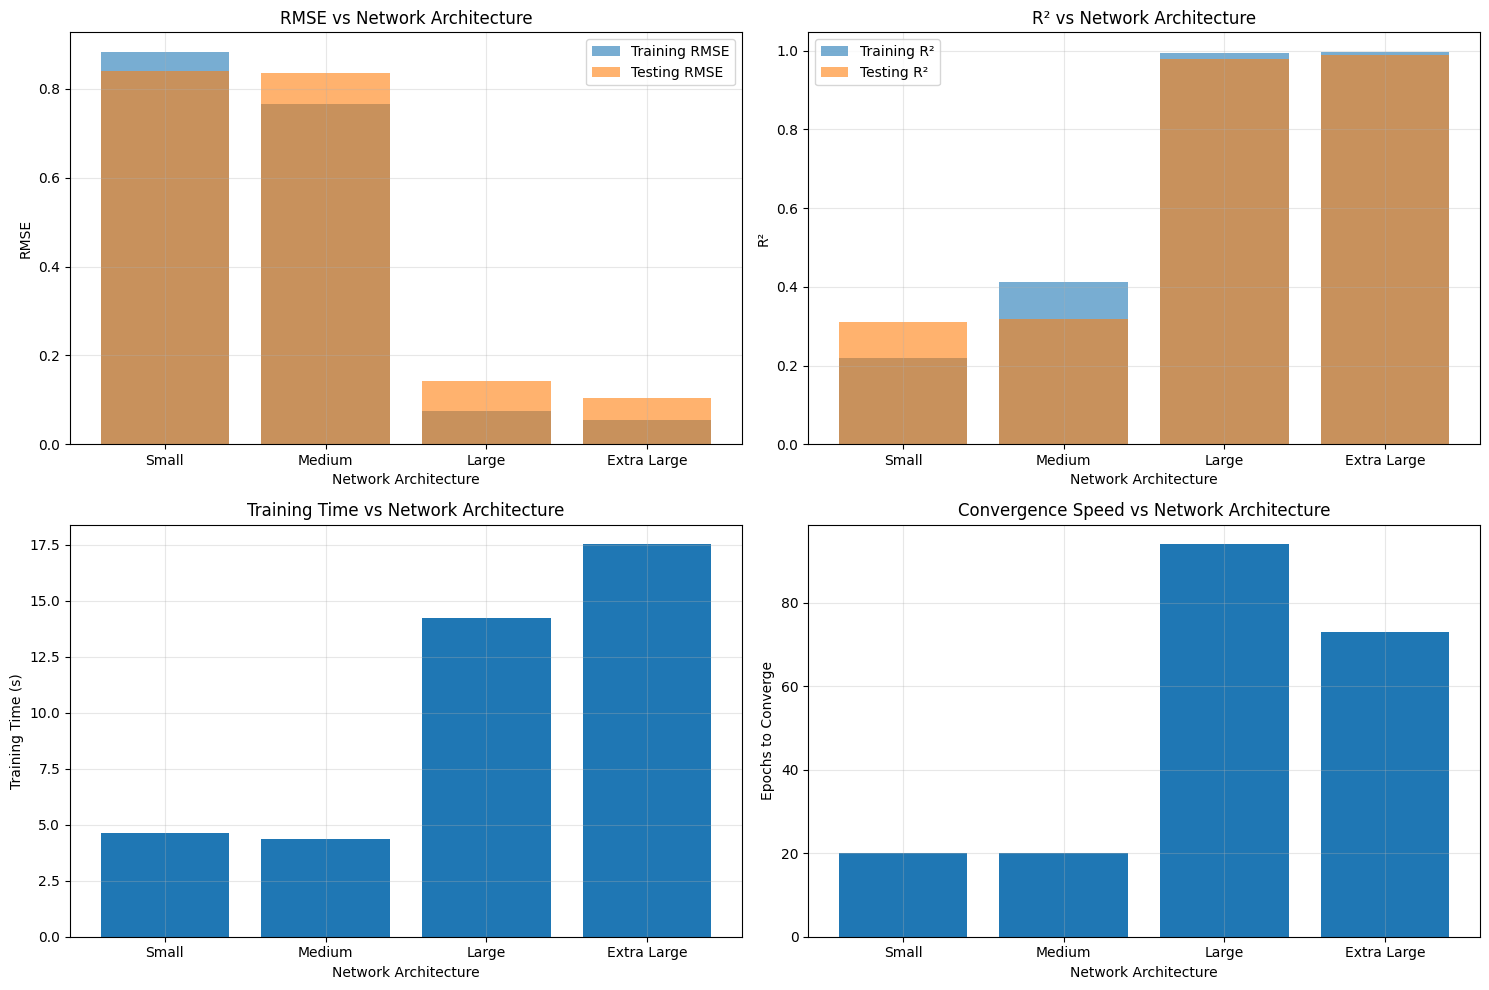


Performing learning rate and batch size tuning for V_16...
Training with learning rate=0.001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training with learning rate=0.001, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training with learning rate=0.001, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with learning rate=0.01, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training with learning rate=0.01, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training with learning rate=0.01, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training with learning rate=0.0001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training with learning rate=0.000

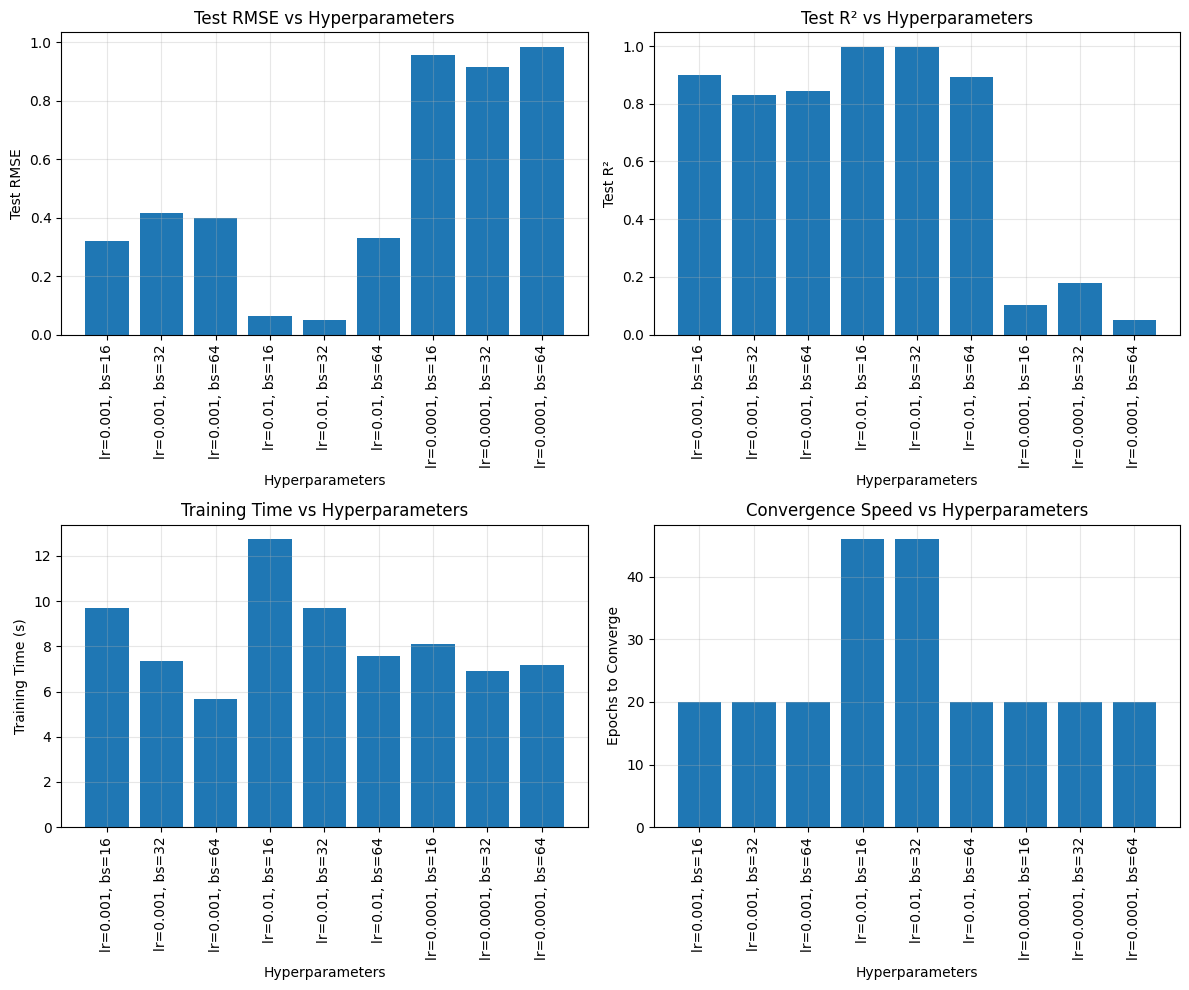


Training final ANN model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.6723 - mae: 0.6307 - val_loss: 0.1059 - val_mae: 0.2507
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0858 - mae: 0.2318 - val_loss: 0.0238 - val_mae: 0.1214
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0347 - mae: 0.1474 - val_loss: 0.0248 - val_mae: 0.1221
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0258 - mae: 0.1227 - val_loss: 0.0904 - val_mae: 0.2090
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0328 - mae: 0.1277 - val_loss: 0.0242 - val_mae: 0.1272
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0256 - mae: 0.1230 - val_loss: 0.0326 - val_mae: 0.1437
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0195 - mae: 0.1054 - val_loss: 0.0236 - val_mae: 0.1167
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0227 - mae: 0.1087 - val_loss: 0.0098 - val_mae: 0.0818
Epoch 

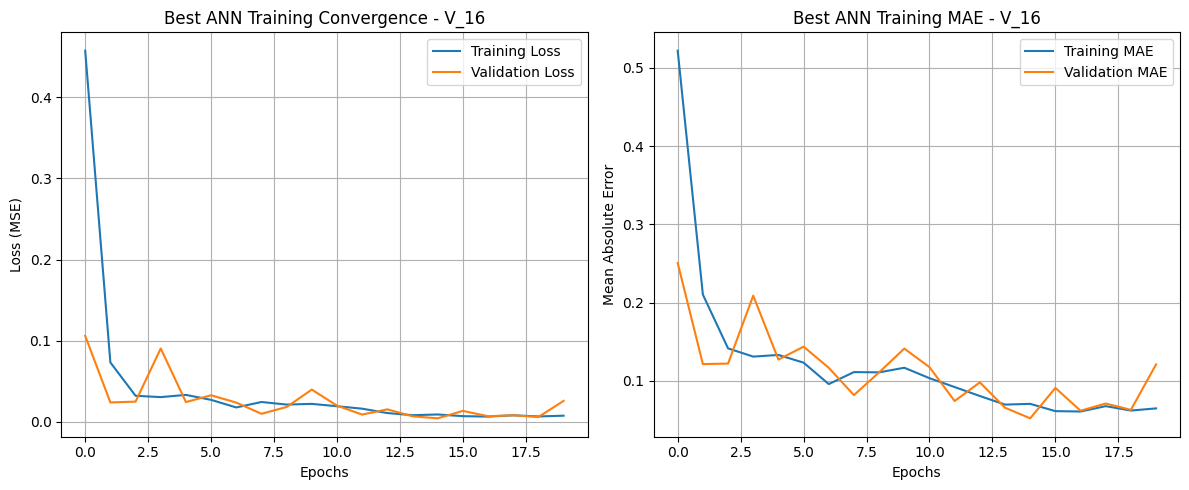


Analyzing feature sensitivity...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


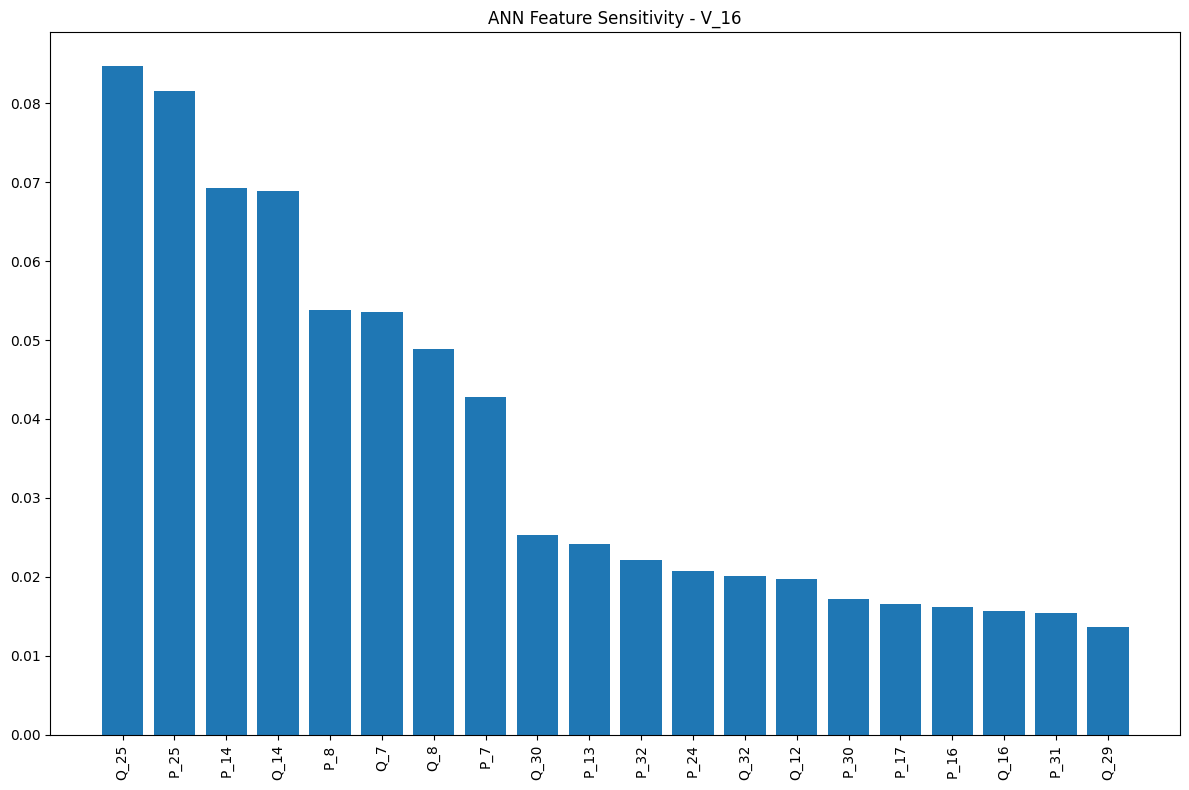

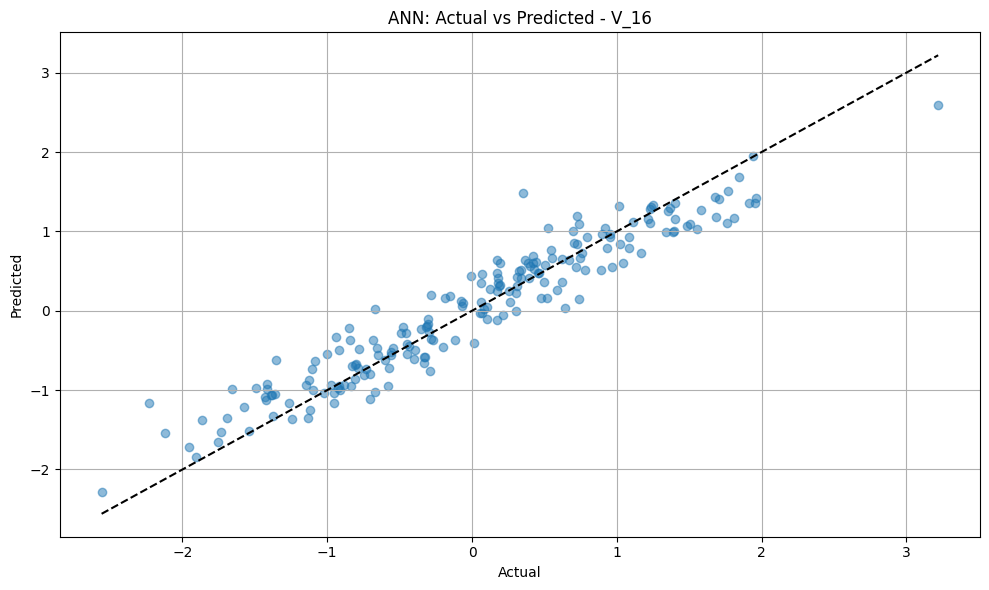


Generating learning curves based on training data size...
Training with 20% of data...
Training with 40% of data...
Training with 60% of data...
Training with 80% of data...
Training with 100% of data...


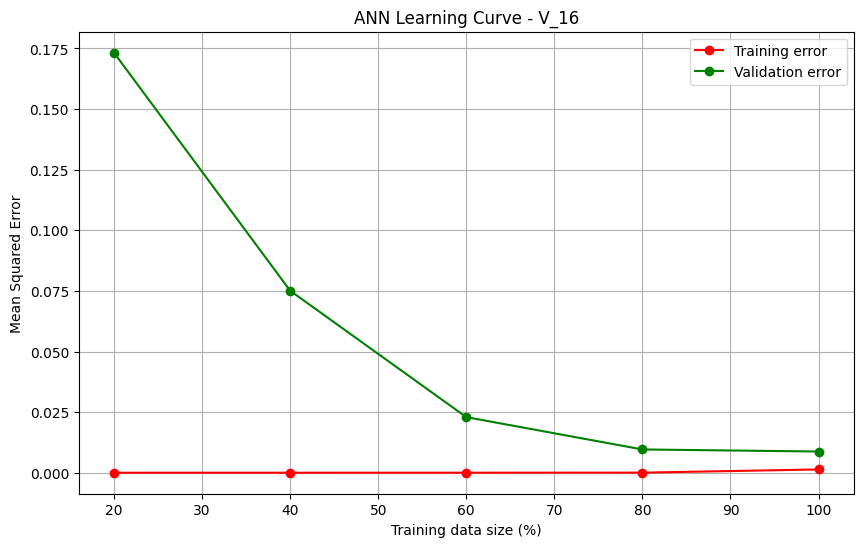

In [67]:
print("\n1. Training ANN for single voltage prediction (V_16)...")
ann_v16_results = train_ann_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)


2. Training ANN for loss prediction...

Training base ANN model for loss...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0329 - mae: 0.8046 - val_loss: 0.6711 - val_mae: 0.6496
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3925 - mae: 0.5029 - val_loss: 0.3419 - val_mae: 0.4607
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1737 - mae: 0.3343 - val_loss: 0.2071 - val_mae: 0.3545
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1016 - mae: 0.2501 - val_loss: 0.1617 - val_mae: 0.3131
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0738 - mae: 0.2133 - val_loss: 0.1429 - val_mae: 0.2946
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0548 - mae: 0.1836 - val_loss: 0.1309 - val_mae: 0.2821
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420 - mae: 0.1604 - val_loss: 0.1219 - val_mae: 0.2715
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0332 - mae: 0.1427 - val_loss: 0.1148 - va

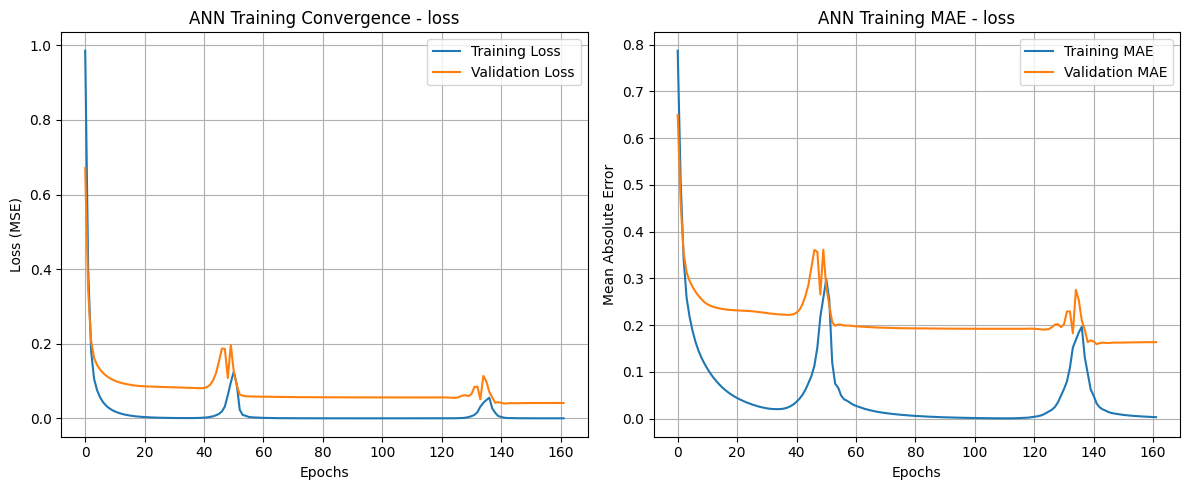


Performing sensitivity analysis on network architecture...
Training with Small architecture: [32, 16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training with Medium architecture: [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with Large architecture: [128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training with Extra Large architecture: [256, 128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


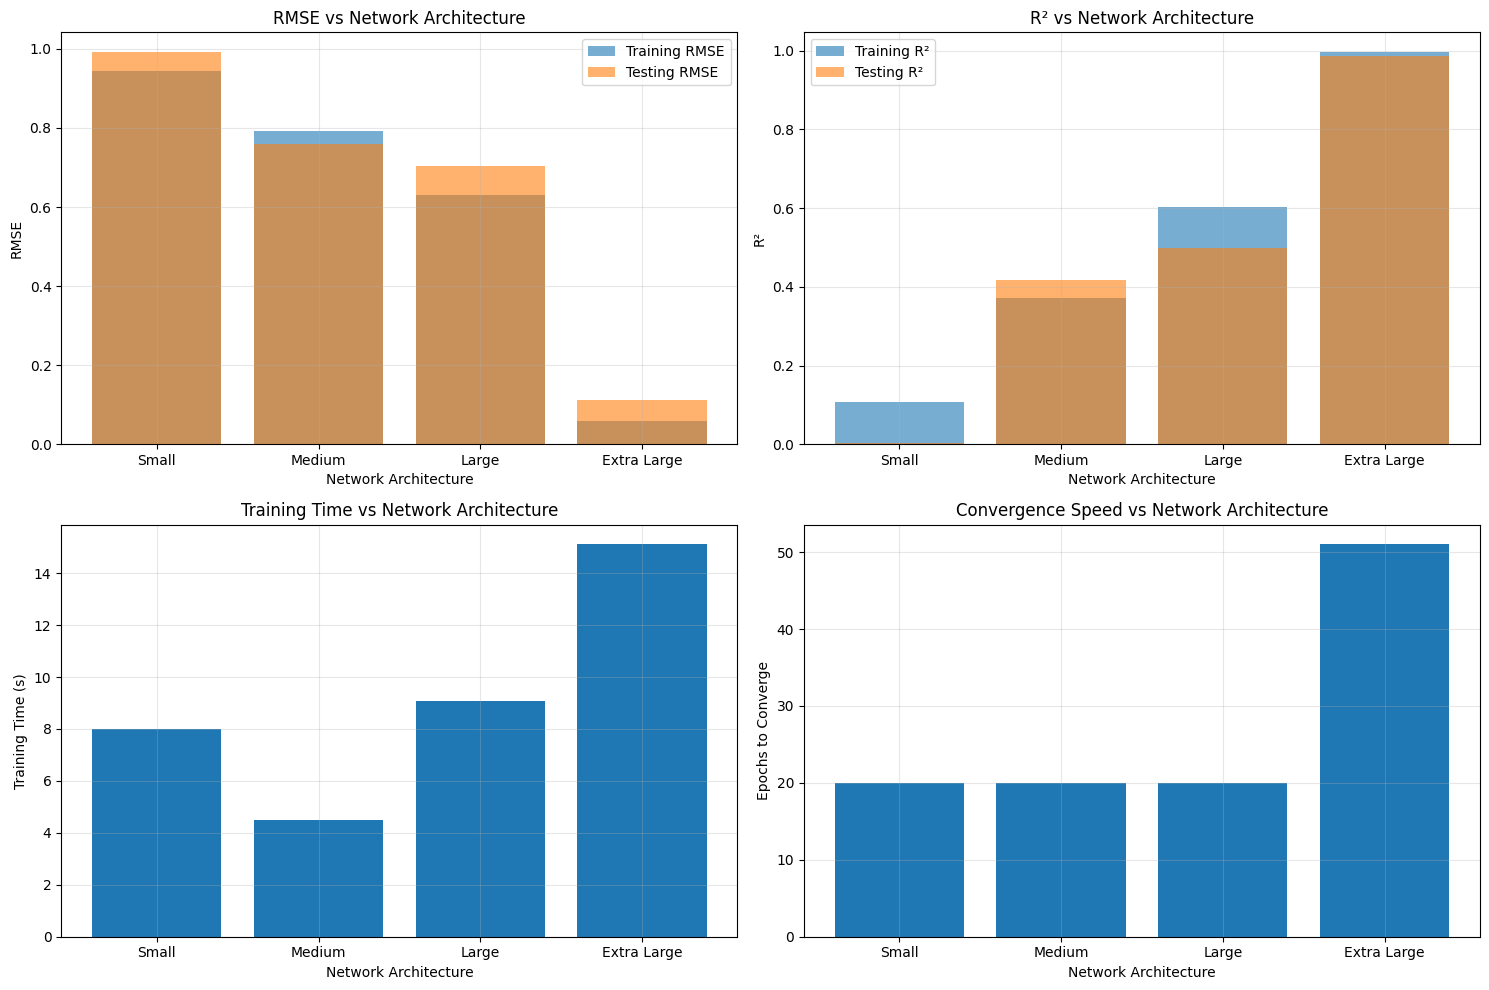


Performing learning rate and batch size tuning for loss...
Training with learning rate=0.001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with learning rate=0.001, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training with learning rate=0.001, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with learning rate=0.01, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training with learning rate=0.01, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with learning rate=0.01, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training with learning rate=0.0001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Training with learning rate=0.0001

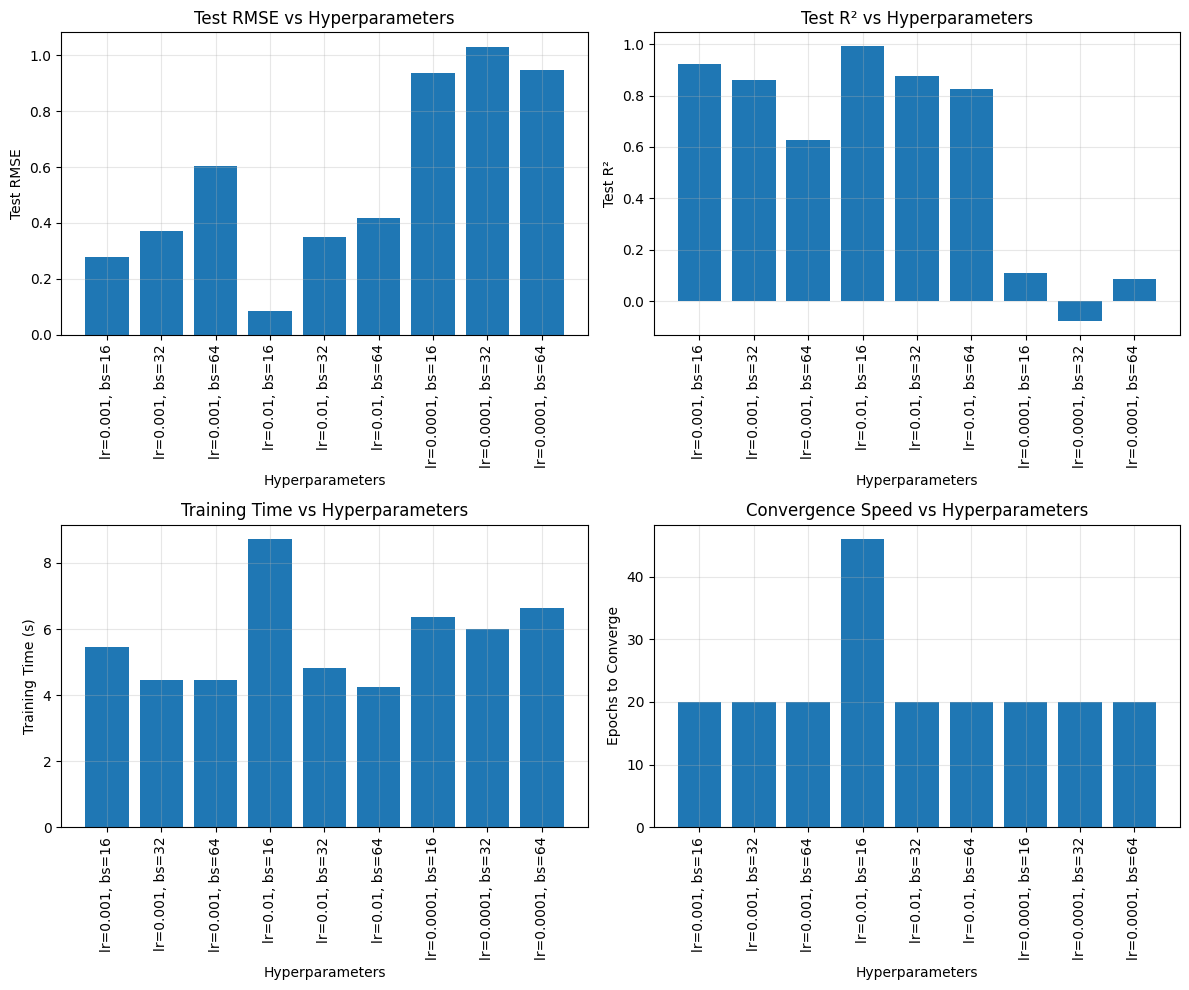


Training final ANN model with best parameters...
Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.6992 - mae: 0.6281 - val_loss: 0.0534 - val_mae: 0.1824
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0373 - mae: 0.1532 - val_loss: 0.0336 - val_mae: 0.1312
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0225 - mae: 0.1212 - val_loss: 0.0121 - val_mae: 0.0898
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0128 - mae: 0.0877 - val_loss: 0.0074 - val_mae: 0.0675
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0073 - mae: 0.0671 - val_loss: 0.0057 - val_mae: 0.0596
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0054 - mae: 0.0594 - val_loss: 0.0108 - val_mae: 0.0826
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - mae: 0.0716 - val_loss: 0.0158 - val_mae: 0.0954
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0135 - mae: 0.0905 - val_loss: 0.0264 - val_mae: 0.1339
Epoch 

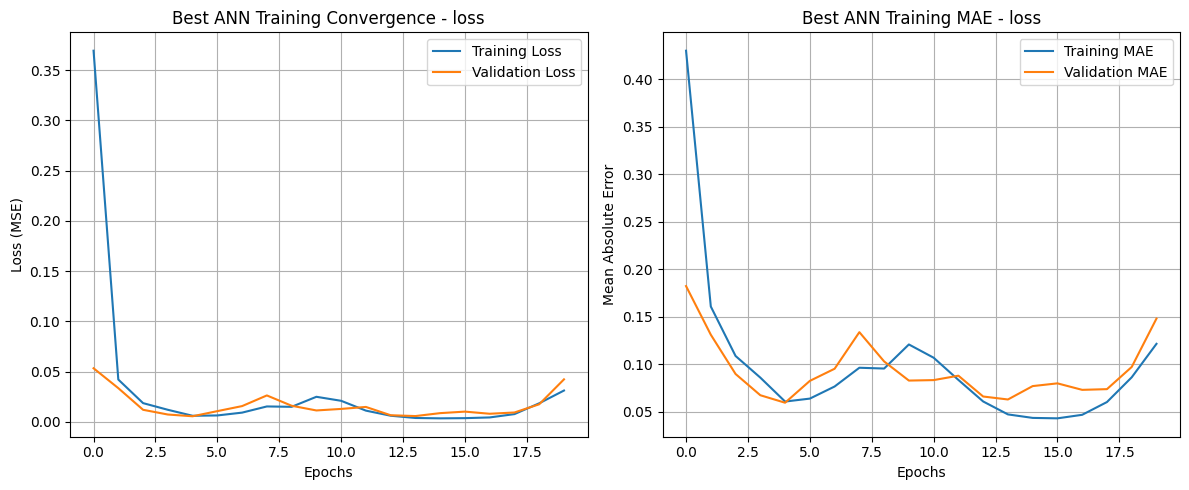


Analyzing feature sensitivity...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


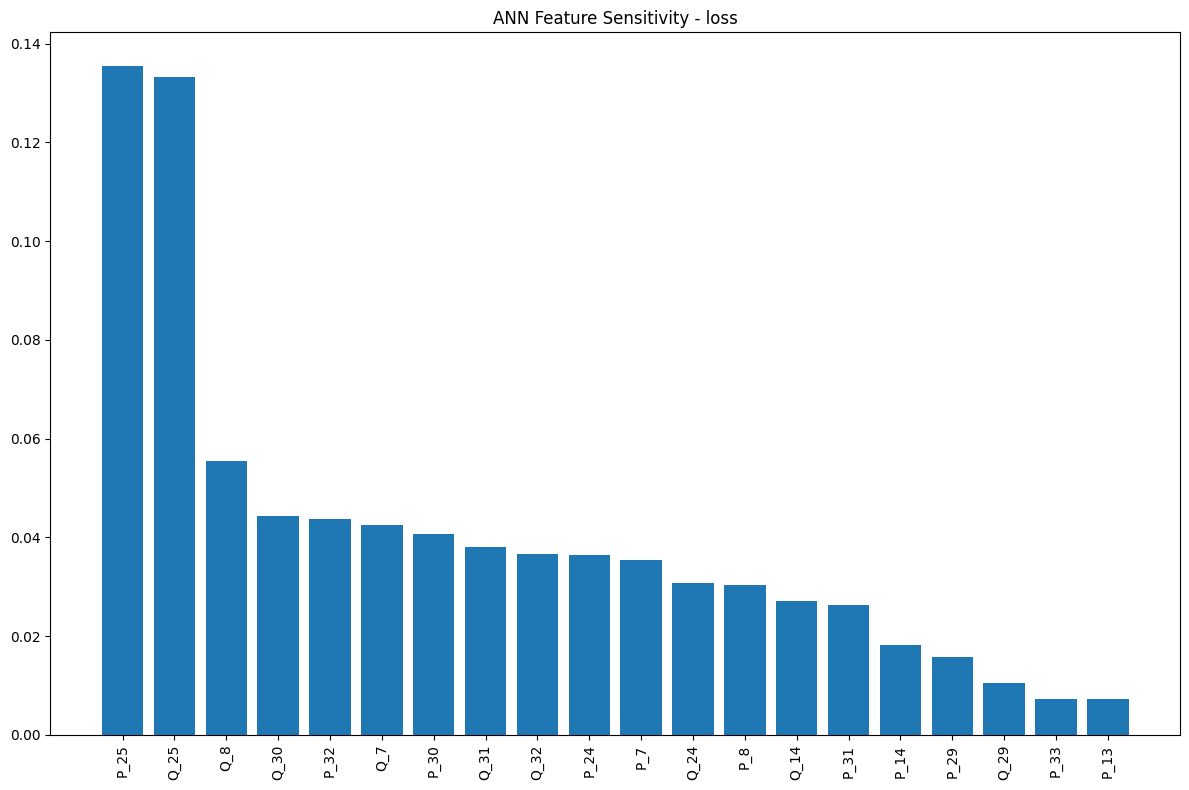

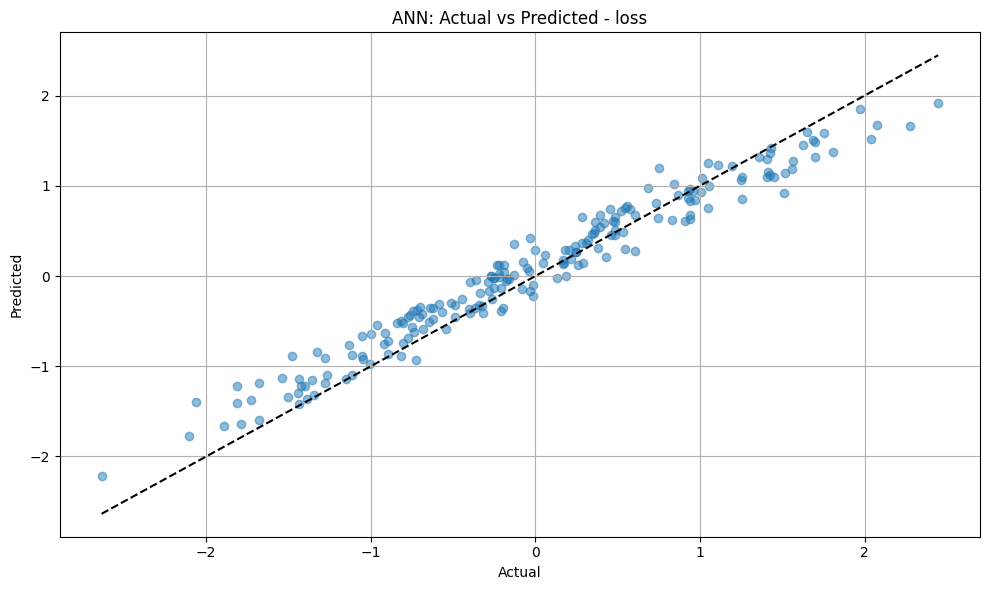


Generating learning curves based on training data size...
Training with 20% of data...
Training with 40% of data...
Training with 60% of data...
Training with 80% of data...
Training with 100% of data...


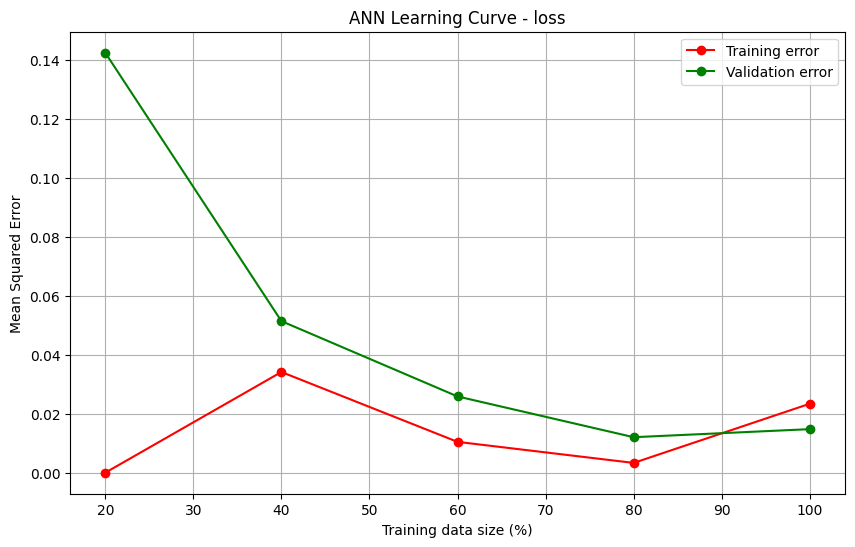

In [68]:
print("\n2. Training ANN for loss prediction...")
ann_loss_results = train_ann_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)


3. Training ANN for all voltages prediction...

Training base ANN model for all_voltages...
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.1412 - mae: 0.8466 - val_loss: 1.0451 - val_mae: 0.8108
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8840 - mae: 0.7455 - val_loss: 0.8986 - val_mae: 0.7495
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7298 - mae: 0.6736 - val_loss: 0.6792 - val_mae: 0.6418
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5130 - mae: 0.5565 - val_loss: 0.4056 - val_mae: 0.4879
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2890 - mae: 0.4134 - val_loss: 0.2316 - val_mae: 0.3681
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1683 - mae: 0.3174 - val_loss: 0.1614 - val_mae: 0.3111
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1196 - mae: 0.2700 - val_loss: 0.1296 - val_mae: 0.2810
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0982 - mae: 0.2458 - val_l

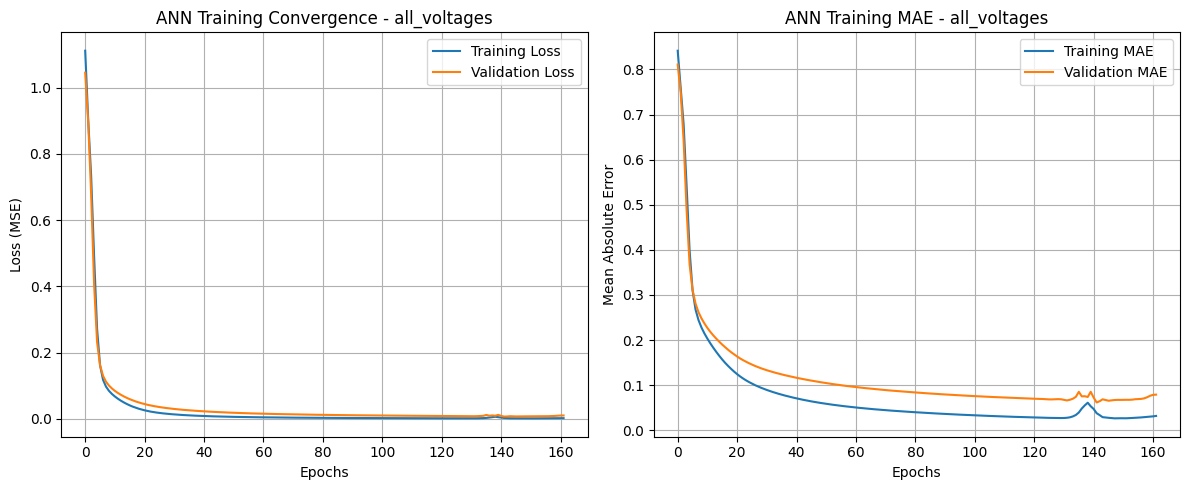


Performing sensitivity analysis on network architecture...
Training with Small architecture: [32, 16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training with Medium architecture: [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training with Large architecture: [128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training with Extra Large architecture: [256, 128, 64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


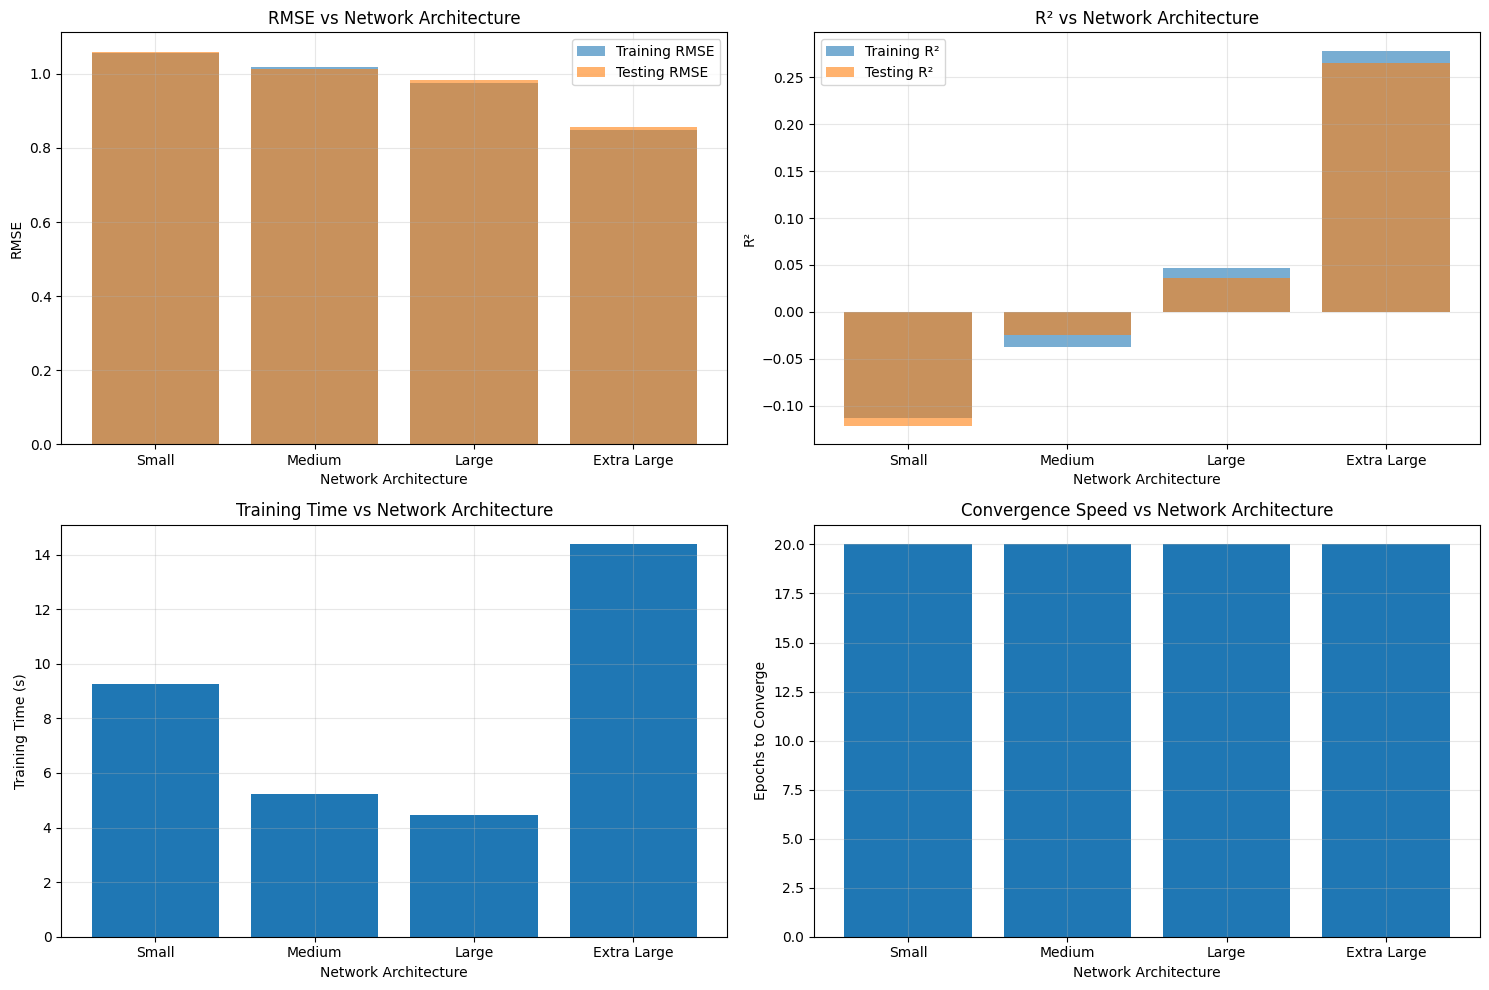


Performing learning rate and batch size tuning for all_voltages...
Training with learning rate=0.001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training with learning rate=0.001, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Training with learning rate=0.001, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training with learning rate=0.01, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training with learning rate=0.01, batch size=32...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training with learning rate=0.01, batch size=64...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training with learning rate=0.0001, batch size=16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Training with learning ra

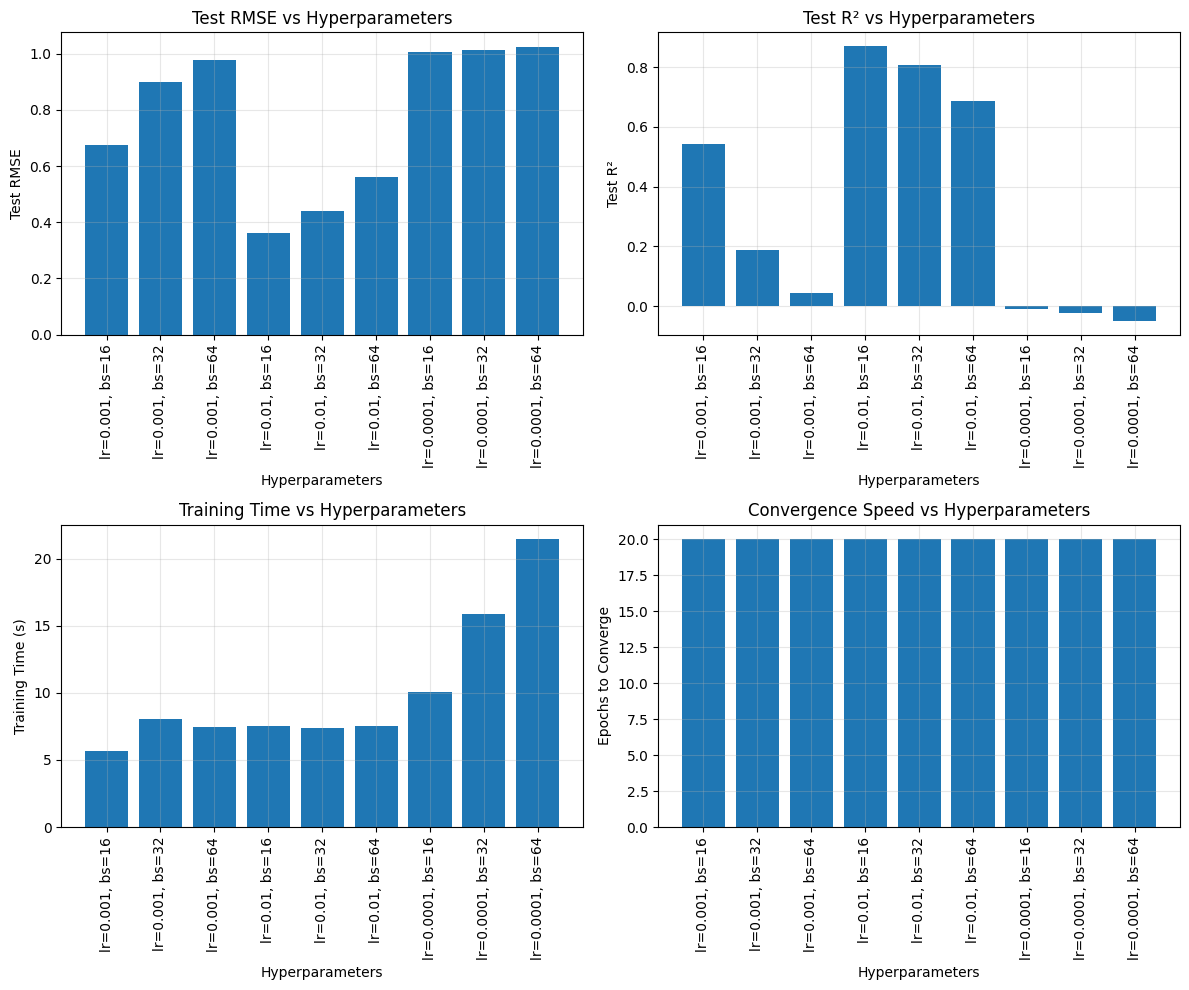


Training final ANN model with best parameters...
Epoch 1/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - loss: 0.6981 - mae: 0.6509 - val_loss: 0.1147 - val_mae: 0.2653
Epoch 2/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1122 - mae: 0.2613 - val_loss: 0.0834 - val_mae: 0.2224
Epoch 3/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0780 - mae: 0.2150 - val_loss: 0.0660 - val_mae: 0.2013
Epoch 4/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0653 - mae: 0.1965 - val_loss: 0.0537 - val_mae: 0.1780
Epoch 5/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0520 - mae: 0.1734 - val_loss: 0.0715 - val_mae: 0.2024
Epoch 6/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0549 - mae: 0.1765 - val_loss: 0.0577 - val_mae: 0.1849
Epoch 7/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0500 - mae: 0.1673 - val_loss: 0.0577 - val_mae: 0.1833
Epoch 8/300
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0501 - mae: 0.1669 - val_loss: 0.0450 - val_mae: 0.1663
Epoch

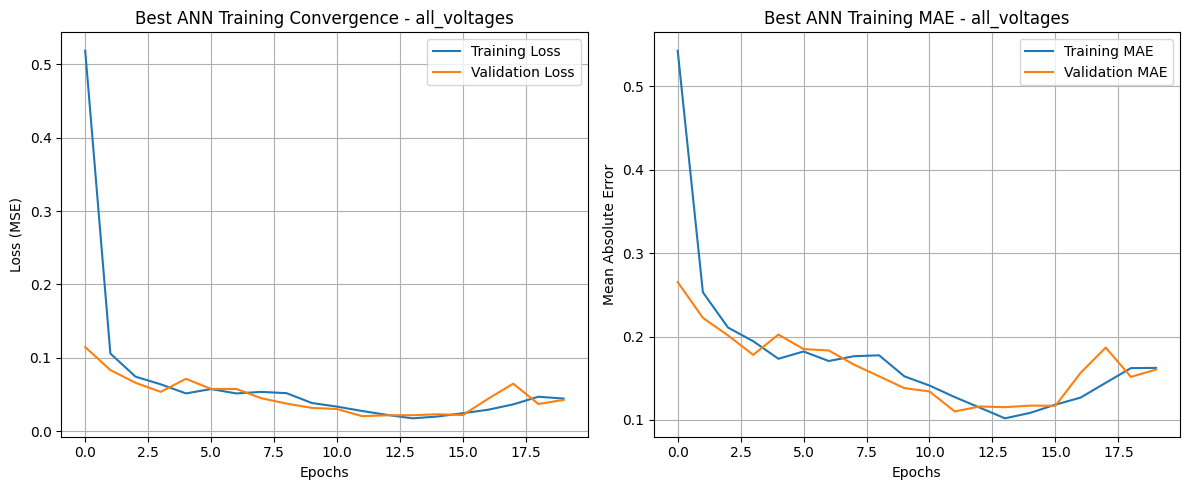

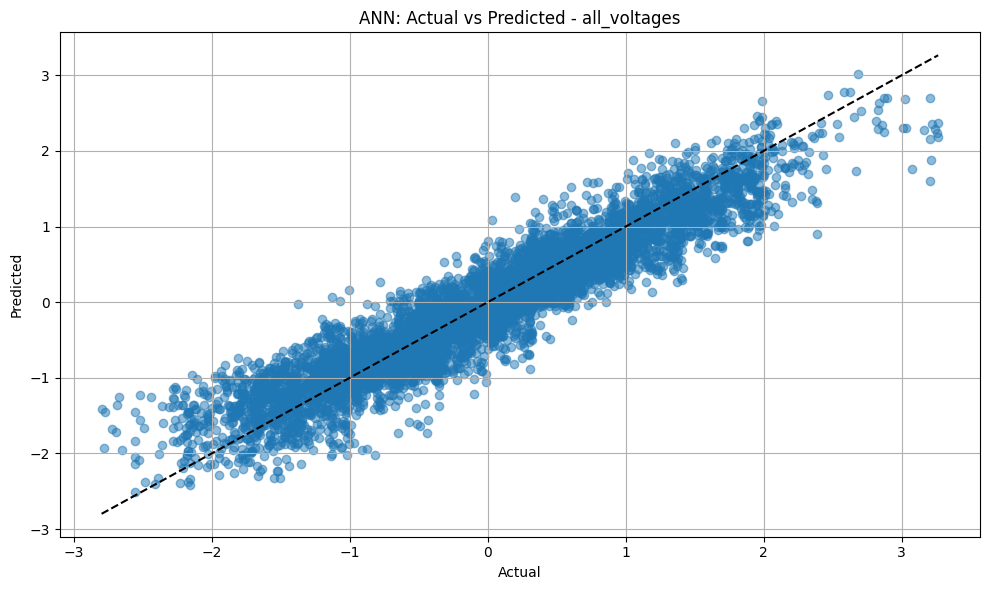


Generating learning curves based on training data size...
Training with 20% of data...
Training with 40% of data...
Training with 60% of data...
Training with 80% of data...
Training with 100% of data...


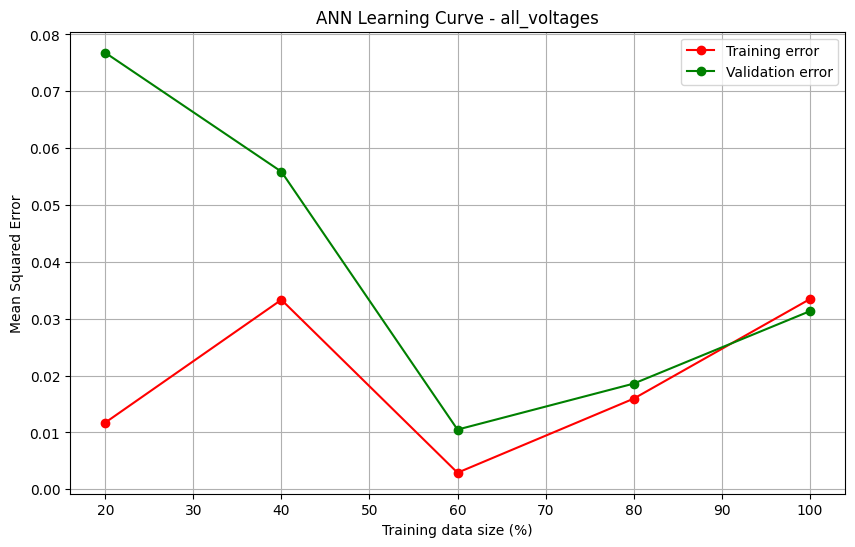

In [69]:
print("\n3. Training ANN for all voltages prediction...")
ann_all_v_results = train_ann_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [71]:
print("\nSaving trained ANN models...")

ann_v16_results['best_model']['model'].save('models/ann/ann_v16_best_model.keras')
ann_loss_results['best_model']['model'].save('models/ann/ann_loss_best_model.keras')
ann_all_v_results['best_model']['model'].save('models/ann/ann_all_v_best_model.keras')

with open('models/ann/ann_v16_scaler.pkl', 'wb') as f:
    pickle.dump(ann_v16_results['best_model']['scaler'], f)

with open('models/ann/ann_loss_scaler.pkl', 'wb') as f:
    pickle.dump(ann_loss_results['best_model']['scaler'], f)

with open('models/ann/ann_all_v_scaler.pkl', 'wb') as f:
    pickle.dump(ann_all_v_results['best_model']['scaler'], f)


Saving trained ANN models...


In [72]:
print("ANN models saved successfully!")
print("\n=== ANN Models Summary ===")
print(f"V_16 Prediction - Test R²: {ann_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {ann_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {ann_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {ann_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {ann_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {ann_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")

ANN models saved successfully!

=== ANN Models Summary ===
V_16 Prediction - Test R²: 0.9056, RMSE: 0.3107
Loss Prediction - Test R²: 0.9394, RMSE: 0.2447
All Voltages Prediction - Test R²: 0.8798, RMSE: 0.3470


### LSTM

In [78]:
def train_lstm_model(X_train, y_train, X_test, y_test, target_name, feature_names):
    results = {}
    
    train_losses = []
    val_losses = []
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape data for LSTM [samples, timesteps, features]
    # Using a novel approach: treating features as sequential spatial dependencies
    # Reshape data with a sliding window over features
    def create_feature_sequences(X, window_size=4):
        n_samples, n_features = X.shape
        # Pad features if needed to make them divisible by window_size
        padding = 0
        if n_features % window_size != 0:
            padding = window_size - (n_features % window_size)
            padded_X = np.pad(X, ((0, 0), (0, padding)), 'constant')
            n_features = padded_X.shape[1]
        else:
            padded_X = X
            
        # Reshape to [samples, timesteps, features_per_timestep]
        n_timesteps = n_features // window_size
        X_seq = padded_X.reshape(n_samples, n_timesteps, window_size)
        return X_seq, n_timesteps, window_size
    
    # Create sequences for LSTM
    window_size = min(4, X_train.shape[1])  # Adjust window size based on feature count
    X_train_seq, n_timesteps, features_per_step = create_feature_sequences(X_train_scaled, window_size)
    X_test_seq, _, _ = create_feature_sequences(X_test_scaled, window_size)
    
    print(f"\nTraining base LSTM model for {target_name}...")
    print(f"Reshaped data: {X_train_seq.shape} [samples, timesteps, features_per_step]")
    
    output_dim = 1 if len(y_train.shape) == 1 or y_train.shape[1] == 1 else y_train.shape[1]
    
    # 1. Base model for quick evaluation
    base_model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(n_timesteps, features_per_step), return_sequences=False),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim)
    ])
    
    base_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Use early stopping for all models
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
    
    class LossHistory(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            train_losses.append(logs.get('loss'))
            val_losses.append(logs.get('val_loss'))
    
    history_callback = LossHistory()
    
    base_history = base_model.fit(
        X_train_seq, y_train,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, history_callback],
        verbose=1
    )
    
    y_train_pred = base_model.predict(X_train_seq)
    y_test_pred = base_model.predict(X_test_seq)
    
    train_metrics = regression_metrics(y_train, y_train_pred)
    test_metrics = regression_metrics(y_test, y_test_pred)
    
    print(f"Base LSTM Model - Training R²: {train_metrics['R2']:.4f}, RMSE: {train_metrics['RMSE']:.4f}")
    print(f"Base LSTM Model - Testing R²: {test_metrics['R2']:.4f}, RMSE: {test_metrics['RMSE']:.4f}")
    
    results['base_model'] = {
        'model': base_model,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'y_test_pred': y_test_pred,
        'history': base_history.history
    }
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(base_history.history['loss'], label='Training Loss')
    plt.plot(base_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'LSTM Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(base_history.history['mae'], label='Training MAE')
    plt.plot(base_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'LSTM Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm_{target_name}_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Sensitivity Analysis for LSTM architecture
    print(f"\nPerforming sensitivity analysis on LSTM architecture...")
    
    architectures = [
        {'name': 'Small', 'units': [32], 'dense': [16]},
        {'name': 'Medium', 'units': [64], 'dense': [32]},
        {'name': 'Deep', 'units': [32, 32], 'dense': [32]},
        {'name': 'Large', 'units': [128], 'dense': [64, 32]}
    ]
    
    architecture_results = []
    
    for arch in architectures:
        print(f"Training with {arch['name']} architecture: LSTM {arch['units']}, Dense {arch['dense']}...")
        start_time = time.time()
        
        # Build model with this architecture
        model = tf.keras.Sequential()
        
        # Add LSTM layers
        for i, units in enumerate(arch['units']):
            return_sequences = i < len(arch['units']) - 1  # True for all but last LSTM layer
            if i == 0:
                model.add(tf.keras.layers.LSTM(units, input_shape=(n_timesteps, features_per_step), 
                                            return_sequences=return_sequences))
            else:
                model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
        
        # Add Dense layers
        for units in arch['dense']:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        # Output layer
        model.add(tf.keras.layers.Dense(output_dim))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_seq, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        train_pred = model.predict(X_train_seq)
        test_pred = model.predict(X_test_seq)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        architecture_results.append({
            'name': arch['name'],
            'lstm_units': arch['units'],
            'dense_units': arch['dense'],
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    plt.figure(figsize=(15, 10))
    
    # Plot RMSE vs architecture
    plt.subplot(2, 2, 1)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_rmse'] for r in architecture_results], 
            alpha=0.6, label='Training RMSE')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_rmse'] for r in architecture_results], 
            alpha=0.6, label='Testing RMSE')
    plt.xlabel('Network Architecture')
    plt.ylabel('RMSE')
    plt.title('RMSE vs LSTM Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot R² vs architecture
    plt.subplot(2, 2, 2)
    plt.bar([r['name'] for r in architecture_results], 
            [r['train_r2'] for r in architecture_results], 
            alpha=0.6, label='Training R²')
    plt.bar([r['name'] for r in architecture_results], 
            [r['test_r2'] for r in architecture_results], 
            alpha=0.6, label='Testing R²')
    plt.xlabel('Network Architecture')
    plt.ylabel('R²')
    plt.title('R² vs LSTM Architecture')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot training time vs architecture
    plt.subplot(2, 2, 3)
    plt.bar([r['name'] for r in architecture_results], 
             [r['training_time'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs LSTM Architecture')
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar([r['name'] for r in architecture_results], 
             [r['epochs'] for r in architecture_results])
    plt.xlabel('Network Architecture')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs LSTM Architecture')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm_{target_name}_architecture_sensitivity.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['architecture_sensitivity'] = architecture_results
    
    # 3. Window size sensitivity analysis (unique to LSTM approach)
    print(f"\nPerforming window size sensitivity analysis for {target_name}...")
    
    # Select best architecture from previous analysis
    best_arch_idx = np.argmin([r['test_rmse'] for r in architecture_results])
    best_lstm_units = architecture_results[best_arch_idx]['lstm_units']
    best_dense_units = architecture_results[best_arch_idx]['dense_units']
    
    # Test different window sizes
    window_sizes = [2, 4, 8, 16]
    window_size_results = []
    
    for ws in window_sizes:
        if ws > X_train.shape[1]:
            print(f"Skipping window size {ws}, too large for input features ({X_train.shape[1]})")
            continue
            
        print(f"Testing window size {ws}...")
        start_time = time.time()
        
        # Reshape data with this window size
        X_train_ws, n_timesteps_ws, features_per_step_ws = create_feature_sequences(X_train_scaled, ws)
        X_test_ws, _, _ = create_feature_sequences(X_test_scaled, ws)
        
        # Build model with best architecture
        model = tf.keras.Sequential()
        
        # Add LSTM layers
        for i, units in enumerate(best_lstm_units):
            return_sequences = i < len(best_lstm_units) - 1  # True for all but last LSTM layer
            if i == 0:
                model.add(tf.keras.layers.LSTM(units, 
                                            input_shape=(n_timesteps_ws, features_per_step_ws),
                                            return_sequences=return_sequences))
            else:
                model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
        
        # Add Dense layers
        for units in best_dense_units:
            model.add(tf.keras.layers.Dense(units, activation='relu'))
        
        # Output layer
        model.add(tf.keras.layers.Dense(output_dim))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        # Train with early stopping
        history = model.fit(
            X_train_ws, y_train,
            epochs=200,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )
        
        train_pred = model.predict(X_train_ws)
        test_pred = model.predict(X_test_ws)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
        train_r2 = r2_score(y_train, train_pred)
        test_r2 = r2_score(y_test, test_pred)
        
        training_time = time.time() - start_time
        final_epochs = len(history.history['loss'])
        
        window_size_results.append({
            'window_size': ws,
            'timesteps': n_timesteps_ws,
            'features_per_step': features_per_step_ws,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'training_time': training_time,
            'epochs': final_epochs
        })
    
    # Find best window size
    if window_size_results:
        best_ws_idx = np.argmin([r['test_rmse'] for r in window_size_results])
        best_window_size = window_size_results[best_ws_idx]['window_size']
        best_timesteps = window_size_results[best_ws_idx]['timesteps']
        best_features_per_step = window_size_results[best_ws_idx]['features_per_step']
        
        print(f"Best window size: {best_window_size}, giving {best_timesteps} timesteps with {best_features_per_step} features per step")
        
        # Plot window size results
        plt.figure(figsize=(12, 10))
        
        # Plot test RMSE vs window size
        plt.subplot(2, 2, 1)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['test_rmse'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Test RMSE')
        plt.title('RMSE vs Window Size')
        plt.grid(True, alpha=0.3)
        
        # Plot test R² vs window size
        plt.subplot(2, 2, 2)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['test_r2'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Test R²')
        plt.title('R² vs Window Size')
        plt.grid(True, alpha=0.3)
        
        # Plot training time
        plt.subplot(2, 2, 3)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['training_time'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Training Time (s)')
        plt.title('Training Time vs Window Size')
        plt.grid(True, alpha=0.3)
        
        # Plot number of timesteps
        plt.subplot(2, 2, 4)
        plt.bar([f"Size {r['window_size']}" for r in window_size_results], 
                [r['timesteps'] for r in window_size_results])
        plt.xlabel('Window Size')
        plt.ylabel('Number of Timesteps')
        plt.title('Timesteps vs Window Size')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'figures/lstm_{target_name}_window_size_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        results['window_size_analysis'] = window_size_results
    else:
        print("No valid window sizes found for analysis")
        # Use original window size
        best_window_size = window_size
        best_timesteps = n_timesteps
        best_features_per_step = features_per_step
    
    # 4. Hyperparameter tuning
    print(f"\nPerforming learning rate and dropout tuning for {target_name}...")
    
    learning_rates = [0.001, 0.01, 0.0001]
    dropout_rates = [0.0, 0.2, 0.4]
    
    # Reshape data with best window size
    X_train_best, _, _ = create_feature_sequences(X_train_scaled, best_window_size)
    X_test_best, _, _ = create_feature_sequences(X_test_scaled, best_window_size)
    
    hyperparameter_results = []
    
    for lr in learning_rates:
        for dr in dropout_rates:
            print(f"Training with learning rate={lr}, dropout rate={dr}...")
            start_time = time.time()
            
            # Build model with best architecture
            model = tf.keras.Sequential()
            
            # Add LSTM layers with dropout
            for i, units in enumerate(best_lstm_units):
                return_sequences = i < len(best_lstm_units) - 1  # True for all but last LSTM layer
                if i == 0:
                    model.add(tf.keras.layers.LSTM(units, 
                                                input_shape=(best_timesteps, best_features_per_step),
                                                return_sequences=return_sequences))
                else:
                    model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
                
                if dr > 0:
                    model.add(tf.keras.layers.Dropout(dr))
            
            # Add Dense layers
            for units in best_dense_units:
                model.add(tf.keras.layers.Dense(units, activation='relu'))
                if dr > 0:
                    model.add(tf.keras.layers.Dropout(dr))
            
            # Output layer
            model.add(tf.keras.layers.Dense(output_dim))
            
            # Customize optimizer with learning rate
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
            model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
            
            # Train with early stopping
            history = model.fit(
                X_train_best, y_train,
                epochs=200,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=0
            )
            
            train_pred = model.predict(X_train_best)
            test_pred = model.predict(X_test_best)
            
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            train_r2 = r2_score(y_train, train_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            training_time = time.time() - start_time
            final_epochs = len(history.history['loss'])
            
            hyperparameter_results.append({
                'learning_rate': lr,
                'dropout_rate': dr,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_r2': train_r2,
                'test_r2': test_r2,
                'training_time': training_time,
                'epochs': final_epochs
            })
    
    best_hp_idx = np.argmin([r['test_rmse'] for r in hyperparameter_results])
    best_lr = hyperparameter_results[best_hp_idx]['learning_rate']
    best_dr = hyperparameter_results[best_hp_idx]['dropout_rate']
    
    print(f"Best hyperparameters: learning_rate={best_lr}, dropout_rate={best_dr}")
    
    plt.figure(figsize=(12, 10))
    
    hp_labels = [f"lr={r['learning_rate']}, dr={r['dropout_rate']}" for r in hyperparameter_results]
    
    # Plot test RMSE vs hyperparameters
    plt.subplot(2, 2, 1)
    plt.bar(hp_labels, [r['test_rmse'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test RMSE')
    plt.title('Test RMSE vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot test R² vs hyperparameters
    plt.subplot(2, 2, 2)
    plt.bar(hp_labels, [r['test_r2'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Test R²')
    plt.title('Test R² vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot training time
    plt.subplot(2, 2, 3)
    plt.bar(hp_labels, [r['training_time'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Training Time (s)')
    plt.title('Training Time vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    # Plot epochs to converge
    plt.subplot(2, 2, 4)
    plt.bar(hp_labels, [r['epochs'] for r in hyperparameter_results])
    plt.xlabel('Hyperparameters')
    plt.ylabel('Epochs to Converge')
    plt.title('Convergence Speed vs Hyperparameters')
    plt.xticks(rotation=90)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm_{target_name}_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    results['hyperparameter_tuning'] = hyperparameter_results
    
    # 5. Train best model with optimal settings
    print(f"\nTraining final LSTM model with best parameters...")
    
    best_model = tf.keras.Sequential()
    
    # Add LSTM layers with dropout
    for i, units in enumerate(best_lstm_units):
        return_sequences = i < len(best_lstm_units) - 1  # True for all but last LSTM layer
        if i == 0:
            best_model.add(tf.keras.layers.LSTM(units, 
                                        input_shape=(best_timesteps, best_features_per_step),
                                        return_sequences=return_sequences))
        else:
            best_model.add(tf.keras.layers.LSTM(units, return_sequences=return_sequences))
        
        if best_dr > 0:
            best_model.add(tf.keras.layers.Dropout(best_dr))
    
    # Add Dense layers
    for units in best_dense_units:
        best_model.add(tf.keras.layers.Dense(units, activation='relu'))
        if best_dr > 0:
            best_model.add(tf.keras.layers.Dropout(best_dr))
    
    # Output layer
    best_model.add(tf.keras.layers.Dense(output_dim))
    
    # Create tensorboard callback
    tensorboard_dir = f"logs/lstm_{target_name}_{int(time.time())}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=tensorboard_dir,
        histogram_freq=1
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
    best_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    best_history = best_model.fit(
        X_train_best, y_train,
        epochs=300,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )
    
    best_train_pred = best_model.predict(X_train_best)
    best_test_pred = best_model.predict(X_test_best)
    
    best_train_metrics = regression_metrics(y_train, best_train_pred)
    best_test_metrics = regression_metrics(y_test, best_test_pred)
    
    print(f"Best LSTM Model - Training R²: {best_train_metrics['R2']:.4f}, RMSE: {best_train_metrics['RMSE']:.4f}")
    print(f"Best LSTM Model - Testing R²: {best_test_metrics['R2']:.4f}, RMSE: {best_test_metrics['RMSE']:.4f}")
    
    results['best_model'] = {
        'model': best_model,
        'scaler': scaler,
        'params': {
            'learning_rate': best_lr,
            'dropout_rate': best_dr,
            'window_size': best_window_size,
            'lstm_units': best_lstm_units,
            'dense_units': best_dense_units
        },
        'reshape_info': {
            'window_size': best_window_size,
            'timesteps': best_timesteps,
            'features_per_step': best_features_per_step
        },
        'train_metrics': best_train_metrics,
        'test_metrics': best_test_metrics,
        'y_test_pred': best_test_pred,
        'history': best_history.history
    }
    
    # Plot final model training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['loss'], label='Training Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title(f'Best LSTM Training Convergence - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['mae'], label='Training MAE')
    plt.plot(best_history.history['val_mae'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Best LSTM Training MAE - {target_name}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'figures/lstm_{target_name}_best_convergence.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Feature importance analysis using permutation importance
    if len(y_train.shape) == 1 or y_train.shape[1] == 1:
        print("\nAnalyzing feature importance using permutation method...")
        
        # Create a wrapper class that scikit-learn can use
        class LSTMWrapper:
            def __init__(self, model, window_size):
                self.model = model
                self.window_size = window_size
                
            def fit(self, X, y):
                # This method is required by permutation_importance but we don't need to implement it
                # since our model is already trained
                return self
                
            def predict(self, X):
                X_seq, _, _ = create_feature_sequences(X, self.window_size)
                return self.model.predict(X_seq)
        
        # Create wrapped model
        lstm_wrapper = LSTMWrapper(best_model, best_window_size)
        
        # Calculate feature importance
        perm_importance = permutation_importance(
            lstm_wrapper,
            X_test_scaled,
            y_test,
            n_repeats=10,
            random_state=42,
            scoring='r2'
        )
        
        importances = perm_importance.importances_mean
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        indices = np.argsort(importances)[::-1]
        plt.title(f'LSTM Feature Importance - {target_name}')
        plt.bar(range(min(20, len(feature_names))), importances[indices][:min(20, len(feature_names))], align='center')
        plt.xticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices][:min(20, len(feature_names))], rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/lstm_{target_name}_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Store top 10 important features
        top_features = [(feature_names[idx], importances[idx]) for idx in indices[:10]]
        results['feature_importance'] = {
            'importances': importances,
            'top_features': top_features
        }
    
    # 7. Plot actual vs predicted values for testing data
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, best_test_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'LSTM: Actual vs Predicted - {target_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'figures/lstm_{target_name}_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 8. Visualize LSTM layer activations
    print("\nVisualizing LSTM layer activations...")

    # Create a model that outputs LSTM activations (feature maps)
    if len(best_lstm_units) > 0:
        # Make sure the model is built by making a prediction first
        # This ensures the model has input and output shapes defined
        sample_data = X_train_best[:1]  # Just use one sample to initialize
        _ = best_model.predict(sample_data)
        
        # Now create the visualization model
        first_lstm_idx = 0
        for i, layer in enumerate(best_model.layers):
            if isinstance(layer, tf.keras.layers.LSTM):
                first_lstm_idx = i
                break
        
        first_lstm_layer_model = tf.keras.models.Model(
            inputs=best_model.input,
            outputs=best_model.layers[first_lstm_idx].output
        )
        
        # Get sample input data for visualization
        sample_data = X_train_best[:5]
        
        # Get LSTM layer activations
        activations = first_lstm_layer_model.predict(sample_data)
        
        # Plot activations for the first sample
        plt.figure(figsize=(12, 8))
        plt.imshow(activations[0].T, aspect='auto', cmap='viridis')
        plt.colorbar(label='Activation Value')
        plt.xlabel('Time Steps')
        plt.ylabel('LSTM Units')
        plt.title(f'LSTM Layer Activations ({best_lstm_units[0]} units) - {target_name}')
        plt.tight_layout()
        plt.savefig(f'figures/lstm_{target_name}_activations.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # If we have multiple LSTM layers, visualize the last one too
        if len(best_lstm_units) > 1:
            last_lstm_idx = 0
            for i, layer in enumerate(best_model.layers):
                if isinstance(layer, tf.keras.layers.LSTM):
                    last_lstm_idx = i
            
            last_lstm_layer_model = tf.keras.models.Model(
                inputs=best_model.input,
                outputs=best_model.layers[last_lstm_idx].output
            )
            
            # Get last LSTM layer activations
            last_activations = last_lstm_layer_model.predict(sample_data)
            
            # Plot last LSTM layer activations
            plt.figure(figsize=(12, 8))
            plt.imshow(last_activations[0].T, aspect='auto', cmap='viridis')
            plt.colorbar(label='Activation Value')
            plt.xlabel('Time Steps')
            plt.ylabel('LSTM Units')
            plt.title(f'Last LSTM Layer Activations ({best_lstm_units[-1]} units) - {target_name}')
            plt.tight_layout()
            plt.savefig(f'figures/lstm_{target_name}_last_layer_activations.png', dpi=300, bbox_inches='tight')
            plt.show()
    
    # 9. Model summary and architecture visualization
    print("\nLSTM Model Summary:")
    best_model.summary()
    
    # Create a visualization of the model architecture
    tf.keras.utils.plot_model(
        best_model,
        to_file=f'figures/lstm_{target_name}_model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=300
    )
    
    # 10. Save the complete results dictionary for later use
    results['metadata'] = {
        'target_name': target_name,
        'feature_names': feature_names,
        'training_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'train_size': X_train.shape[0],
        'test_size': X_test.shape[0],
        'feature_count': X_train.shape[1]
    }
    
    print(f"\nLSTM model training and analysis complete for {target_name}")
    return results

In [74]:
os.makedirs('models/lstm', exist_ok=True)


1. Training LSTM for single voltage prediction (V_16)...

Training base LSTM model for V_16...
Reshaped data: (800, 16, 4) [samples, timesteps, features_per_step]
Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.8053 - mae: 0.7201 - val_loss: 0.5077 - val_mae: 0.5596
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3720 - mae: 0.4943 - val_loss: 0.3261 - val_mae: 0.4461
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3498 - mae: 0.4847 - val_loss: 0.3182 - val_mae: 0.4424
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3408 - mae: 0.4787 - val_loss: 0.3164 - val_mae: 0.4403
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3274 - mae: 0.4670 - val_loss: 0.3102 - val_mae: 0.4368
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3238 - mae: 0.4634 - val_loss: 0.3072 - val_mae: 0.4352
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3184 - mae: 0.4588 - val_loss: 0.3038 - val_mae: 0.4322
Epoch 8/200
20

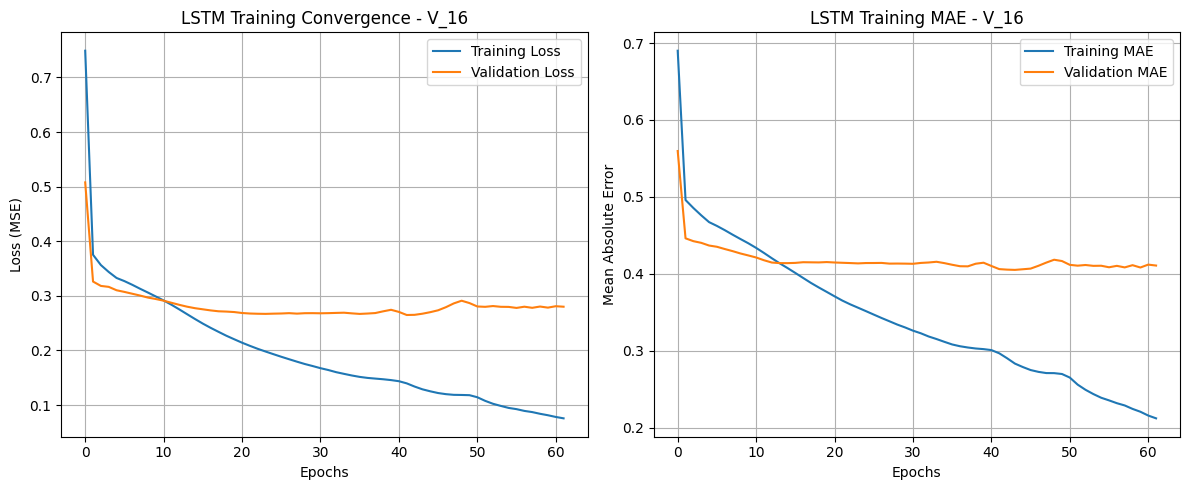


Performing sensitivity analysis on LSTM architecture...
Training with Small architecture: LSTM [32], Dense [16]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Training with Medium architecture: LSTM [64], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Training with Deep architecture: LSTM [32, 32], Dense [32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Training with Large architecture: LSTM [128], Dense [64, 32]...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


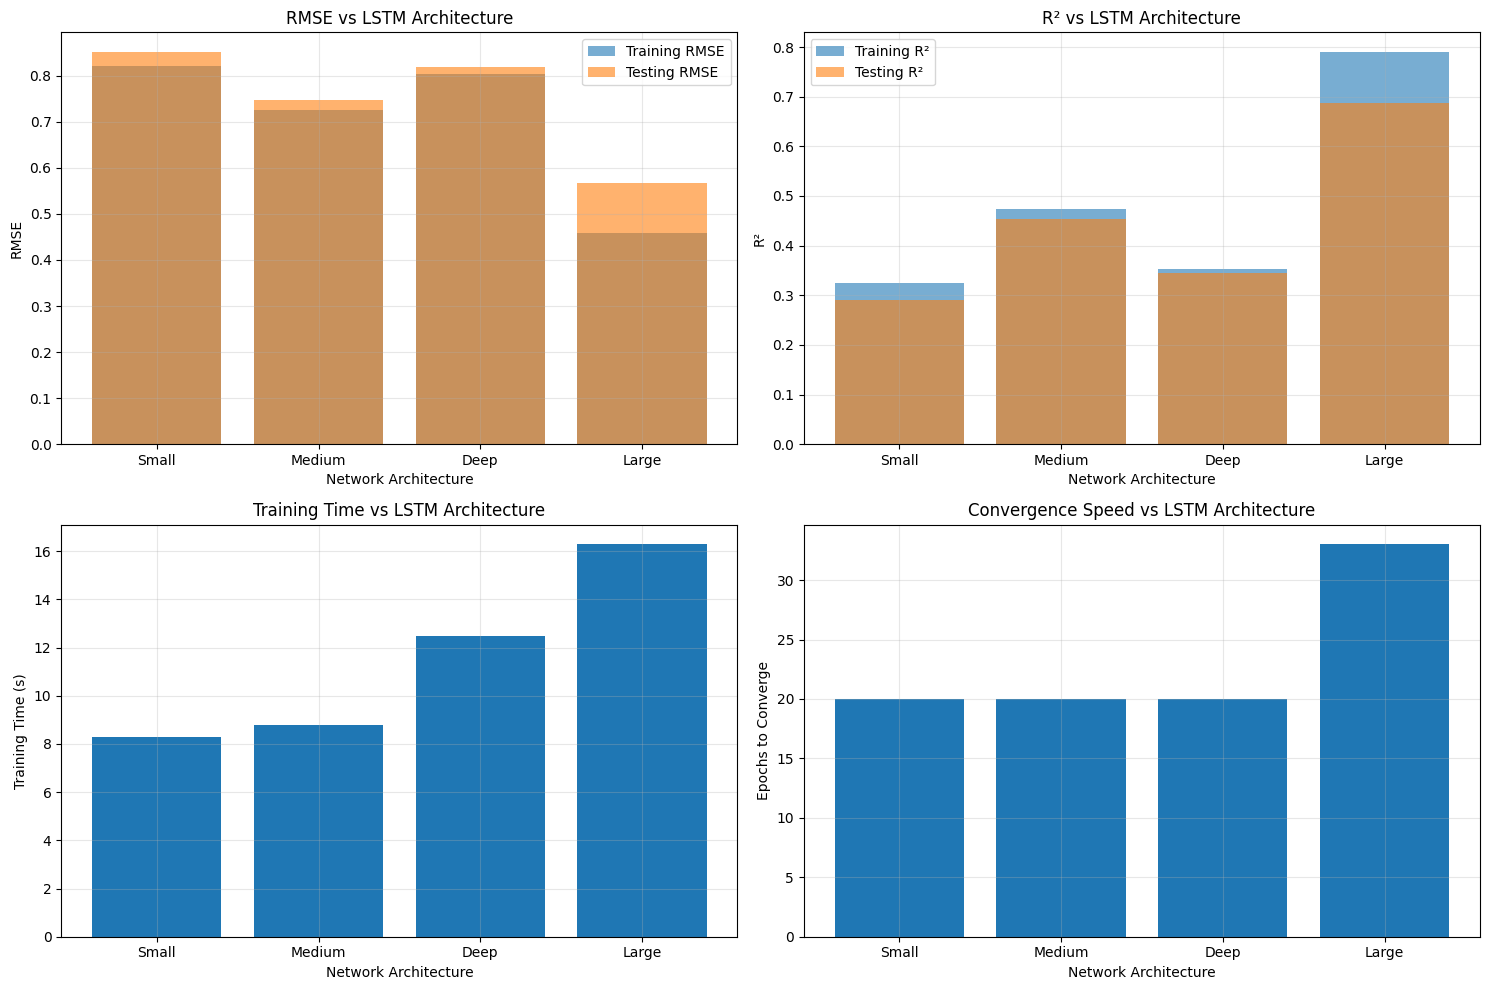


Performing window size sensitivity analysis for V_16...
Testing window size 2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Testing window size 4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Testing window size 8...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Testing window size 16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Best window size: 16, giving 4 timesteps with 16 features per step


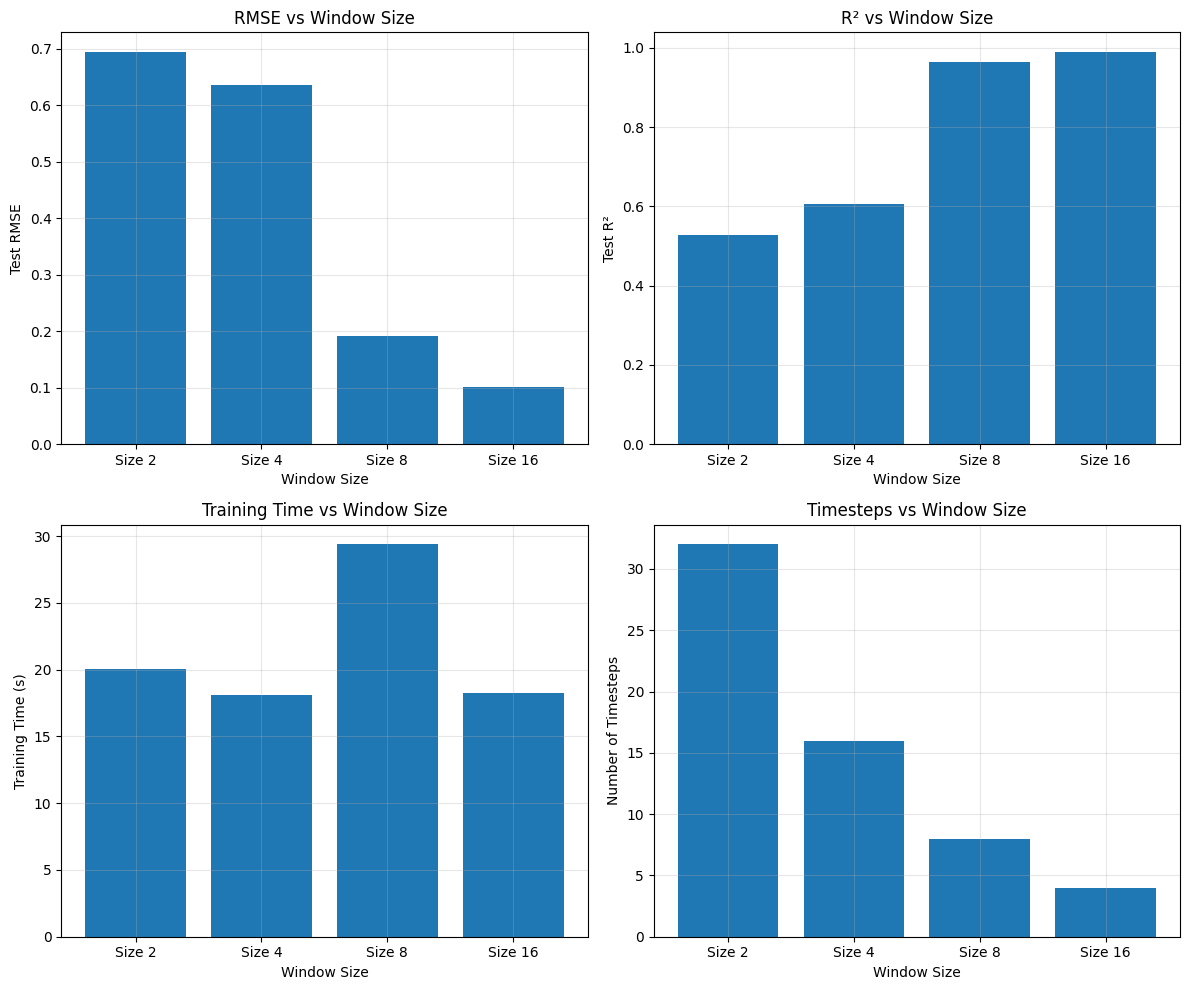


Performing learning rate and dropout tuning for V_16...
Training with learning rate=0.001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Training with learning rate=0.001, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Training with learning rate=0.001, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Training with learning rate=0.01, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Training with learning rate=0.01, dropout rate=0.2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Training with learning rate=0.01, dropout rate=0.4...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Training with learning rate=0.0001, dropout rate=0.0...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Training with lear

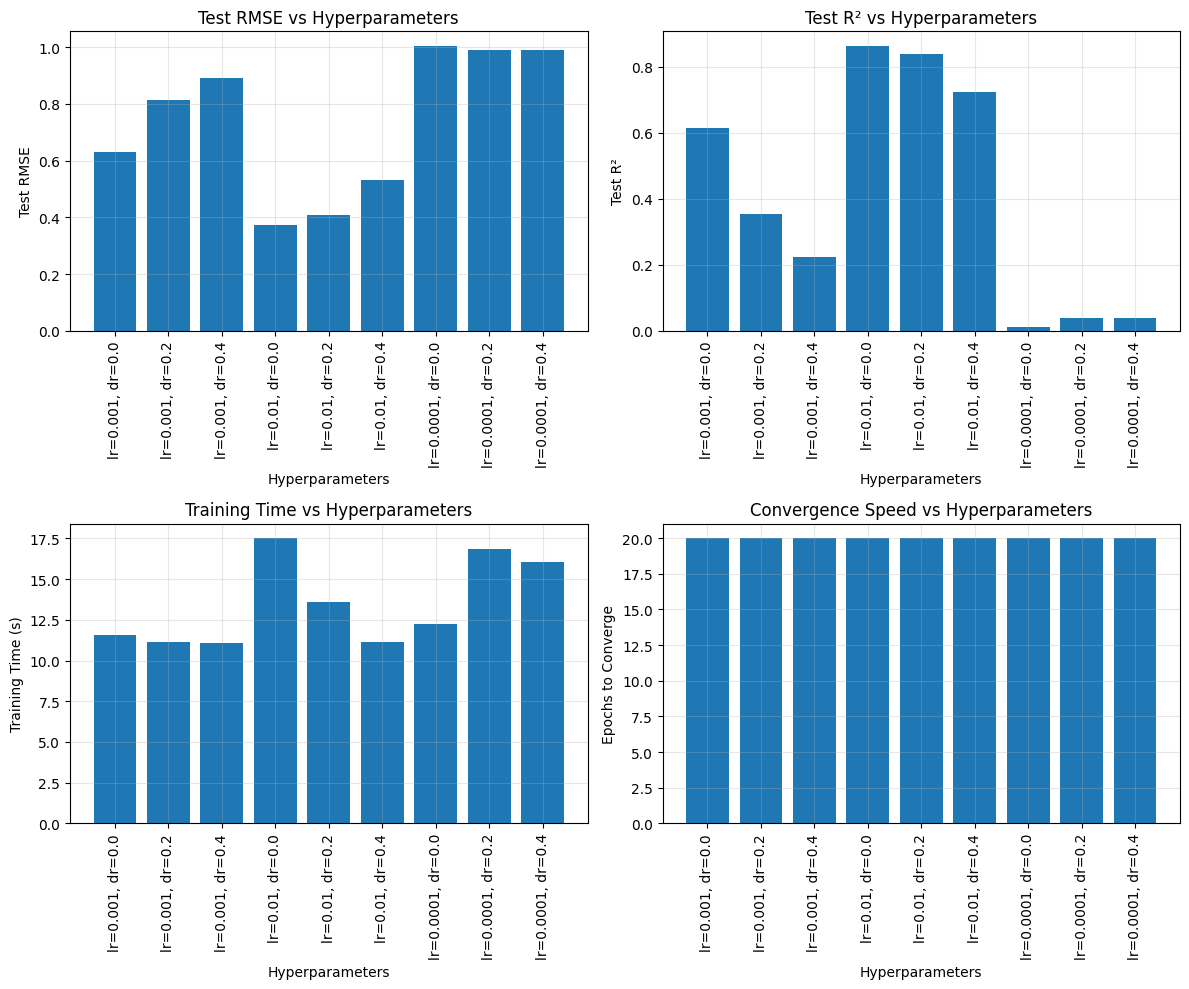


Training final LSTM model with best parameters...
Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.4315 - mae: 0.5121 - val_loss: 0.2191 - val_mae: 0.3680
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1212 - mae: 0.2783 - val_loss: 0.1000 - val_mae: 0.2518
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0642 - mae: 0.1957 - val_loss: 0.0628 - val_mae: 0.1963
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0476 - mae: 0.1695 - val_loss: 0.0755 - val_mae: 0.2055
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0246 - mae: 0.1191 - val_loss: 0.0258 - val_mae: 0.1205
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0142 - mae: 0.0937 - val_loss: 0.0394 - val_mae: 0.1480
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0220 - mae: 0.1174 - val_loss: 0.0430 - val_mae: 0.1464
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0216 - mae: 0.1137 - val_loss: 0.0853 - val_mae: 0.2233
Epoch

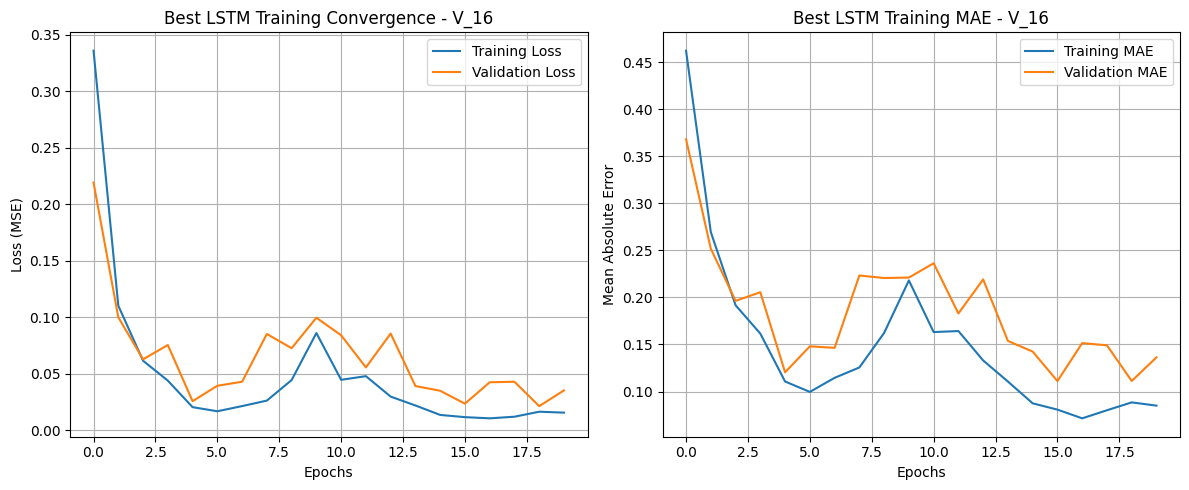


Analyzing feature importance using permutation method...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2m

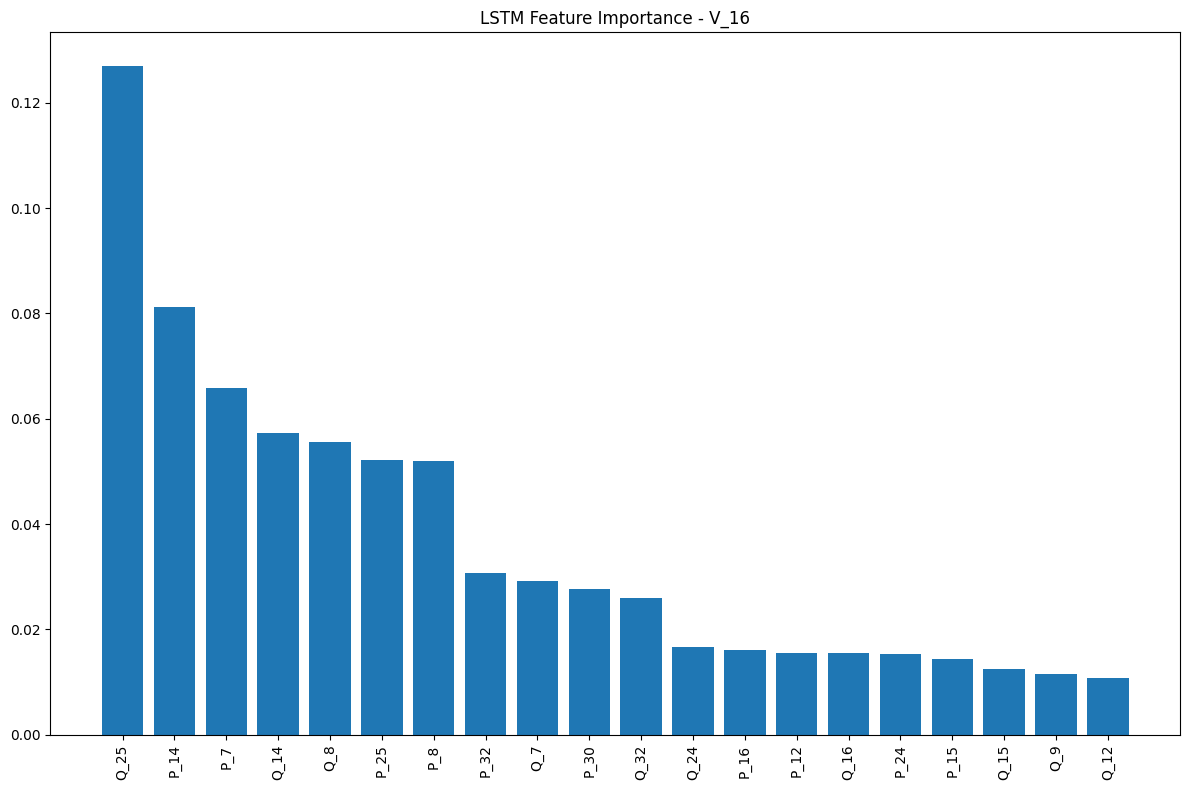

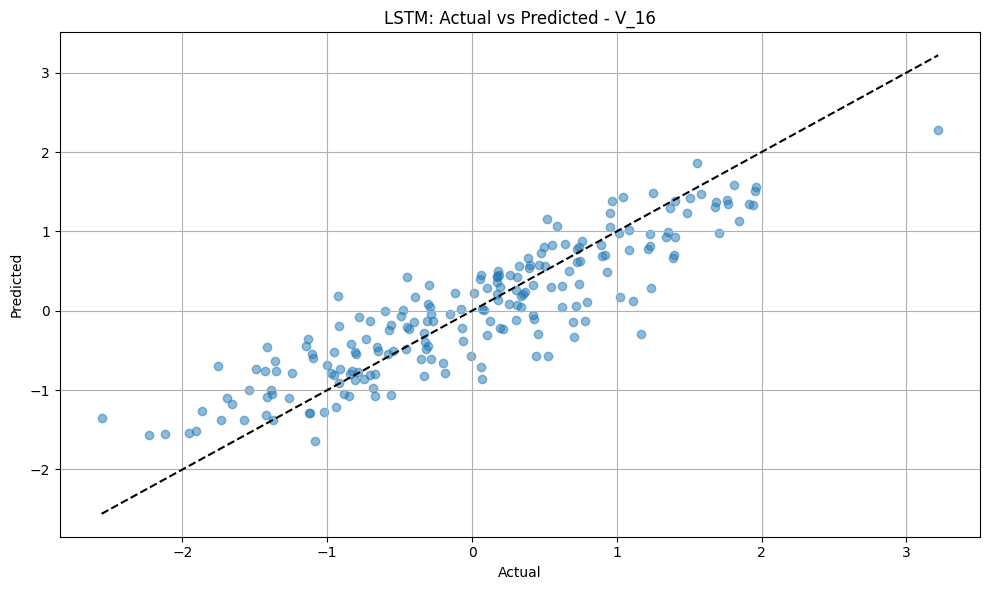


Visualizing LSTM layer activations...


ValueError: The layer sequential_164 has never been called and thus has no defined input.

In [77]:
print("\n1. Training LSTM for single voltage prediction (V_16)...")
lstm_v16_results = train_lstm_model(X_train_v16, y_train_v16, X_test_v16, y_test_v16, 'V_16', load_feature_names)

In [ ]:
print("\n2. Training LSTM for loss prediction...")
lstm_loss_results = train_lstm_model(X_train_loss, y_train_loss, X_test_loss, y_test_loss, 'loss', load_feature_names)

In [ ]:
print("\n3. Training LSTM for all voltages prediction...")
lstm_all_v_results = train_lstm_model(X_train_all_v, y_train_all_v, X_test_all_v, y_test_all_v, 'all_voltages', load_feature_names)

In [ ]:
print("\nSaving trained LSTM models...")

# Save models in TensorFlow's SavedModel format
lstm_v16_results['best_model']['model'].save('models/lstm/lstm_v16_best_model')
lstm_loss_results['best_model']['model'].save('models/lstm/lstm_loss_best_model')
lstm_all_v_results['best_model']['model'].save('models/lstm/lstm_all_v_best_model')

# Save reshape info and parameters (needed for preprocessing new data)
with open('models/lstm/lstm_v16_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': lstm_v16_results['best_model']['scaler'],
        'reshape_info': lstm_v16_results['best_model']['reshape_info'],
        'params': lstm_v16_results['best_model']['params']
    }, f)

with open('models/lstm/lstm_loss_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': lstm_loss_results['best_model']['scaler'],
        'reshape_info': lstm_loss_results['best_model']['reshape_info'],
        'params': lstm_loss_results['best_model']['params']
    }, f)

with open('models/lstm/lstm_all_v_params.pkl', 'wb') as f:
    pickle.dump({
        'scaler': lstm_all_v_results['best_model']['scaler'],
        'reshape_info': lstm_all_v_results['best_model']['reshape_info'],
        'params': lstm_all_v_results['best_model']['params']
    }, f)

print("LSTM models saved successfully!")

In [ ]:
print("\n=== LSTM Models Summary ===")
print(f"V_16 Prediction - Test R²: {lstm_v16_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {lstm_v16_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"Loss Prediction - Test R²: {lstm_loss_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {lstm_loss_results['best_model']['test_metrics']['RMSE']:.4f}")
print(f"All Voltages Prediction - Test R²: {lstm_all_v_results['best_model']['test_metrics']['R2']:.4f}, RMSE: {lstm_all_v_results['best_model']['test_metrics']['RMSE']:.4f}")

In [ ]:
def predict_with_lstm(model_name, X_new):
    """
    Make predictions using a saved LSTM model
    
    Parameters:
    model_name (str): Name of the model ('v16', 'loss', or 'all_voltages')
    X_new (np.array): New input data to make predictions on
    
    Returns:
    np.array: Predictions
    """
    # Load model and parameters
    model = tf.keras.models.load_model(f'models/lstm/lstm_{model_name}_best_model')
    
    with open(f'models/lstm/lstm_{model_name}_params.pkl', 'rb') as f:
        params = pickle.load(f)
    
    scaler = params['scaler']
    reshape_info = params['reshape_info']
    
    # Scale the input data
    X_scaled = scaler.transform(X_new)
    
    # Reshape for LSTM
    window_size = reshape_info['window_size']
    n_samples = X_scaled.shape[0]
    n_features = X_scaled.shape[1]
    
    # Pad features if needed to make them divisible by window_size
    padding = 0
    if n_features % window_size != 0:
        padding = window_size - (n_features % window_size)
        padded_X = np.pad(X_scaled, ((0, 0), (0, padding)), 'constant')
        n_features = padded_X.shape[1]
    else:
        padded_X = X_scaled
        
    # Reshape to [samples, timesteps, features_per_timestep]
    n_timesteps = n_features // window_size
    X_seq = padded_X.reshape(n_samples, n_timesteps, window_size)
    
    # Make predictions
    predictions = model.predict(X_seq)
    
    return predictions

### CNN

In [ ]:
try:
    print("\n=== Model Comparison: ANN vs Random Forest ===")
    print(f"V_16 Prediction - ANN R²: {ann_v16_results['best_model']['test_metrics']['R2']:.4f}, RF R²: {rf_v16_results['best_model']['test_metrics']['R2']:.4f}")
    print(f"Loss Prediction - ANN R²: {ann_loss_results['best_model']['test_metrics']['R2']:.4f}, RF R²: {rf_loss_results['best_model']['test_metrics']['R2']:.4f}")
    print(f"All Voltages Prediction - ANN R²: {ann_all_v_results['best_model']['test_metrics']['R2']:.4f}, RF R²: {rf_all_v_results['best_model']['test_metrics']['R2']:.4f}")
except NameError:
    print("Random Forest results not available for comparison.")
